# US State House Elections 2016 + 2020

The goal of this project was to be able to predict election results from the 2016 and 2020 US State House of Representative Elections reasonably well.

The target variable for 2016 is webscraped from the webpage www.ballotpedia.com. As for 2020 webscraping wasn't possible the data was taken from the MIT Election and Scienc Lab. The notebooks with this process can be found under **xxxxx**.

Data for the features are from the US Census Bureau for the years 2016 and 2020. Every possibly useful information on election district level was gathered. Certainly there could have been more predictive variables than some of the ones used. However, it's almost impossible to gather this data on the district level for State elections.

As the unit of measurement is on district level every value for a certain district represents how many percent of the disctrict population takes on a certain characteristic. Some of the variables don't show percentages, but rather median values for the respective district. The process of data gathering can be found under "Census Data Preparation 2016" and "Census Data Preparation 2020".

In [1]:
#!pip install scipy --upgrade

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, KBinsDiscretizer
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
!pip install lightgbm
from lightgbm import LGBMClassifier
!pip install catboost
from catboost import CatBoostClassifier
!pip install empiricaldist
from empiricaldist import Cdf
!pip install sktools
from sktools import GradientBoostingFeatureGenerator
!pip install empiricaldist
from empiricaldist import Cdf
from scipy.stats import ttest_ind
from collections import Counter
!pip install mrmr_selection
from mrmr import mrmr_classif

import warnings
warnings.filterwarnings("ignore")

In [4]:
df_2016 = pd.read_csv("drive/MyDrive/US Elections/data_final_2016.csv")
df_2020 = pd.read_csv("drive/MyDrive/US Elections/data_final_2020.csv")

In [5]:
df = pd.concat([df_2016, df_2020])
df = df.reset_index(drop=True)

pd.set_option("display.max_columns", None)
df.head()

district  percent households receiving food stamps   state  \
0        1                                      14.1  alaska   
1        2                                       7.2  alaska   
2        3                                       5.4  alaska   
3        4                                       4.7  alaska   
4        5                                       4.0  alaska   

   percent uninsured  household language not english  non-white  \
0               18.3                            15.4   0.369463   
1                8.1                            15.0   0.259593   
2               11.0                             6.4   0.178482   
3                8.2                             6.5   0.102099   
4               14.1                            10.0   0.287074   

   black/afroamerican  percent female  under 20  20 to 34  35 to 49  50 to 64  \
0            0.088753          0.4755      23.0      31.7      15.6      19.1   
1            0.063050          0.4379      33.2      38.7      14.1       8.9   
2            0.022357          0.4623      31.5      22.9      20.2      18.8   
3            0.002420          0.4416      23.0      27.2      18.0      21.6   
4            0.040892          0.4618      26.5      25.2      21.2      19.2   

   65 and over  median age  monthly housing costs - $499 or lower  \
0         10.4        31.8                                    9.6   
1          5.2        25.2                                    4.5   
2          6.6        31.7                                    7.2   
3         10.1        34.9                                    9.2   
4          8.0        33.7                                   10.0   

   monthly housing costs - $500 - 999  monthly housing costs - $1000 1999  \
0                                26.9                                46.3   
1                                15.4                                40.6   
2                                17.6                                43.7   
3                                25.2                                40.2   
4                                25.0                                44.7   

   monthly housing costs - $2000 or higher  monthly housing costs - median  \
0                                     14.7                          1165.0   
1                                     35.0                          1674.0   
2                                     30.9                          1680.0   
3                                     22.5                          1328.0   
4                                     20.0                          1242.0   

   percent owner-occupied housing units  average family size  native  \
0                                  42.3                 3.34  0.9144   
1                                  36.9                 3.43  0.9345   
2                                  74.4                 3.48  0.9707   
3                                  76.4                 3.19  0.9857   
4                                  64.7                 3.46  0.9405   

   foreign born  percent of tot. population in poverty  \
0        0.0856                                   15.3   
1        0.0655                                    6.4   
2        0.0293                                    7.4   
3        0.0143                                    5.1   
4        0.0595                                    5.9   

   management, business, science, and arts occupations  service occupations  \
0                                             0.2823                 0.2360   
1                                             0.3377                 0.2091   
2                                             0.3624                 0.1202   
3                                             0.4297                 0.1777   
4                                             0.4315                 0.1362   

   sales and office occupations  blue collar occupations  \
0                        0.2810                   0.2008   
1  

In [6]:
# Change all percentage values between 0 and 1 to an absolute number
percentage_cols_change = [col for col in df.select_dtypes(["number"]).columns if df[col].max() < 1]
df[percentage_cols_change] = df[percentage_cols_change].apply(lambda x: round(x*100, 2))

# Delete districts with independent MPs
df = df.drop(df[df.target == 2].index)

In [7]:
# Delete native, parties and office columns
df.drop(["native", "republican", "democrat", "other", "office"], axis=1, inplace=True)

# Exploratory Data Analysis



## 1. Basic Exploration
Tasks:
* 4 Missing values in "monthly housing costs - median"

In [8]:
df.shape

(7554, 38)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7554 entries, 0 to 7580
Data columns (total 38 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   district                                             7554 non-null   object 
 1   percent households receiving food stamps             7554 non-null   float64
 2   state                                                7554 non-null   object 
 3   percent uninsured                                    7554 non-null   float64
 4   household language not english                       7554 non-null   float64
 5   non-white                                            7554 non-null   float64
 6   black/afroamerican                                   7554 non-null   float64
 7   percent female                                       7554 non-null   float64
 8   under 20                                             7554 non-null  

In [10]:
df.describe()

percent households receiving food stamps  percent uninsured  \
count                               7554.000000        7554.000000   
mean                                  12.567487           9.395804   
std                                    8.013686           5.497548   
min                                    0.200000           0.200000   
25%                                    6.700000           5.300000   
50%                                   11.000000           8.400000   
75%                                   16.600000          12.300000   
max                                   57.100000          44.700000   

       household language not english    non-white  black/afroamerican  \
count                     7554.000000  7554.000000         7554.000000   
mean                        15.185676    22.990226           10.795649   
std                         15.507661    20.173216           15.904813   
min                          0.200000     0.570000            0.000000   
25%                          4.800000     7.862500            1.360000   
50%                          9.400000    16.210000            4.110000   
75%                         19.400000    30.547500           12.317500   
max                         90.800000    98.030000           96.840000   

       percent female     under 20     20 to 34     35 to 49     50 to 64  \
count     7554.000000  7554.000000  7554.000000  7554.000000  7554.000000   
mean        51.472847    25.157446    20.219030    18.754743    19.979956   
std          2.232013     4.100215     5.689813     2.385204     3.262955   
min         34.620000     7.900000     6.800000     3.800000     2.970000   
25%         50.370000    22.800000    16.690000    17.400000    18.100000   
50%         51.520000    25.000000    19.065000    18.730000    20.260000   
75%         52.670000    27.440000    22.500000    20.130000    21.990000   
max         61.580000    50.700000    71.430000    31.300000    34.200000   

       65 and over   median age  monthly housing costs - $499 or lower  \
count  7554.000000  7554.000000                            7554.000000   
mean     15.887975    39.099047                              18.607710   
std       4.751583     5.533918                              11.805757   
min       2.000000    18.800000                               0.000000   
25%      12.700000    35.500000                               9.212500   
50%      15.800000    39.300000                              16.270000   
75%      18.600000    42.600000                              26.020000   
max      53.820000    66.600000                              72.880000   

       monthly housing costs - $500 - 999  monthly housing costs - $1000 1999  \
count                         7554.000000                         7554.000000   
mean                            32.065172                           35.166599   
std                             10.604634                           11.421065   
min                              2.040000                            2.100000   
25%                             24.200000                           26.770000   
50%                             33.385000                           36.100000   
75%                             40.000000                           43.180000   
max                             64.400000                           74.660000   

       monthly housing costs - $2000 or higher  \
count                              7554.000000   
mean                                 13.111064   
std                                  13.397450   
min                                   0.000000   
25%                                   3.590000   
50%                                   7.730000   
75%                                  18.100000   
max                                  79.630000   

       monthly housing costs - median  percent owner-occupied housing units  \
count                     7550.000000                           7554.000000   
mean     

## Target Variable Distribution

0    4095
1    3459
Name: target, dtype: int64



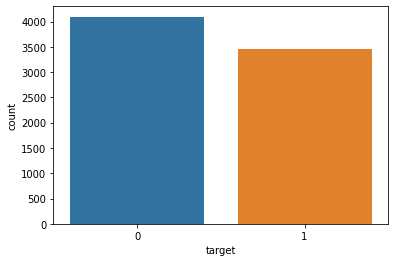

In [11]:
print(df.target.value_counts())
print()
sns.countplot(x="target", data=df);

In [12]:
print("Percentage of Target Values")
round(df.target.value_counts() / df.target.value_counts().sum() * 100, 2)

Percentage of Target Values


0    54.21
1    45.79
Name: target, dtype: float64

Target variable is slightly imbalanced. While 54% of all districts elected a republican candidate and Democrats were elected in 45% of all districts.

## Data Splitting

In [13]:
# Stratified Sampling
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.25, stratify=df.target, random_state=42)

In [14]:
train.target.value_counts()

0    3071
1    2594
Name: target, dtype: int64

In [15]:
test.target.value_counts()

0    1024
1     865
Name: target, dtype: int64

In [16]:
X_test = test.drop("target", axis=1)
y_test = test.target

In [17]:
num_cols = train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = train.select_dtypes(exclude=["number"]).columns.tolist()

## Visualizations

### Univariate Exploration

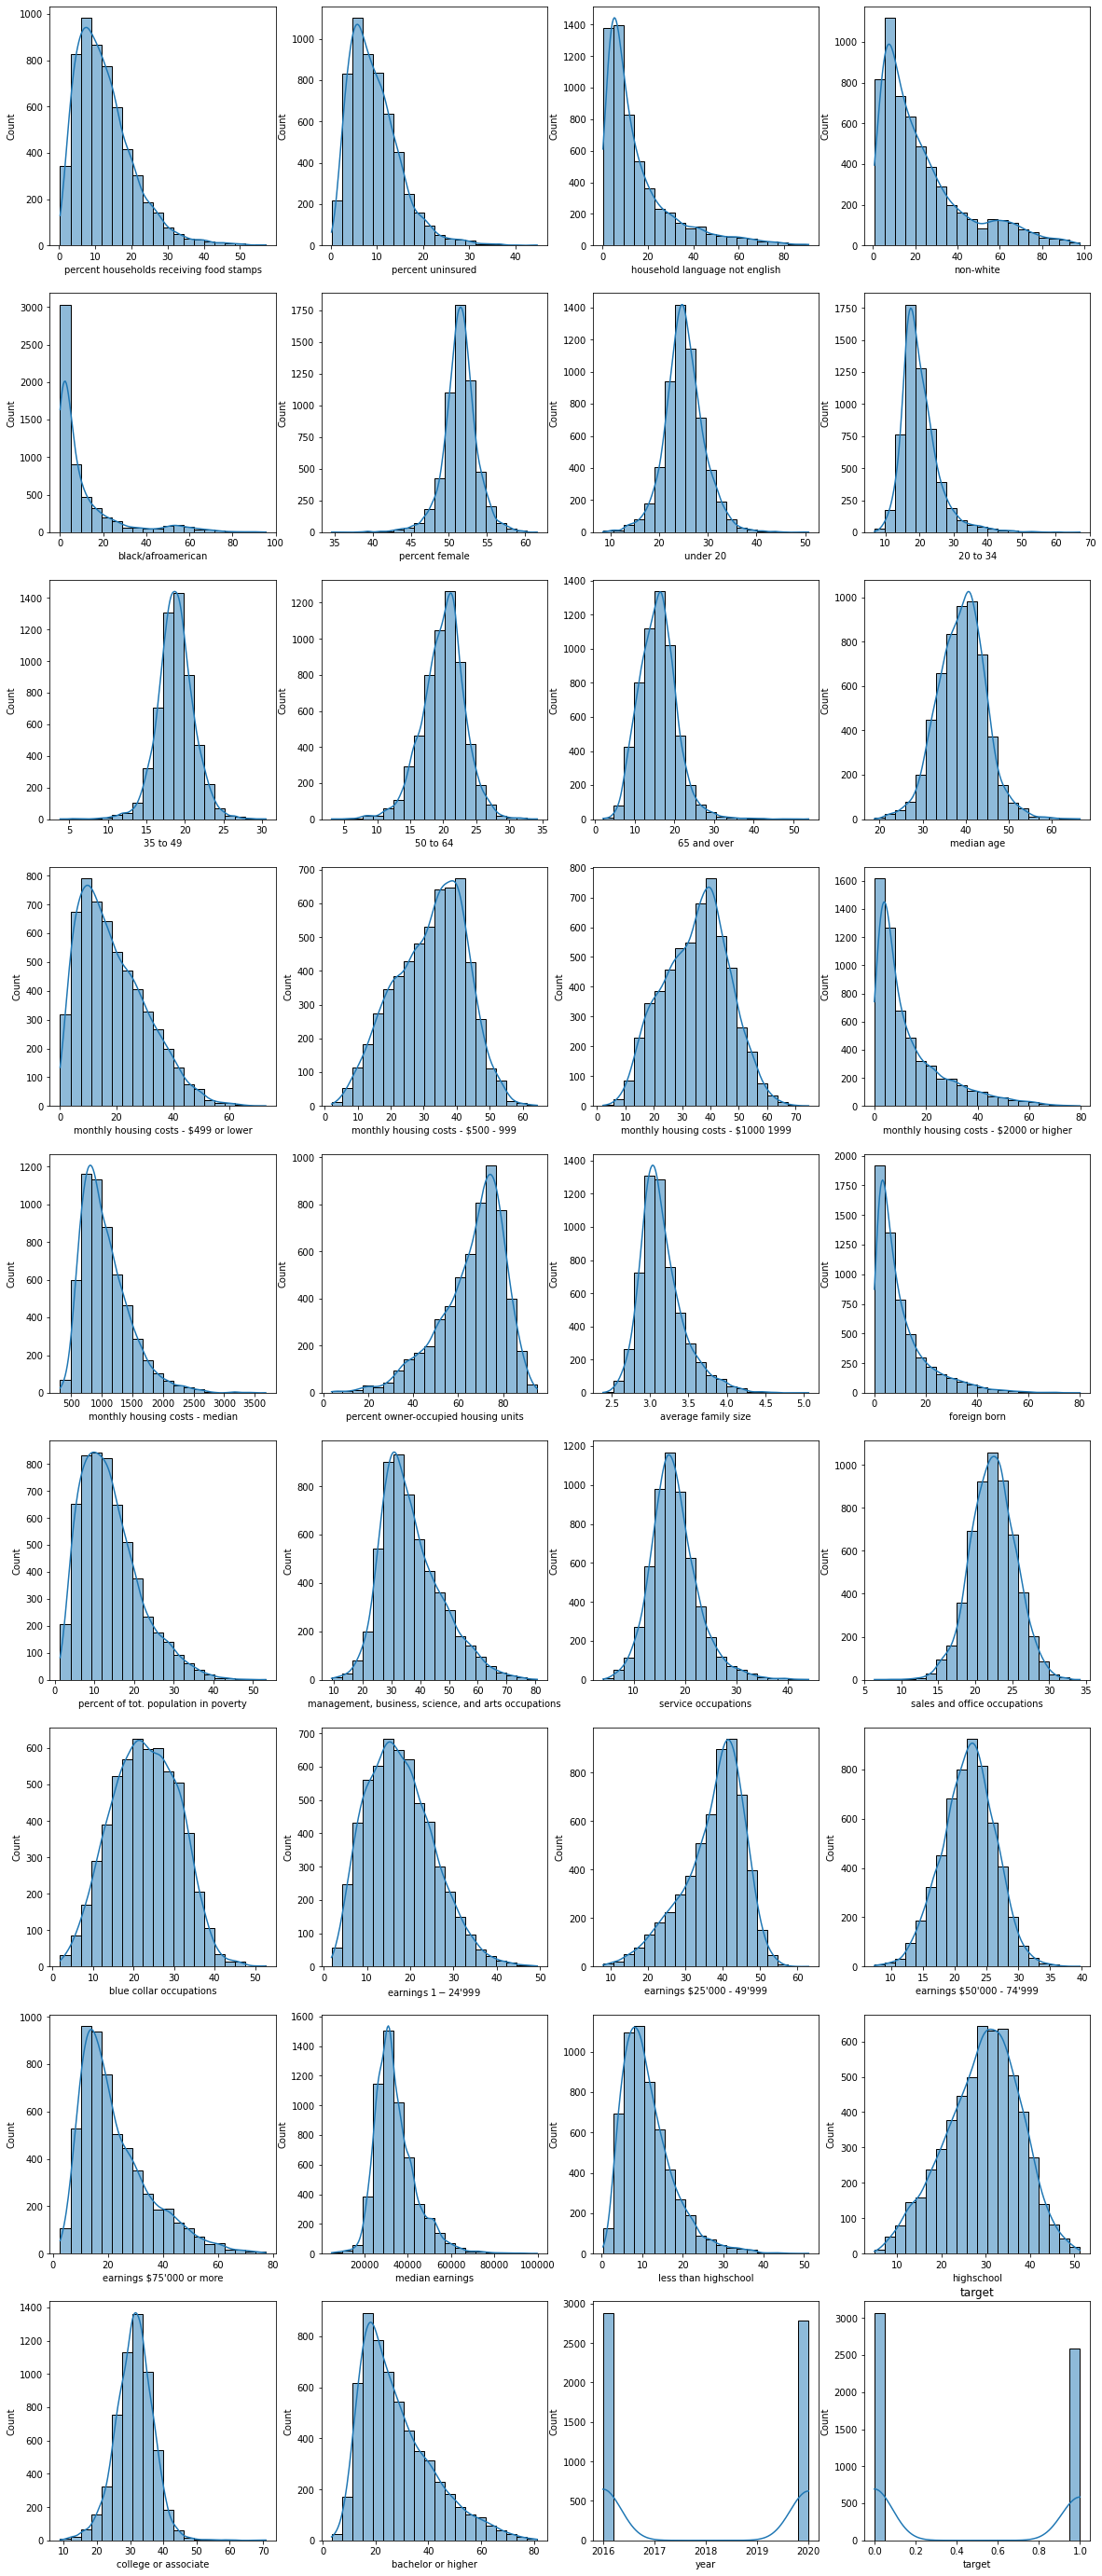

In [ ]:
fig, axes = plt.subplots(nrows=9,
                         ncols=4,
                         figsize=(20, 50))
for ax, col in zip(axes.flatten(), train[num_cols].columns):
  sns.histplot(x=col, data=train, bins=20, kde=True, ax=ax)
  plt.title(col);

In [ ]:
# Check for skewness and kurtosis of the data (-> how far from normally distributed variables are)
normal_dist = pd.DataFrame()
normal_dist["skew"] = train.select_dtypes(include=["number"]).skew()
normal_dist["kurtosis"] = train.select_dtypes(include=["number"]).kurtosis()
normal_dist

skew  kurtosis
percent households receiving food stamps            1.285262  2.427372
percent uninsured                                   1.297638  2.764714
household language not english                      1.930569  3.794968
non-white                                           1.385395  1.305108
black/afroamerican                                  2.343439  5.289239
percent female                                     -0.580336  3.516022
under 20                                            0.239425  1.798852
20 to 34                                            1.768992  5.980625
35 to 49                                           -0.173592  2.055864
50 to 64                                           -0.342480  1.104877
65 and over                                         0.845547  3.248711
median age                                          0.069360  0.740474
monthly housing costs - $499 or lower               0.785307  0.184571
monthly housing costs - $500 - 999                 -0.257685 -0.528052
monthly housing costs - $1000 1999                 -0.081592 -0.514915
monthly housing costs - $2000 or higher             1.660101  2.508299
monthly housing costs - median                      1.328072  2.802455
percent owner-occupied housing units               -1.005872  1.007602
average family size                                 1.158419  2.324535
foreign born                                        2.064813  5.181087
percent of tot. population in poverty               0.970572  0.929891
management, business, science, and arts occupat...  0.781220  0.552607
service occupations                                 0.815615  1.973056
sales and office occupations                       -0.104415  0.427416
blue collar occupations                             0.026382 -0.470826
earnings $1 - $24'999                               0.526487  0.043212
earnings $25'000 - 49'999                          -0.779824  0.344386
earnings $50'000 - 74'999                          -0.093936  0.165790
earnings $75'000 or more                            1.206800  1.263936
median earnings                                     1.286243  3.357397
less than highschool                                1.339962  2.607369
highschool                                         -0.268618 -0.299990
college or associate                                0.071477  2.046224
bachelor or higher                                  1.018447  0.658556
year                                                0.036379 -1.999383
target                                              0.169047 -1.972119

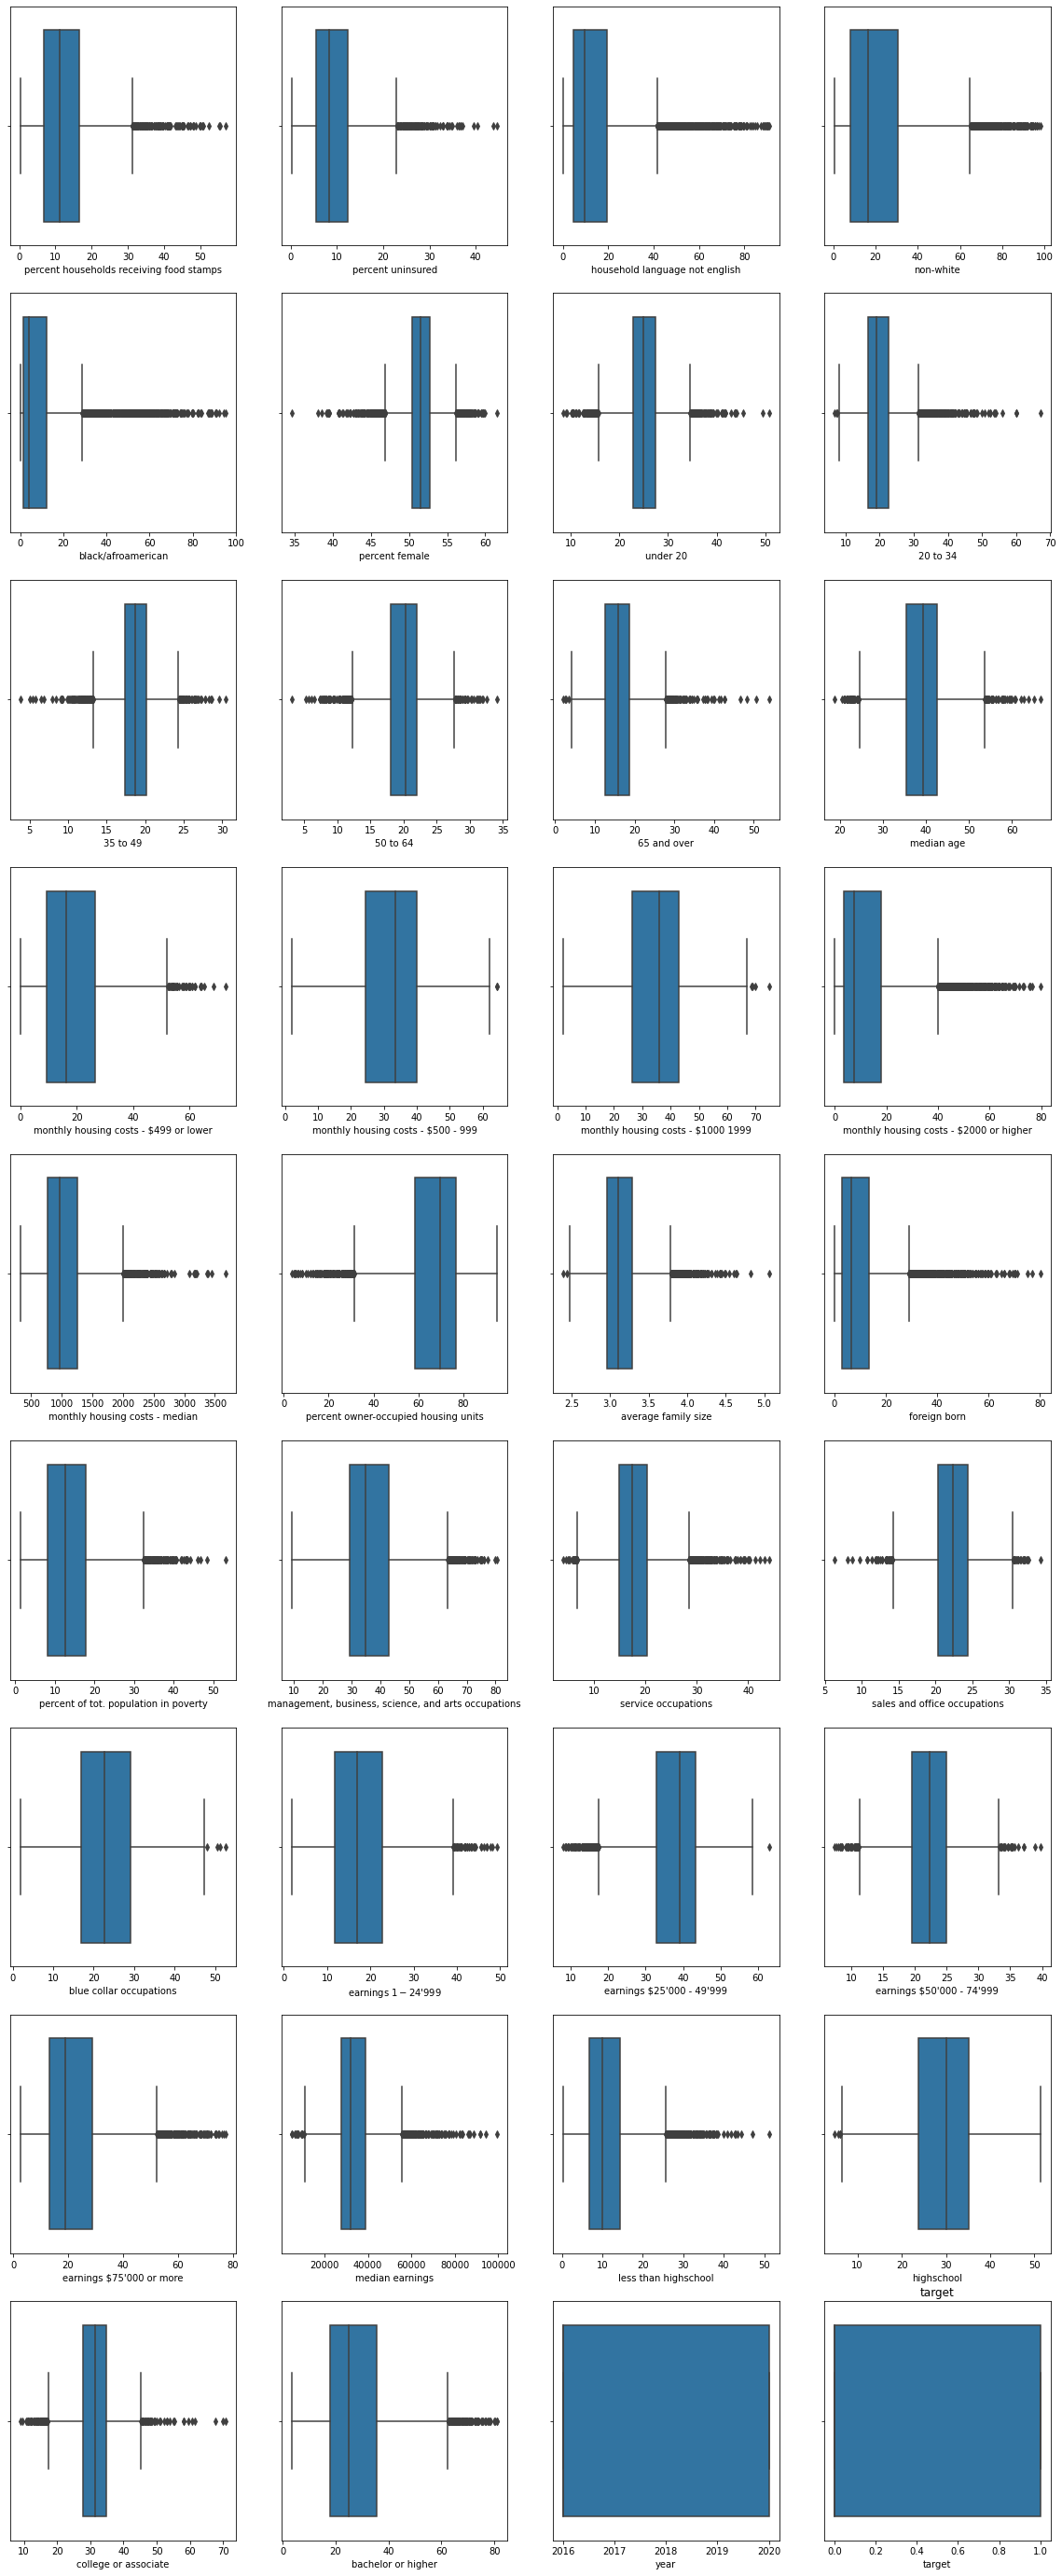

In [ ]:
# Distribution of variables with boxplots
fig, axes = plt.subplots(nrows=9,
                       ncols=4,
                       figsize=(20, 50))

for ax, col in zip(axes.flatten(), train[num_cols].columns):
  sns.boxplot(x=train[col], ax = ax)
  plt.title(col);

### Bivariate Exploration

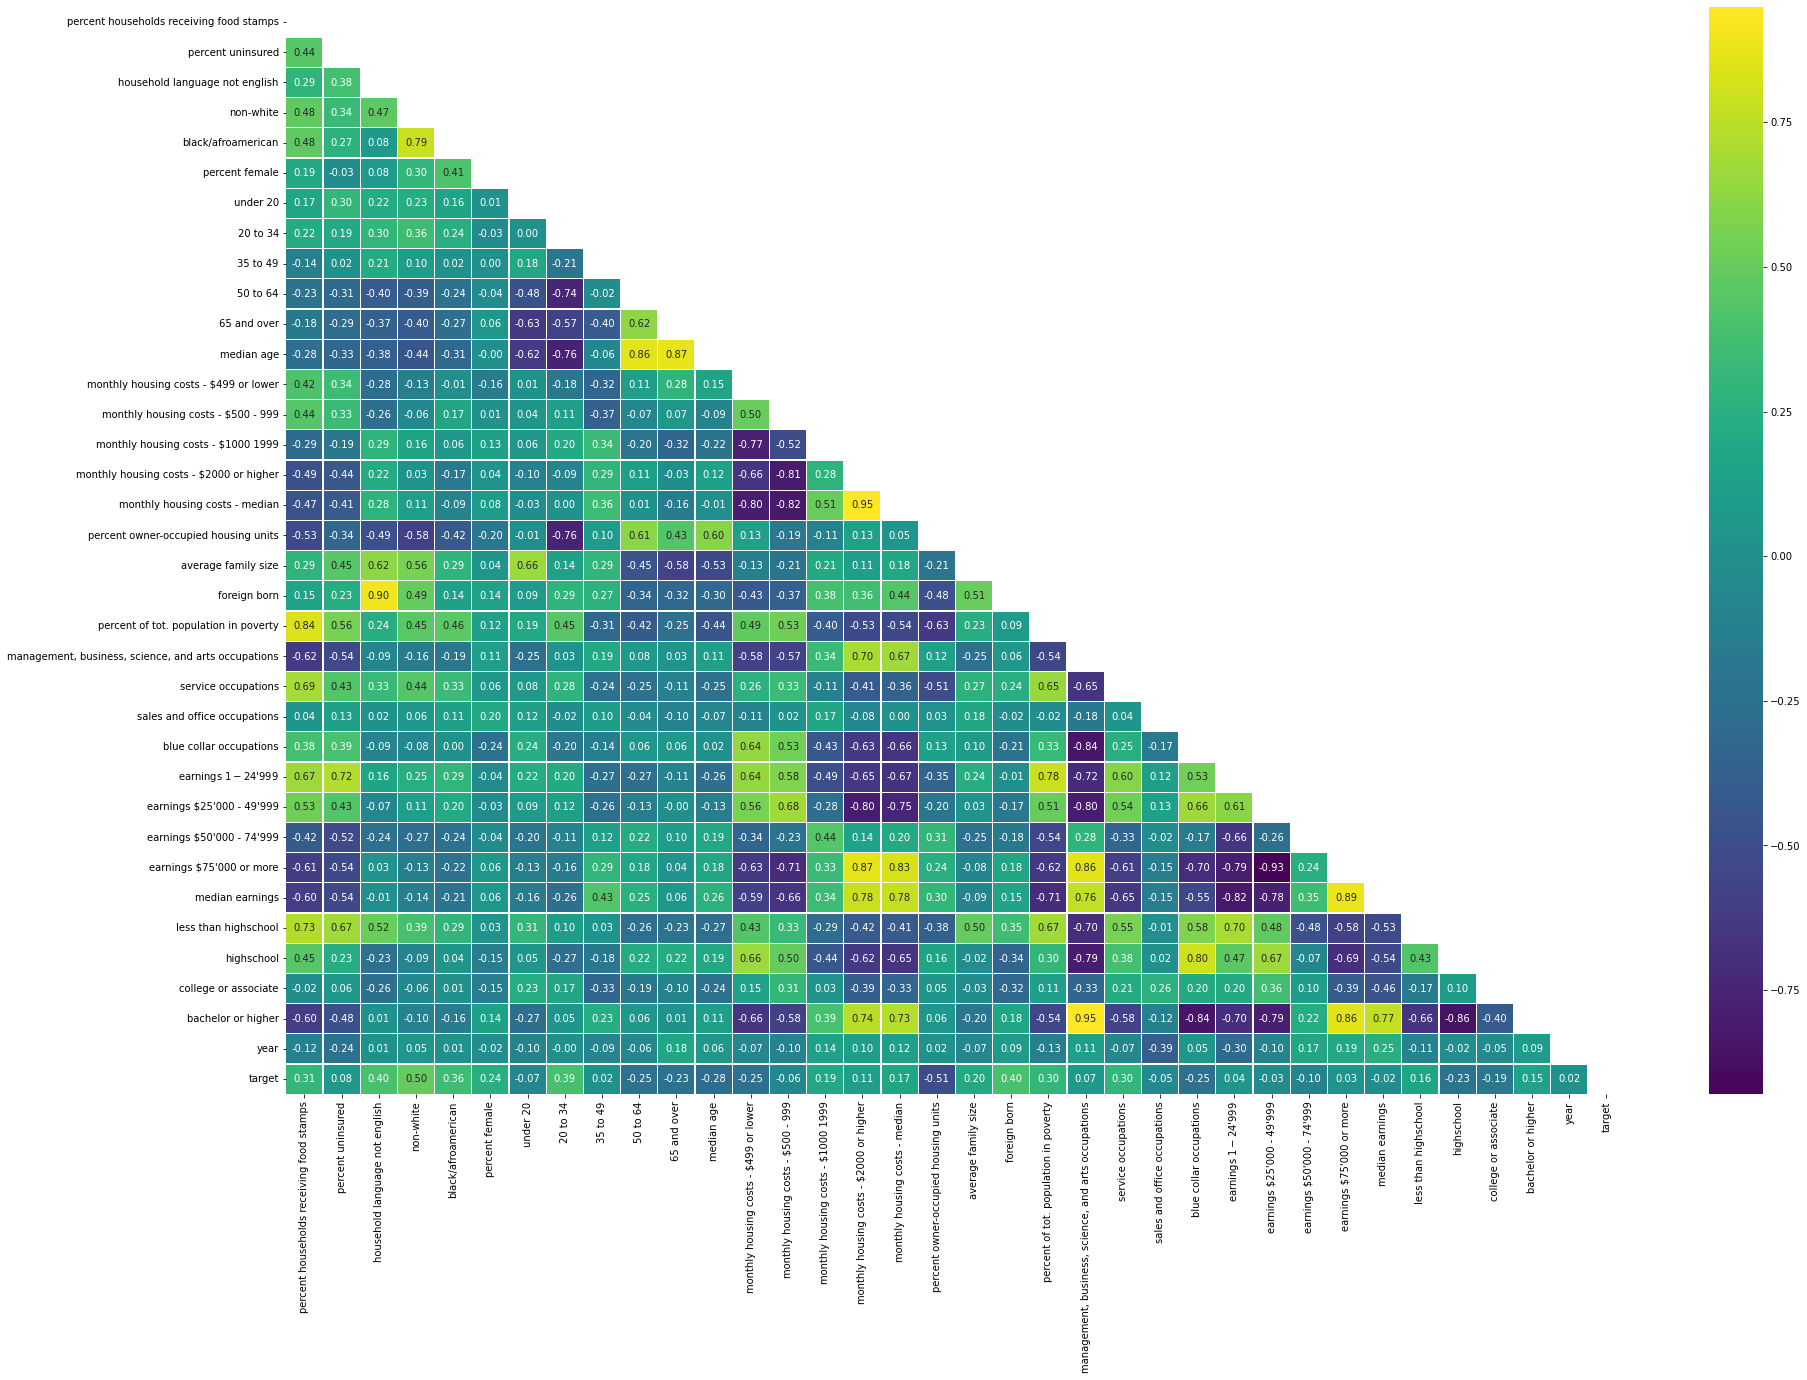

In [ ]:
# Check for correlation of features
corr_matrix = train[num_cols].corr()
plt.figure(figsize=(30, 20))
a = sns.heatmap(data=corr_matrix, 
                cmap="viridis",
                center=0,
                annot=True,
                fmt=".2f",
                lw=0.3,
                mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))

In [ ]:
# Features with high correlation to target
corr_matrix["target"].abs().sort_values(ascending=False)[:15]

target                                      1.000000
percent owner-occupied housing units        0.507908
non-white                                   0.500775
foreign born                                0.397366
household language not english              0.395058
20 to 34                                    0.389238
black/afroamerican                          0.359255
percent households receiving food stamps    0.309411
service occupations                         0.300894
percent of tot. population in poverty       0.297264
median age                                  0.280985
50 to 64                                    0.251538
blue collar occupations                     0.249217
monthly housing costs - $499 or lower       0.246653
percent female                              0.244857
Name: target, dtype: float64

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from scipy.stats import ttest_ind
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline


def pval_auc(df):
  """This function produces a grid of boxplots where each feature is analyzed 
  for both target characteristics. Additionally, two models are calculated for 
  each feature. One dummy/naive model and one model with the respective feature 
  as input. The features are transformed to a more normal distribution. 
  The p-value states if the means of the cross-validated AUC scores of the model 
  with the feature are bigger than the means of the naive model. The boxplots 
  are in descending order by p-value which means that the last features should 
  have the least predictive power."""
  
  # Make copy of df to fill in NAs with median
  df_new = df.copy()
  df_new.fillna(df["monthly housing costs - median"].median(), inplace=True)

  # Make list array of auc scores for dummy classifier which constantly predicts majority class
  dummy_scores = np.array([0.5] * 10)
  # List to save p values
  p_values = []

  # Pipeline with normalization, standardization and Logistic Regression
  pipe = Pipeline(steps=[("norm_stand", PowerTransformer()), ("log_reg", LogisticRegression(random_state=42))])

  # Loop through all numeric cols excep target and calculate auc score with cross validation
  for num, col in enumerate(df_new[num_cols].drop("target", axis=1).columns):
    test_scores = cross_val_score(pipe, 
                                  df_new[col].to_frame(), 
                                  df_new.target, 
                                  cv=10, 
                                  scoring="roc_auc",
                                  n_jobs=-1)
    # Calculate p values between auc scores of respective col and dummy classifier to see whether classifier with variable is better at predicting party
    # alternative = greater means one sided t-test (checks whether mean of test_scores greater than mean of dummy_scores)
    _, pval = ttest_ind(test_scores, dummy_scores, alternative="greater")
    p_values.append(pval)
  
  # Save features and pvalues in a sorted list from lowerst to highest pvalue
  feature_pvalues = sorted(list(zip(p_values, df_new[num_cols].columns)))

  # Create a list of sorted column names to plot them
  features, pvalue_sorted = [], []
  for pval, col in sorted(feature_pvalues):
    pvalue_sorted.append(pval)
    features.append(col)

  # Add plots to the figure
  fig, ax = plt.subplots(nrows=7,
                    ncols=5,
                    figsize=(20,35))

  for num, ax, col, pval in zip(np.arange(0, 35), ax.flatten(), features, pvalue_sorted):    
    sns.boxplot(x=train["target"], y=train[col], ax=ax) #PowerTransformer().fit_transform(train[col].to_frame()).flatten()
    ax.set_title(f"p-value: {round(pval, 4)}")
    ax.set_xlabel("party")
    ax.set_ylabel(col)
    ax.set_xticklabels(["rep", "dem"])
  fig.tight_layout()
  # return a sorted list of p values
  return feature_pvalues

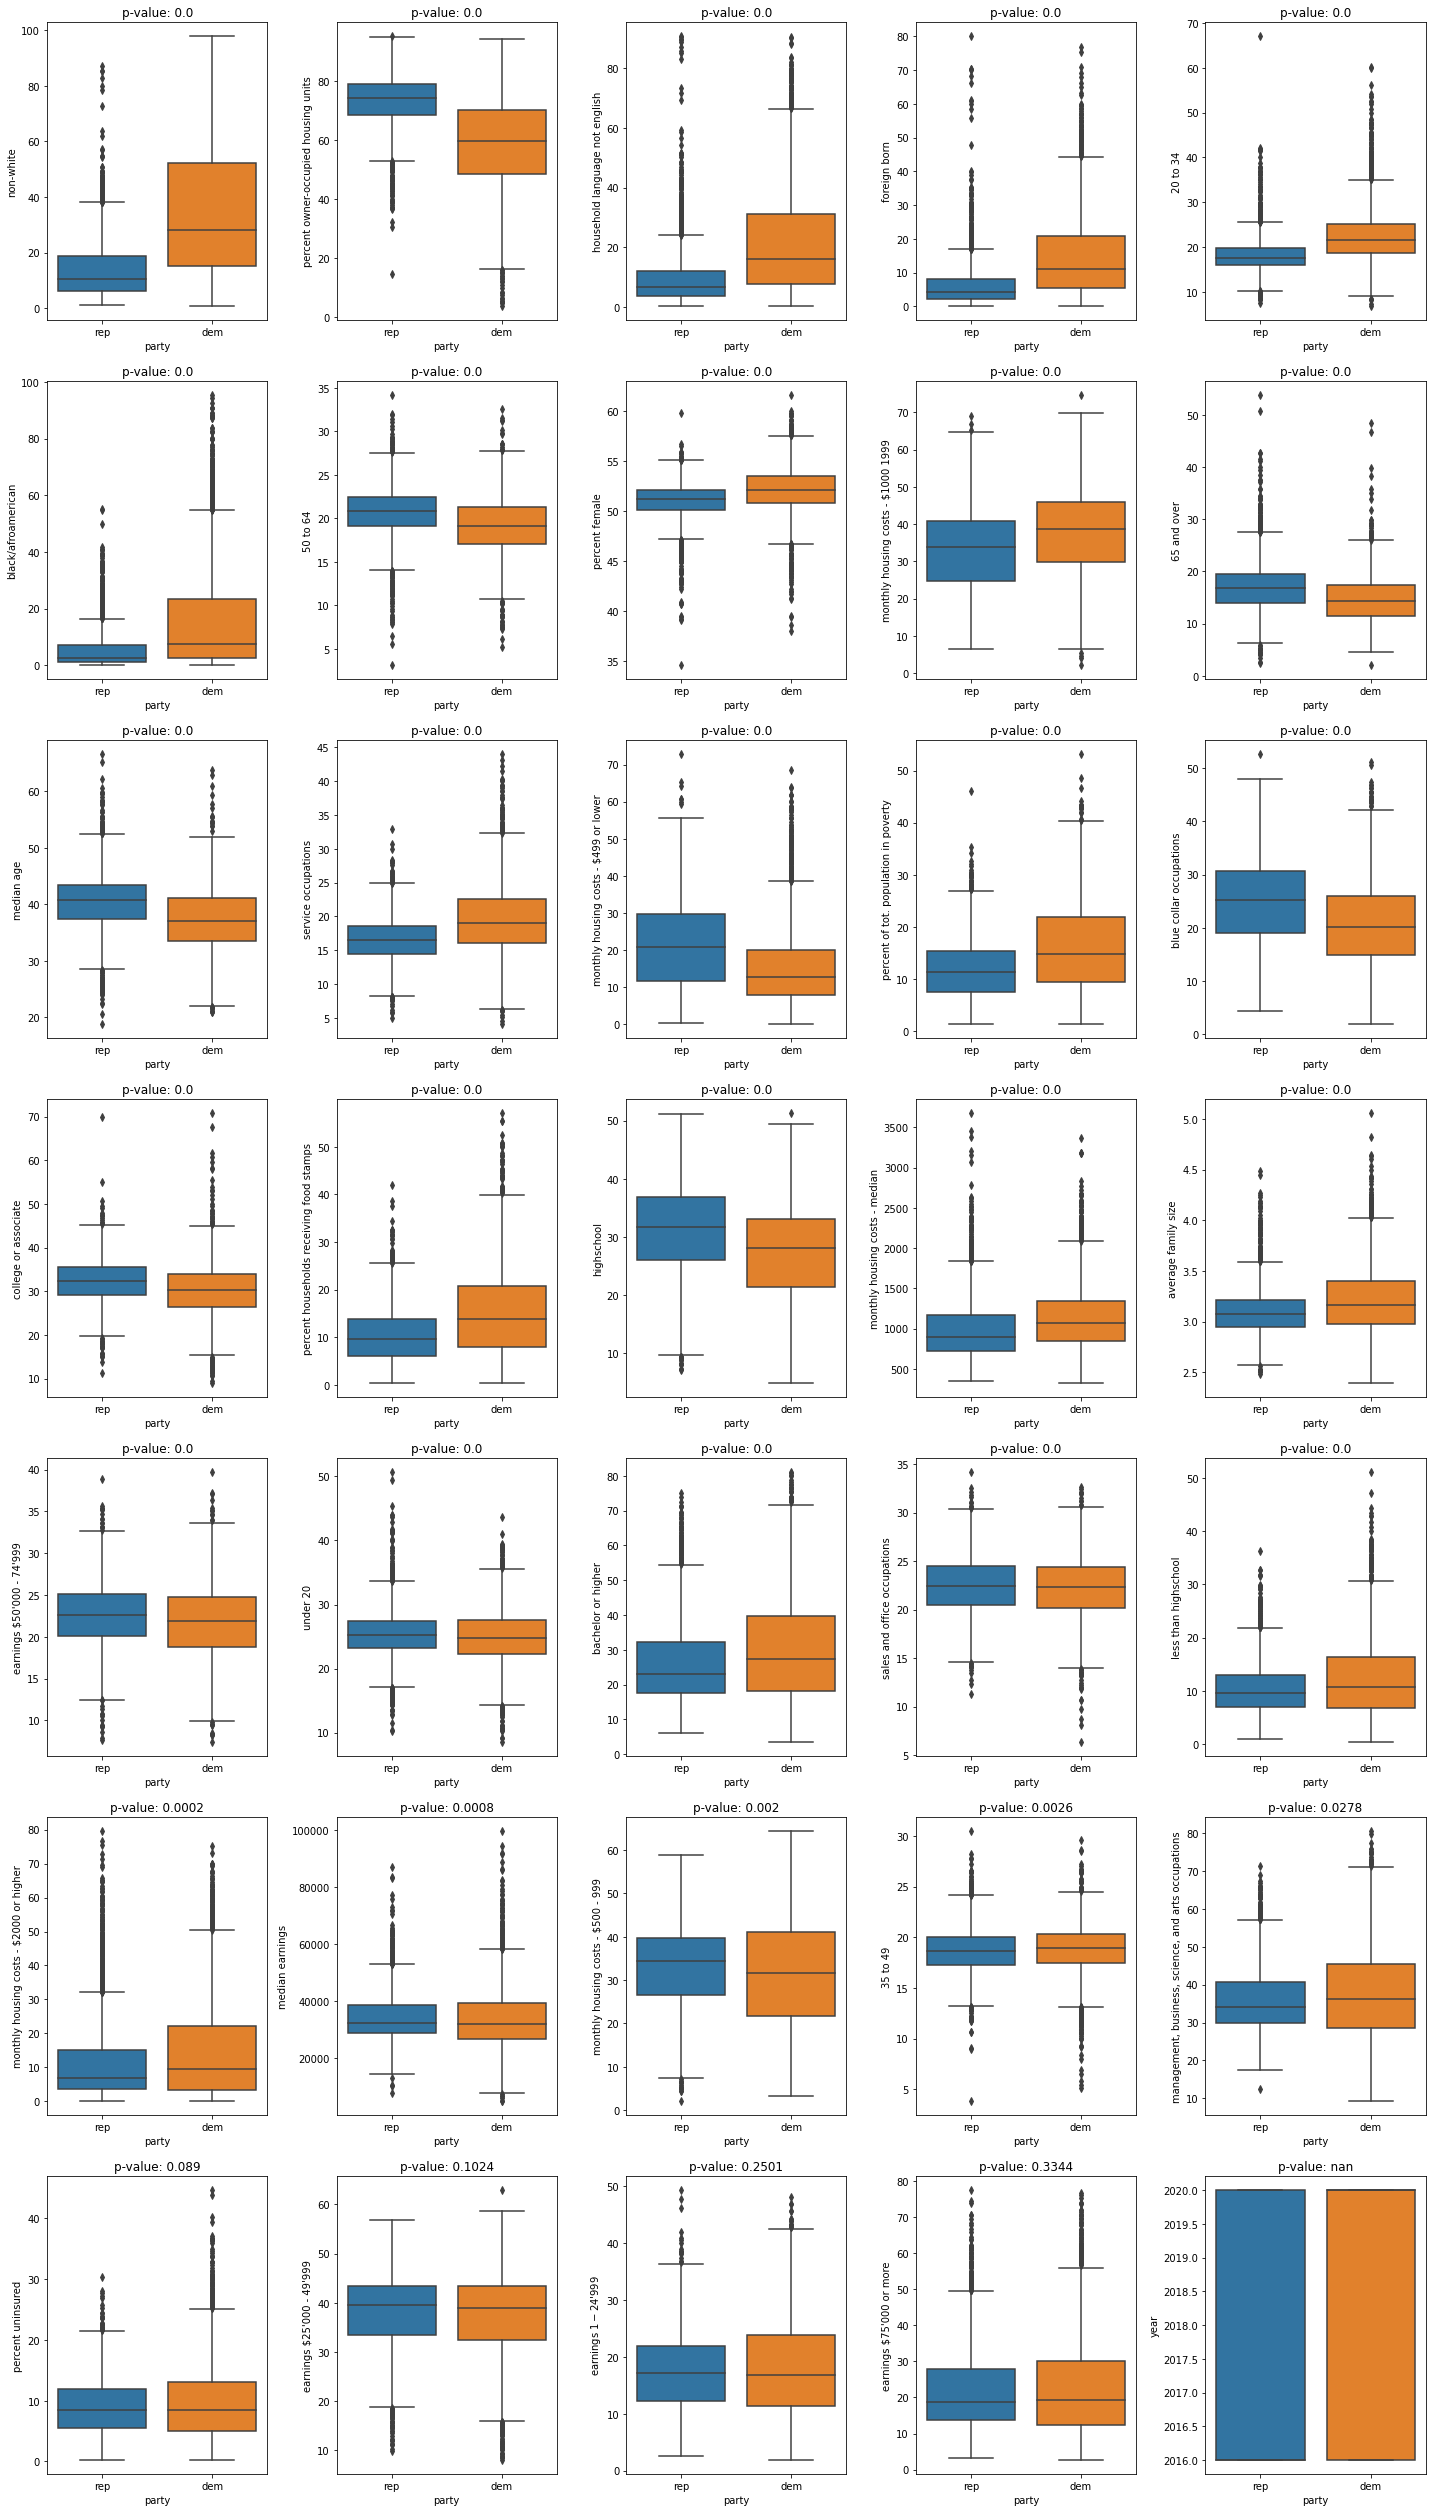

In [ ]:
feature_pvalues = pval_auc(train)

### Multivariate Exploration

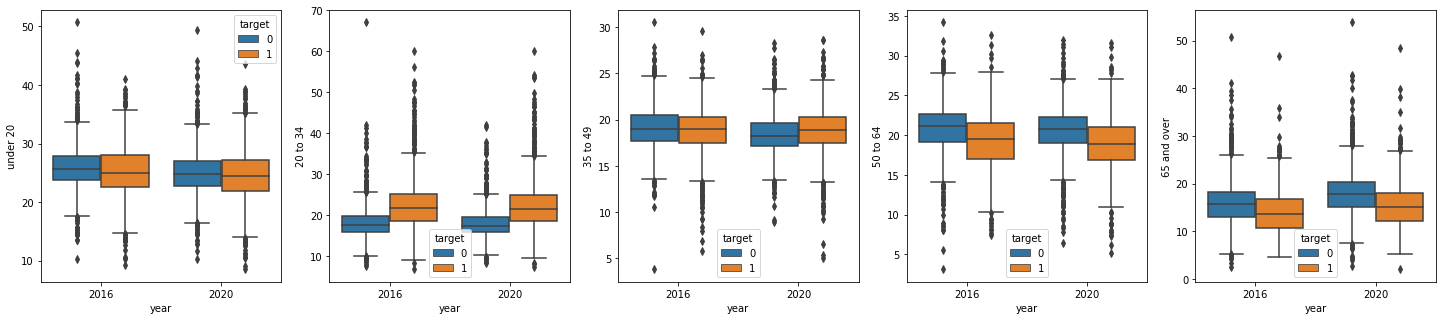

In [ ]:
# Age cohorts
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
sns.boxplot(x="year", y="under 20", hue="target", data=train, ax=ax[0])
sns.boxplot(x="year", y="20 to 34", hue="target", data=train, ax=ax[1])
sns.boxplot(x="year", y="35 to 49", hue="target", data=train, ax=ax[2])
sns.boxplot(x="year", y="50 to 64", hue="target", data=train, ax=ax[3])
sns.boxplot(x="year", y="65 and over", hue="target", data=train, ax=ax[4])

The higher the share of older people in a district the more likely a republican got elected. While especially districts with a higher percentage of 20 to 34 year old seem to have voted more often for democrats.

(0.0, 100.0)

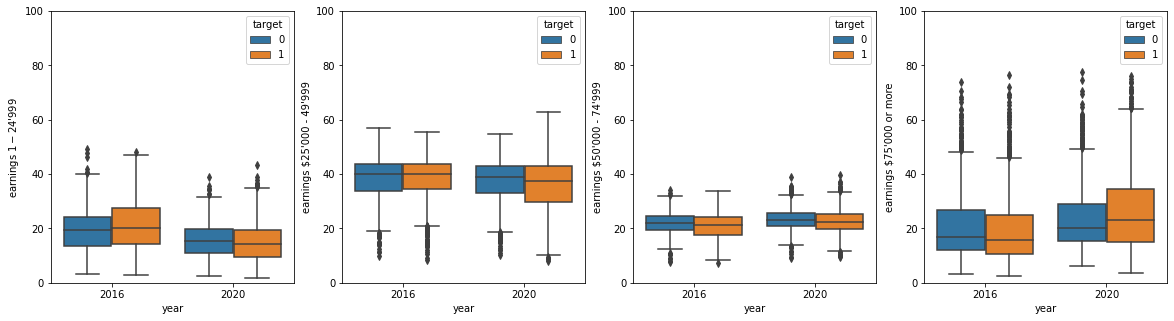

In [ ]:
# Earning cohorts
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.boxplot(x="year", y="earnings $1 - $24'999", hue="target", data=train, ax=ax[0])
ax[0].set_ylim([0, 100])
sns.boxplot(x="year", y="earnings $25'000 - 49'999", hue="target", data=train, ax=ax[1])
ax[1].set_ylim([0, 100])
sns.boxplot(x="year", y="earnings $50'000 - 74'999", hue="target", data=train, ax=ax[2])
ax[2].set_ylim([0, 100])
sns.boxplot(x="year", y="earnings $75'000 or more", hue="target", data=train, ax=ax[3])
ax[3].set_ylim([0, 100])

Very identical distributions in earning cohorts for both electorates over both years.

(0.0, 100.0)

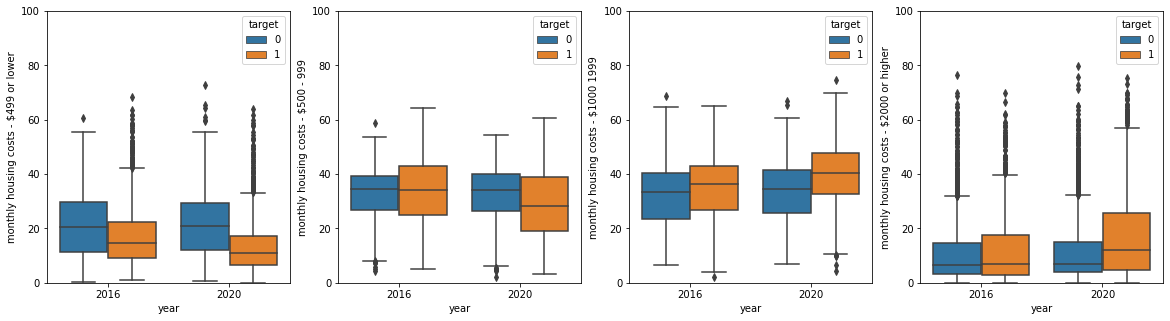

In [ ]:
# Monthly Housing Costs
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.boxplot(x="year", y="monthly housing costs - $499 or lower", hue="target", data=train, ax=ax[0])
ax[0].set_ylim([0, 100])
sns.boxplot(x="year", y="monthly housing costs - $500 - 999", hue="target", data=train, ax=ax[1])
ax[1].set_ylim([0, 100])
sns.boxplot(x="year", y="monthly housing costs - $1000 1999", hue="target", data=train, ax=ax[2])
ax[2].set_ylim([0, 100])
sns.boxplot(x="year", y="monthly housing costs - $2000 or higher", hue="target", data=train, ax=ax[3])
ax[3].set_ylim([0, 100])

Especially in 2020: The more low price homes in a district, the more often a republican got elected. <br>
Whereas with more high prices homes, the chances of a democrat were higher. 

(0.0, 100.0)

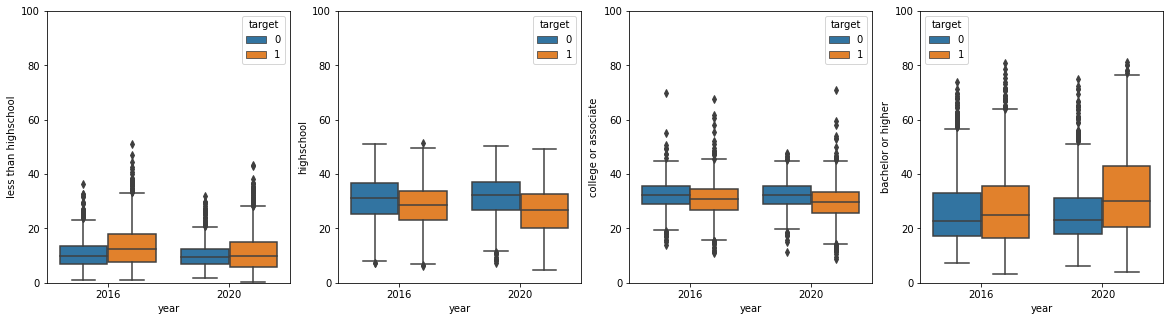

In [ ]:
# Educational Attainment
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.boxplot(x="year", y="less than highschool", hue="target", data=train, ax=ax[0])
ax[0].set_ylim([0, 100])
sns.boxplot(x="year", y="highschool", hue="target", data=train, ax=ax[1])
ax[1].set_ylim([0, 100])
sns.boxplot(x="year", y="college or associate", hue="target", data=train, ax=ax[2])
ax[2].set_ylim([0, 100])
sns.boxplot(x="year", y="bachelor or higher", hue="target", data=train, ax=ax[3])
ax[3].set_ylim([0, 100])

These plots show a classic middle-class voting behaviour for the Republicans: 
* The higher the percentage of people in a district with max. highschool or college degree, the higher the chances for an elected republican candidate.
* More uneducated and highly educated people in a district: Higher probability for democrat candidate.

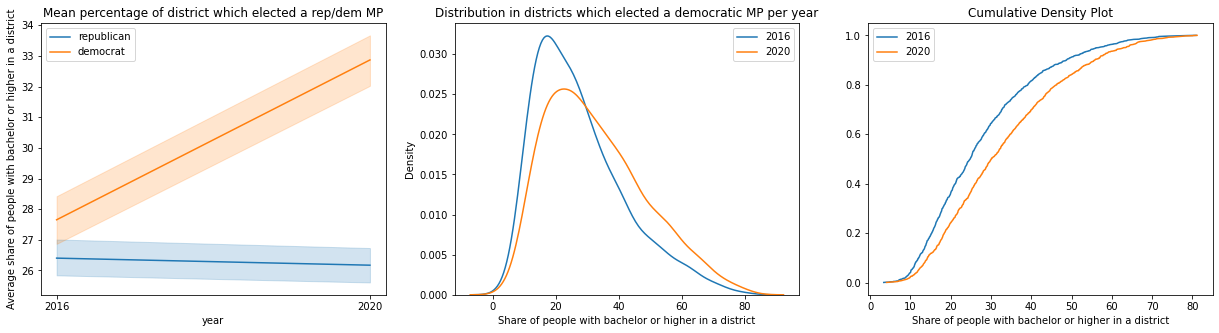

In [ ]:
fig, [ax0, ax1, ax2] = plt.subplots(1, 3, figsize=(21, 5))
sns.lineplot(x="year", y="bachelor or higher", hue="target", data=train[train.target], ax=ax0)
ax0.set_title("Mean percentage of district which elected a rep/dem MP")
ax0.set_xticks([2016, 2020])
ax0.set_ylabel("Average share of people with bachelor or higher in a district")
ax0.legend(["republican", "democrat"])

sns.kdeplot(train[(train.target==1) & (train.year == 2016)]["bachelor or higher"], ax=ax1)
sns.kdeplot(train[(train.target==1) & (train.year == 2020)]["bachelor or higher"], ax=ax1)
ax1.legend(["2016", "2020"])
ax1.set_title("Distribution in districts which elected a democratic MP per year")
ax1.set_xlabel("Share of people with bachelor or higher in a district")

Cdf.from_seq(train[(train.target==1) & (train.year == 2016)]["bachelor or higher"]).plot(ax=ax2)
Cdf.from_seq(train[(train.target==1) & (train.year == 2020)]["bachelor or higher"]).plot(ax=ax2)
ax2.set_title("Cumulative Density Plot")
ax2.set_xlabel("Share of people with bachelor or higher in a district")
ax2.legend(["2016", "2020"]);

This plots show that districts, which elected democratic candidates, had a higher share of people with a bachelor degree or higher. This intensified in the 2020 elections.

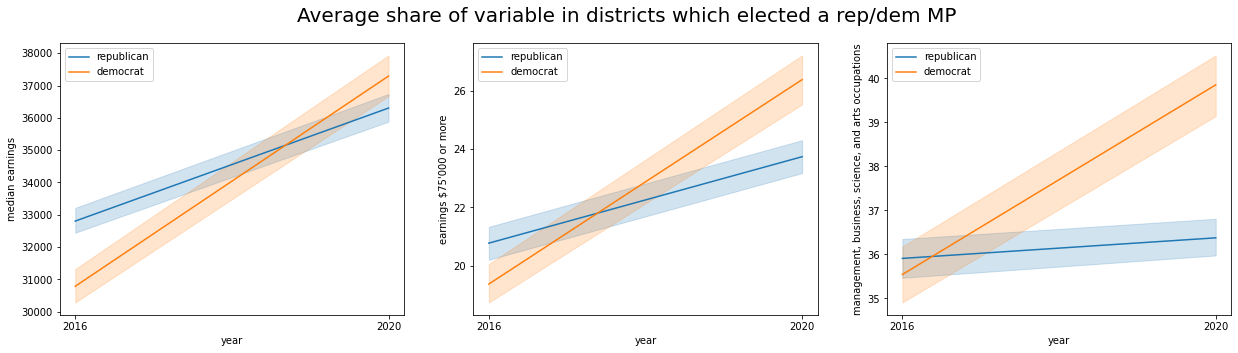

In [ ]:
fig, [ax0, ax1, ax2] = plt.subplots(nrows=1,
                       ncols=3,
                       figsize=(21, 5))
plt.suptitle("Average share of variable in districts which elected a rep/dem MP", size=20)
sns.lineplot(x="year", y="median earnings", hue="target", data=train[train.target], ax=ax0)
ax0.set_xticks([2016, 2020])
ax0.legend(["republican", "democrat"])
ax0.legend(["republican", "democrat"])
sns.lineplot(x="year", y="earnings $75'000 or more", hue="target", data=train[train.target], ax=ax1)
ax1.set_xticks([2016, 2020])
ax1.legend(["republican", "democrat"])
sns.lineplot(x="year", y="management, business, science, and arts occupations", hue="target", data=train[train.target!=2], ax=ax2)
ax2.set_xticks([2016, 2020])
ax2.legend(["republican", "democrat"], loc="upper left");

This trend is also visible in variables like median earnings, earnings of $75'000 or higher or occupations of management, business, science and arts. We can therefore conclude that in 2020 democrats tend to have been elected more often in higher educated and wealthier districts than in 2016.

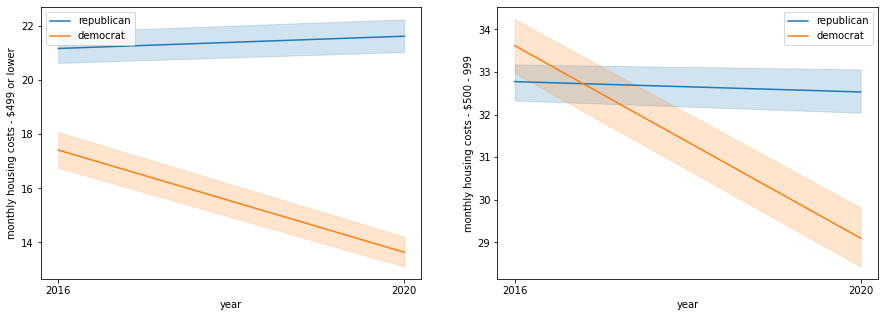

In [ ]:
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(x="year", y="monthly housing costs - $499 or lower", hue="target", data=train, ax=ax0)
ax0.set_xticks([2016, 2020])
ax0.legend(["republican", "democrat"])
sns.lineplot(x="year", y="monthly housing costs - $500 - 999", hue="target", data=train, ax=ax1)
ax1.set_xticks([2016, 2020])
ax1.legend(["republican", "democrat"]);

In these plots we can see the average percentage of people with monthly housing costs (499 or lower and 500-999) in districts which voted for republicans or democrats. In both cases the percentage drops for democrats in 2020 and stays the same for districts which voted for republicans.  

There are two possible explanations for the development in these two variables: 
* Firstly, districts with higher educated and wealthier people could have voted for the democrats in 2020 more often.
* Secondly, districts where democrats got elected became wealthier over those 4 years. However, the latter would be a massive increase in earnings as well as education, which makes it a nearly impossible explanation.

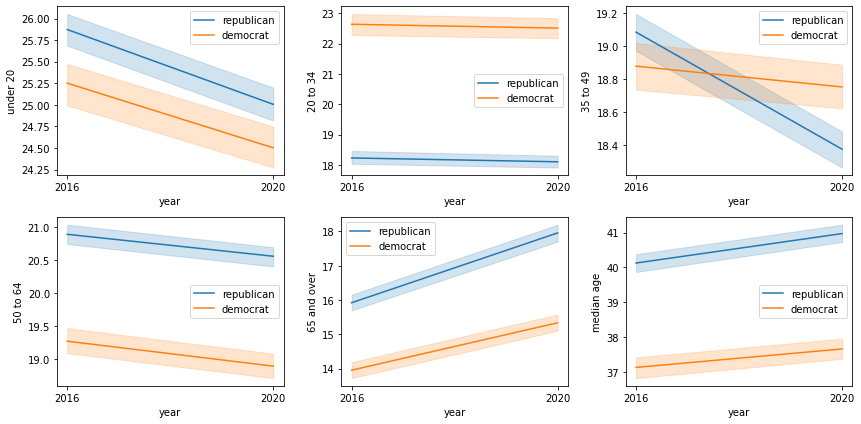

In [169]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
age_cols = ["under 20", "20 to 34", "35 to 49", "50 to 64", "65 and over", "median age"]
for num, (ax, col) in enumerate(zip(axes.flatten(), age_cols)):
  sns.lineplot(x="year", y=col, hue="target", data=train, ax=ax)
  ax.set_xticks([2016, 2020])
  ax.legend(["republican", "democrat"])
plt.tight_layout()

In the age variables we can see another interesting trend. Although the trend between 2016 and 2020 is negative for all the cohorts except the "65 and over" the median age for both parties seems to have risen.

Possible explanations: 
* Maybe it's because of the splitting, i.e. lots of the "younger districts" from 2020 are in the test set.
* Population got older as a whole.

Furthermore, districts which elected a republican candidate to the State House of Representatives tended to have a higher share of older age cohorts.

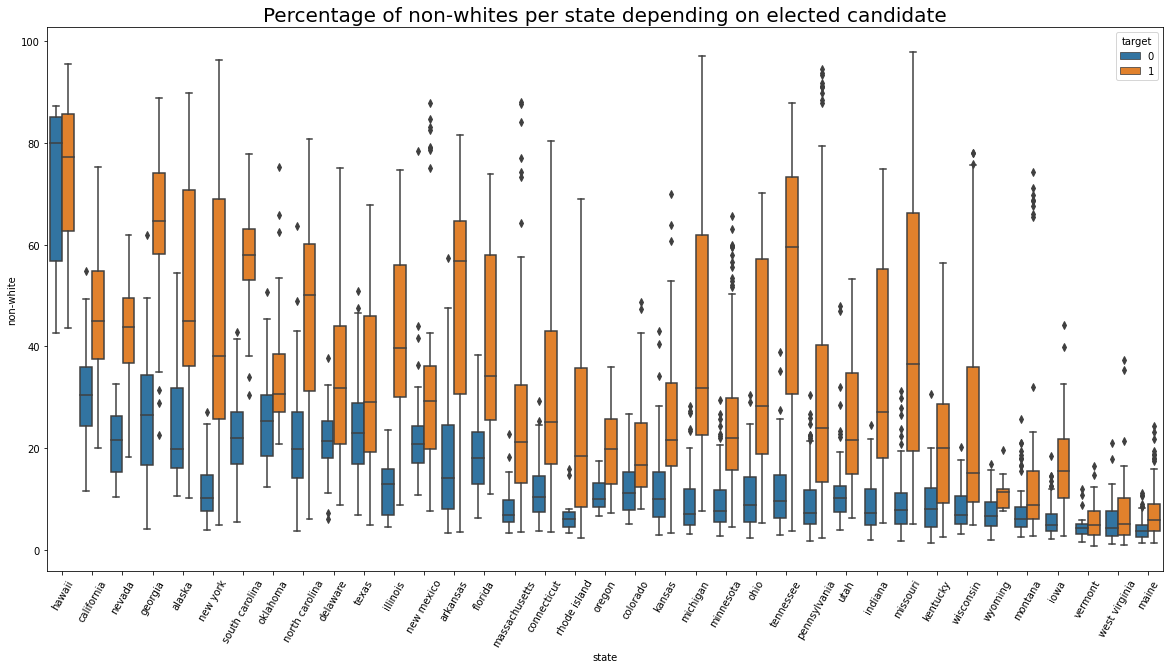

In [ ]:
# Percentage of Foreign Borns per state
order_median_fb = train.groupby("state")["non-white"].median().sort_values(ascending=False).index
plt.figure(figsize=(20, 10))
sns.boxplot(x="state", y="non-white", hue="target", data=train, order=order_median_fb)
plt.title("Percentage of non-whites per state depending on elected candidate", fontdict={"fontsize": 20})
plt.xticks(rotation=60);

Districts with a higher share of foreign borns tend to more often vote for democrats. Same is also visible for share of non-white per district.

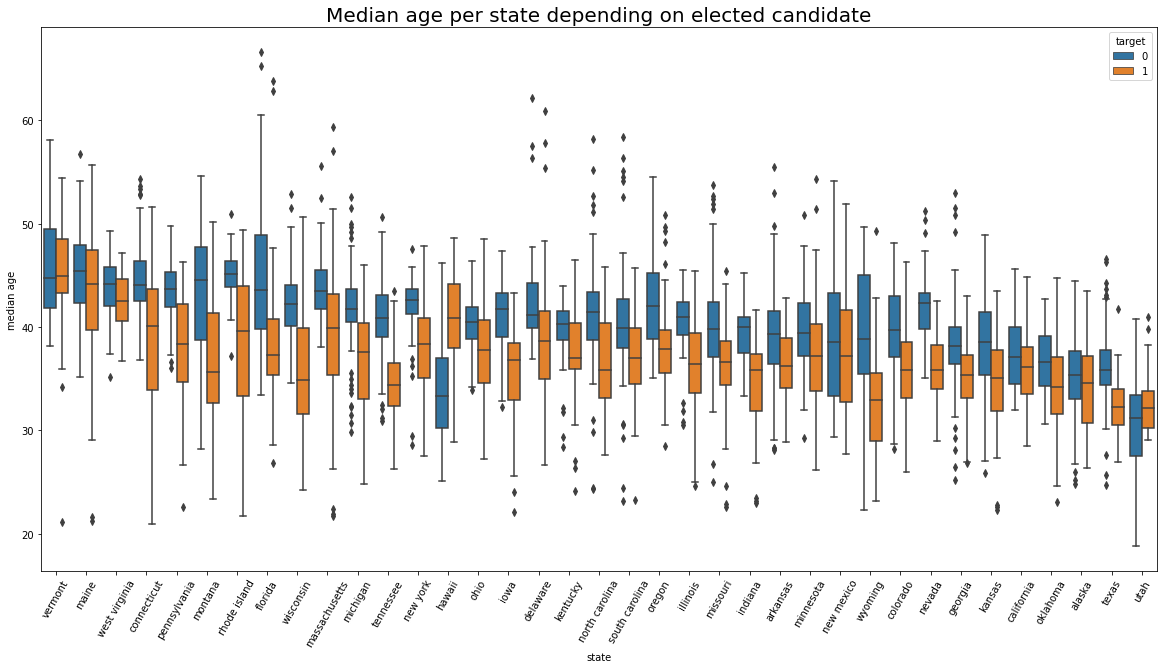

In [ ]:
order_median_nw = train.groupby("state")["median age"].median().sort_values(ascending=False).index
plt.figure(figsize=(20, 10))
sns.boxplot(x="state", y="median age", hue="target", data=train, order=order_median_nw)
plt.title("Median age per state depending on elected candidate", fontdict={"fontsize": 20})
plt.xticks(rotation=60);

This graph confirms that in almost all states the average median age per state is higher for district which elected a republican member.

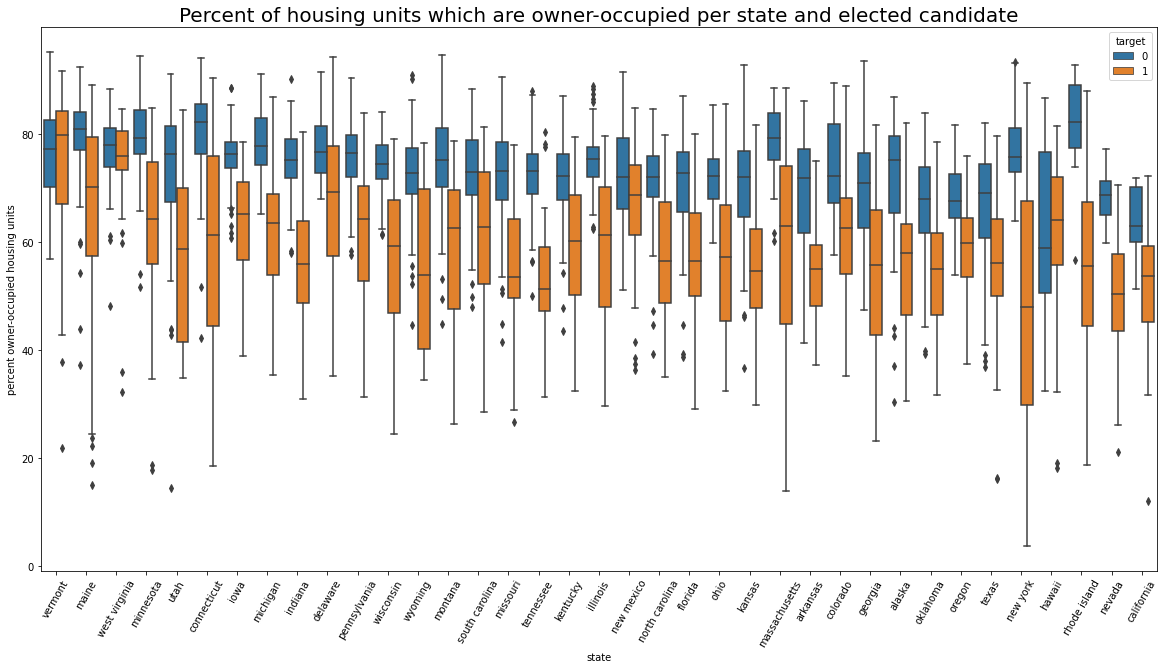

In [ ]:
order_median_nw = train.groupby("state")["percent owner-occupied housing units"].median().sort_values(ascending=False).index
plt.figure(figsize=(20, 10))
sns.boxplot(x="state", y="percent owner-occupied housing units", hue="target", data=train, order=order_median_nw)
plt.title("Percent of housing units which are owner-occupied per state and elected candidate", fontdict={"fontsize": 20})
plt.xticks(rotation=60);

Discricts with high share of owner-occupied housing units tend to more often elect republican candidates.

# Baseline Models

Preparations:
* impute missing values
* encode categoricals

In [18]:
# Impute missing values
df_train = train.copy()
df_train["monthly housing costs - median"] = df_train["monthly housing costs - median"].fillna(df_train["monthly housing costs - median"].median())

In [19]:
# Categorical encoding
from pandas.core.dtypes.dtypes import CategoricalDtype
df_train["district"] = df_train["district"].astype("category").cat.codes
df_train["state"] = df_train["state"].astype("category").cat.codes

In [20]:
X = df_train.drop("target", axis=1)
y = df_train.target

In [ ]:
def get_baselines(X, y, list_of_models):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=22)
  results = pd.DataFrame()
  preds_total, probas = {}, {}
  for num, model in enumerate(list_of_models):
    print(model)
    results.loc[num, "feature"] = str(model)

    if type(model) in [type(LogisticRegression()), type(KNeighborsClassifier()), type(SVC())]:
      model = Pipeline(steps=[("standardizer", StandardScaler()), ("model", model)])
    
    # Cross validation scores
    scores = cross_val_score(model, 
                             X,
                             y,
                             cv=cv,
                             scoring="accuracy", 
                             n_jobs=-1)
    results.loc[num, "mean"] = np.mean(scores)
    results.loc[num, "std"] = np.std(scores)
    results.loc[num, [f"fold_{i}" for i in range(cv.get_n_splits())]] = scores
    
    # Cross validation predictions
    preds_proba = cross_val_predict(model,
                                    X,
                                    y,
                                    cv=10,
                                    method="predict_proba",
                                    n_jobs=-1)
    preds = np.argmax(preds_proba, axis=1).tolist()

    if isinstance(model, Pipeline):
      model = model.named_steps["model"]
    probas[str(model)] = preds_proba
    preds_total[str(model)] = preds
  return results, preds_total, probas

In [ ]:
list_of_models = [LogisticRegression(), KNeighborsClassifier(), SVC(probability=True), RandomForestClassifier(), 
                  XGBClassifier(), LGBMClassifier(), HistGradientBoostingClassifier(), 
                  CatBoostClassifier()]

In [ ]:
%%time
baseline_results, baseline_preds, baseline_probas = get_baselines(X, y, list_of_models)

LogisticRegression()
KNeighborsClassifier()
SVC(probability=True)
RandomForestClassifier()
XGBClassifier()
LGBMClassifier()
HistGradientBoostingClassifier()
CPU times: user 6.86 s, sys: 607 ms, total: 7.46 s
Wall time: 16min 10s


In [ ]:
baseline_results

feature      mean       std  \
0                               LogisticRegression()  0.837716  0.013750   
1                             KNeighborsClassifier()  0.843305  0.012572   
2                              SVC(probability=True)  0.865723  0.014738   
3                           RandomForestClassifier()  0.858484  0.012907   
4                                    XGBClassifier()  0.852541  0.014419   
5                                   LGBMClassifier()  0.869840  0.012269   
6                   HistGradientBoostingClassifier()  0.870723  0.014606   
7  <catboost.core.CatBoostClassifier object at 0x...  0.871724  0.012902   

     fold_0    fold_1    fold_2    fold_3    fold_4    fold_5    fold_6  \
0  0.851852  0.827160  0.834215  0.835979  0.818342  0.835689  0.823322   
1  0.827160  0.839506  0.867725  0.825397  0.832451  0.853357  0.833922   
2  0.867725  0.862434  0.874780  0.844797  0.858907  0.881625  0.842756   
3  0.848325  0.864198  0.880071  0.850088  0.858907  0.872792  0.837456   
4  0.853616  0.851852  0.851852  0.839506  0.862434  0.858657  0.832155   
5  0.865961  0.867725  0.867725  0.865961  0.873016  0.874558  0.851590   
6  0.876543  0.864198  0.867725  0.874780  0.865961  0.871025  0.863958   
7  0.873016  0.873016  0.874780  0.858907  0.865961  0.876325  0.853357   

     fold_7    fold_8    fold_9   fold_10   fold_11   fold_12   fold_13  \
0  0.853357  0.848057  0.846290  0.837743  0.828924  0.858907  0.827160   
1  0.835689  0.844523  0.856890  0.853616  0.844797  0.850088  0.837743   
2  0.881625  0.874558  0.867491  0.860670  0.858907  0.871252  0.862434   
3  0.862191  0.863958  0.849823  0.862434  0.853616  0.871252  0.860670   
4  0.862191  0.855124  0.860424  0.864198  0.844797  0.873016  0.839506   
5  0.890459  0.867491  0.871025  0.867725  0.869489  0.895944  0.880071   
6  0.893993  0.869258  0.851590  0.869489  0.858907  0.883598  0.874780   
7  0.886926  0.865724  0.860424  0.873016  0.858907  0.887125  0.880071   

    fold_14   fold_15   fold_16   fold_17   fold_18   fold_19   fold_20  \
0  0.851852  0.855124  0.818021  0.840989  0.823322  0.830389  0.860670   
1  0.865961  0.830389  0.835689  0.849823  0.837456  0.814488  0.843034   
2  0.899471  0.872792  0.849823  0.878092  0.849823  0.842756  0.881834   
3  0.871252  0.869258  0.848057  0.865724  0.842756  0.839223  0.881834   
4  0.874780  0.860424  0.842756  0.863958  0.816254  0.842756  0.876543   
5  0.887125  0.874558  0.867491  0.869258  0.848057  0.848057  0.892416   
6  0.910053  0.865724  0.871025  0.883392  0.860424  0.840989  0.899471   
7  0.899471  0.883392  0.863958  0.879859  0.856890  0.849823  0.899471   

    fold_21   fold_22   fold_23   fold_24   fold_25   fold_26   fold_27  \
0  0.843034  0.837743  0.827160  0.846561  0.837456  0.832155  0.803887   
1  0.850088  0.825397  0.860670  0.853616  0.844523  0.844523  0.839223   
2  0.874780  0.862434  0.881834  0.865961  0.881625  0.860424  0.830389   
3  0.876543  0.851852  0.858907  0.857143  0.867491  0.856890  0.828622   
4  0.864198  0.835979  0.857143  0.857143  0.856890  0.863958  0.837456   
5  0.874780  0.860670  0.880071  0.874780  0.863958  0.871025  0.851590   
6  0.873016  0.853616  0.878307  0.869489  0.885159  0.865724  0.851590   
7  0.876543  0.869489  0.871252  0.869489  0.885159  0.881625  0.851590   

    fold_28   fold_29  
0  0.833922  0.862191  
1  0.839223  0.862191  
2  0.855124  0.874558  
3  0.839223  0.863958  
4  0.821555  0.855124  
5  0.848057  0.874558  
6  0.849823  0.878092  
7  0.853357  0.872792

In [ ]:
baseline_results.to_csv("drive/MyDrive/US Elections/Notebook Data/baseline_results.csv", index=False)

In [21]:
baseline_results = pd.read_csv("drive/MyDrive/US Elections/Notebook Data/baseline_results.csv")

In [ ]:
with open('drive/MyDrive/US Elections/Notebook Data/baseline_preds.pickle', 'wb') as baseline_preds_:
    pickle.dump(baseline_preds, baseline_preds_)
with open('drive/MyDrive/US Elections/Notebook Data/baseline_probas.pickle', 'wb') as baseline_probas_:
    pickle.dump(baseline_probas, baseline_probas_)

In [22]:
with open('drive/MyDrive/US Elections/Notebook Data/baseline_preds.pickle', 'rb') as baseline_preds_:
    baseline_preds = pickle.load(baseline_preds_)

with open('drive/MyDrive/US Elections/Notebook Data/baseline_probas.pickle', 'rb') as baseline_probas_:
    baseline_probas = pickle.load(baseline_probas_)

In [ ]:
from sklearn.metrics import classification_report

for model, preds in baseline_preds.items():
  print(model)
  print(classification_report(y, preds))
  print()
  print()

LogisticRegression()
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      3071
           1       0.85      0.78      0.81      2594

    accuracy                           0.84      5665
   macro avg       0.84      0.83      0.83      5665
weighted avg       0.84      0.84      0.84      5665



KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.82      0.92      0.86      3071
           1       0.88      0.76      0.82      2594

    accuracy                           0.84      5665
   macro avg       0.85      0.84      0.84      5665
weighted avg       0.85      0.84      0.84      5665



SVC(probability=True)
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3071
           1       0.87      0.82      0.85      2594

    accuracy                           0.86      5665
   macro avg       0.87      0.86      0.86      5665
weig

For all models recall is higher than precision for the republicans and the opposite, precision is higher than recall, for the democrats. 

This actually makes totally sense as there are slightly more instances of republicans in the training set and the model tends to predict classes with more instances more often. Therefore the recall is higher than precision for republicans and lower for democrats.

# Model Evaluation

The goal of this part is to evaluate the models. Look at different visualizations and eventually look at what errors they made in particular.

## Confusion Matrix, ROC Curve, Precision-Recall Curve

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, dict_of_preds):
  # Create figure and subplots
  fig, ax = plt.subplots(8, 4, figsize=(20, 40))
  plt.suptitle("Confusion Matrices")
  # Loop over all predictions
  for num, (model, preds) in enumerate(dict_of_preds.items()):
    if num == 6:
      model = "HistGradBoostClf()"
    elif num == 7:
      model = "CatBoostClassifier()"
    ConfusionMatrixDisplay.from_predictions(y_true, preds, ax=ax[num, 0], colorbar=False)
    ax[num, 0].set_title(f"{str(model)} normal")

    ConfusionMatrixDisplay.from_predictions(y_true, preds, normalize="pred", ax=ax[num, 1], colorbar=False)
    ax[num, 1].set_title(f"{str(model)} normalized predicted")

    ConfusionMatrixDisplay.from_predictions(y_true, preds, normalize="true", ax=ax[num, 2], colorbar=False)
    ax[num, 2].set_title(f"{str(model)} normalized true")

    ConfusionMatrixDisplay.from_predictions(y_true, preds, normalize="all", ax=ax[num, 3], colorbar=False)
    ax[num, 3].set_title(f"{str(model)} normalized all")
  plt.tight_layout()
  plt.show();

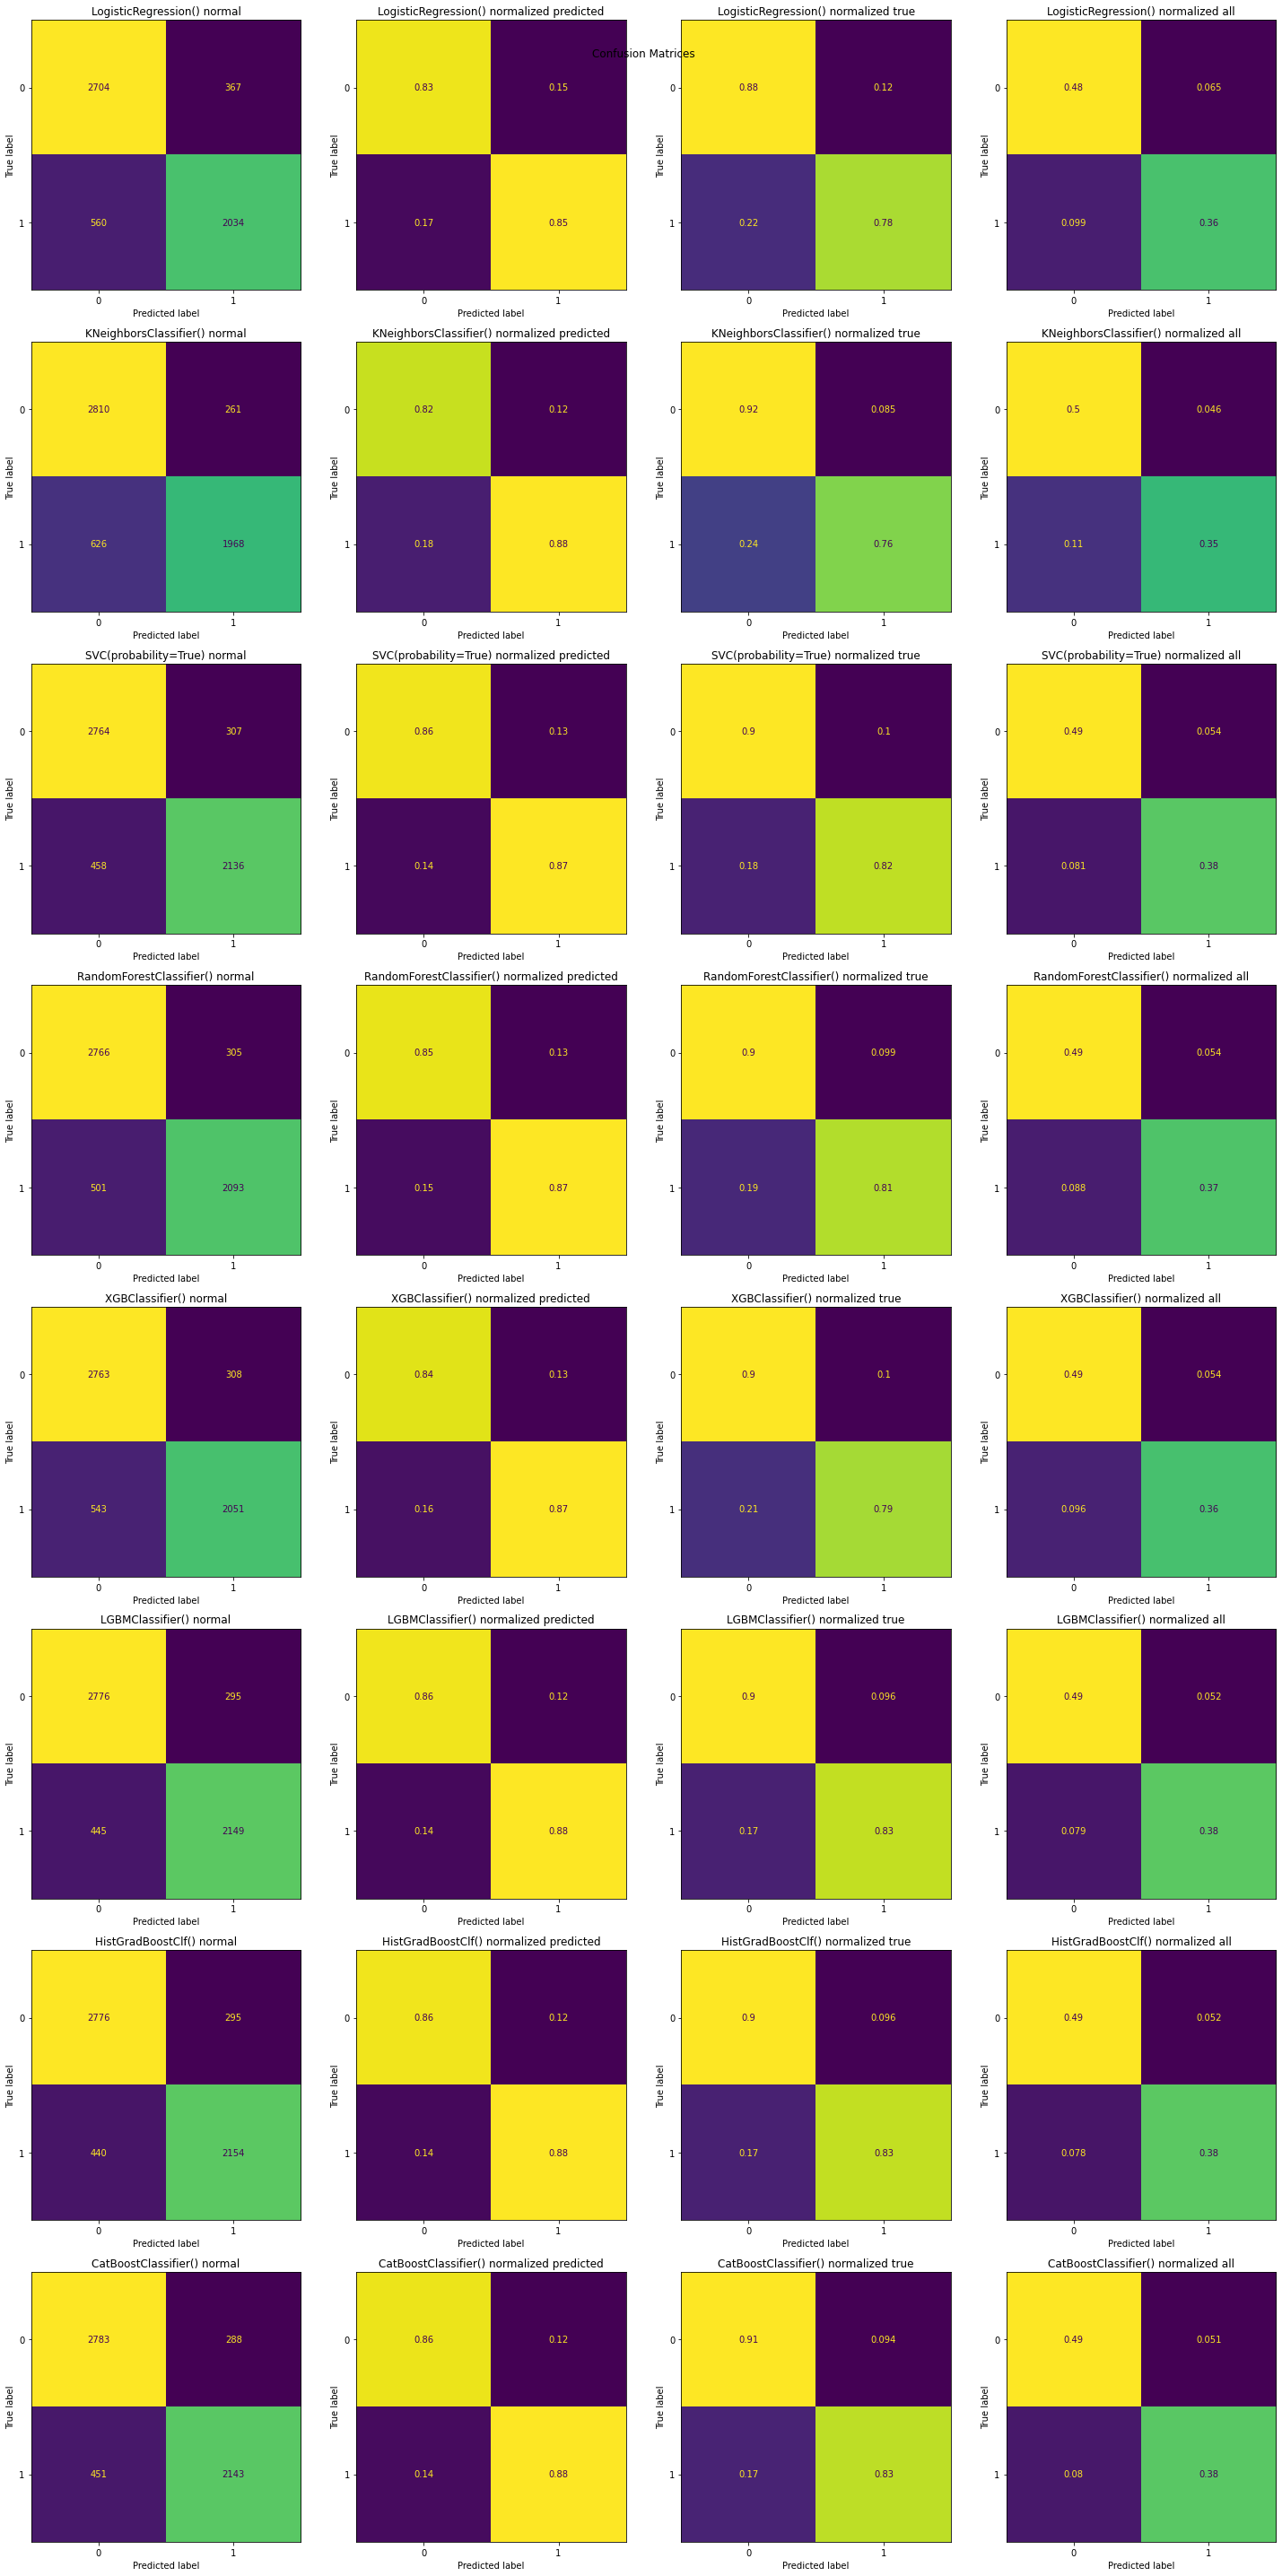

In [33]:
plot_confusion_matrix(y, baseline_preds)

* The confusion matrices in the ***first column*** show the absolute number of predictions for all the models.
* The ***second column*** shows the matrices normalized by the label predicted. For democratic predictions the success rate was higher than for republicans. As the target variable counts more republican entries than democratic the models tend to predict republican more often.
* The ***third column*** shows the matrices normalized by the label true. Here the plots show that democratic districts are approx. twice as much wrongly classified as republican districts (~9-10% vs. ~17-20%). This means our model is worse in predicting democratic districts than predicting republican districts.
* The ***fourth column*** shows the matrices normalized over all instances. There are approx. 5% false positives, i.e. predicted as democrats, but actual republicans, and approx. 8% false negatives, i.e. predicted republicans, but actual democrats.

In [ ]:
from sklearn.metrics import RocCurveDisplay

def plot_roc_curves(y_true, dict_of_probas):
  # Create figure and subplots
  fig, axes = plt.subplots(3, 3, figsize=(21, 15))
  for ax, (model, probas) in zip(axes.flatten(), dict_of_probas.items()):
    RocCurveDisplay.from_predictions(y, pd.Series(probas[:, 1]), ax=ax)
    plt.title(model)
  plt.tight_layout()
  plt.show();

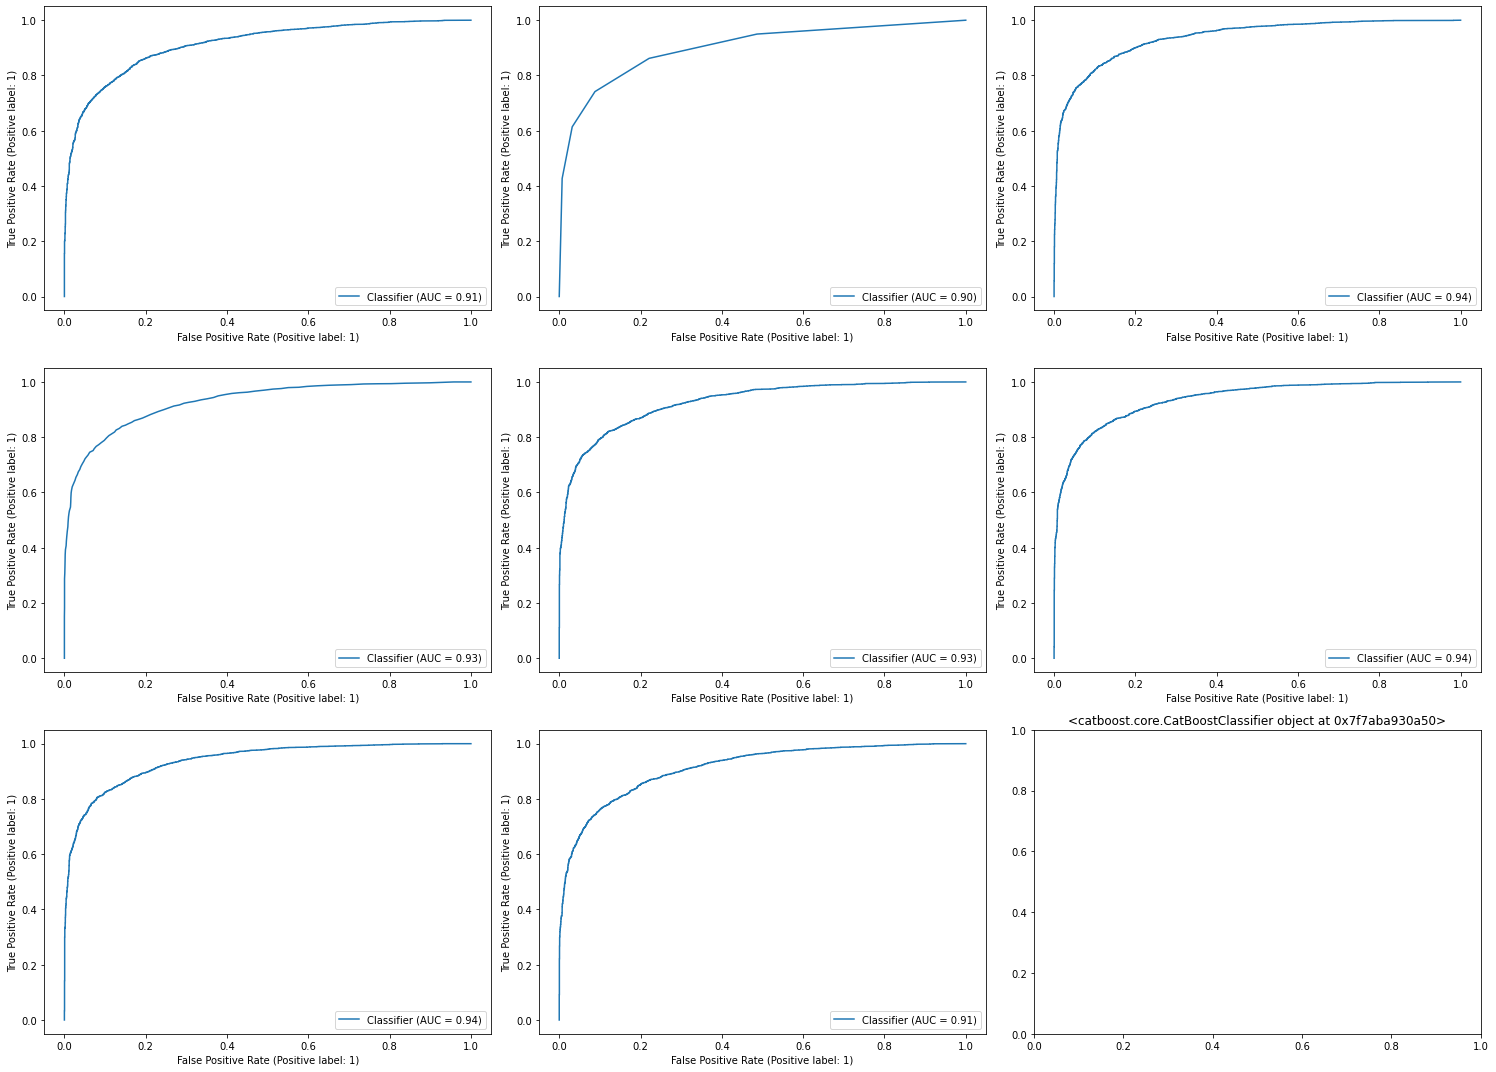

In [ ]:
plot_roc_curves(y, baseline_probas)

We can see that all the models have very similar ROC and precision-recall curves.

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

def plot_precision_recall_curves(y, dict_of_probas):
  # Create figure and subplots
  fig, axes = plt.subplots(3, 3, figsize=(21, 15))
  for ax, (model, probas) in zip(axes.flatten(), dict_of_probas.items()):
    PrecisionRecallDisplay.from_predictions(y, probas[:, 1], ax=ax)
    plt.title(model)
  plt.tight_layout()
  plt.show();

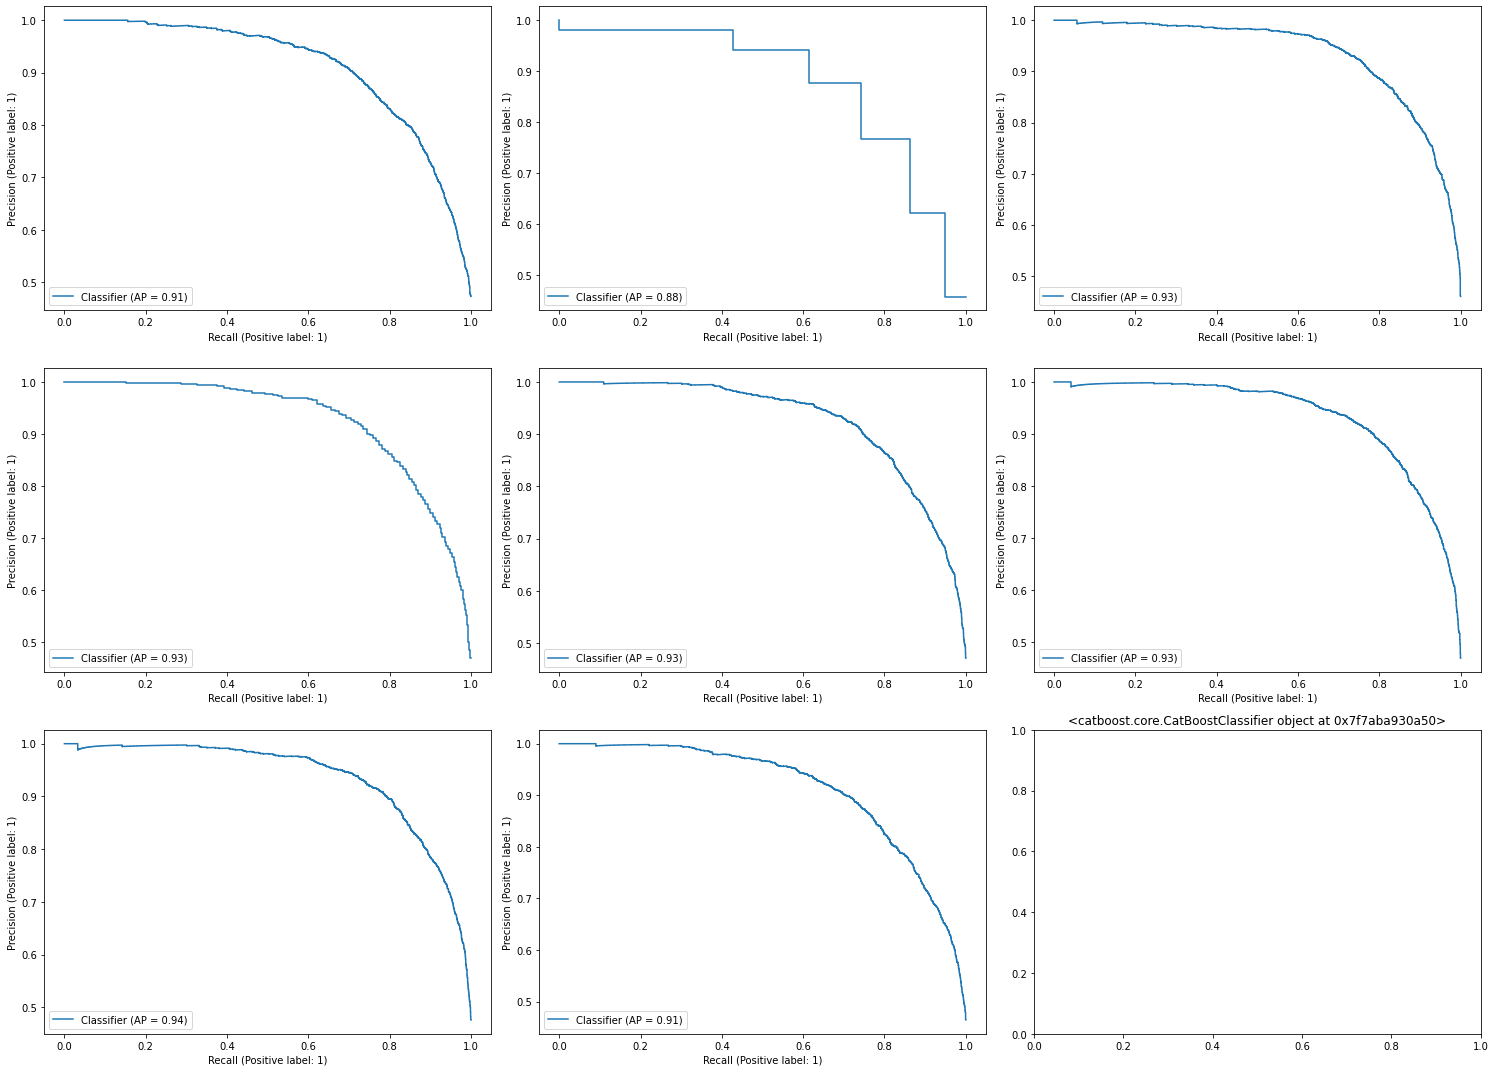

In [ ]:
plot_precision_recall_curves(y, baseline_probas)

In [45]:
from sklearn.model_selection import learning_curve

def plot_learning_curves(X, y, list_of_models, cv=10):
  # Create figure and subplots
  fig, axes = plt.subplots(3, 3, figsize=(21, 15))
  # Loop over all axes and models
  for num, (ax, model) in enumerate(zip(axes.flatten(), list_of_models)):
    # Calculate learning curve losses
    sizes, train_losses, val_losses = learning_curve(model, 
                                                     X, 
                                                     y,
                                                     train_sizes=[15, 50, 200, 700, 1400, 2100, 2800, 3500, 4300, 5098],
                                                     #train_sizes=np.linspace(20, 5098, cv) / 5098, 
                                                     cv=cv,
                                                     scoring="neg_log_loss",
                                                     n_jobs=1,
                                                     verbose=True)
    if num == 7:
      model = "CatBoostClassifier()"
    # Change to positive numbers and take mean
    train_loss = -np.mean(train_losses, axis=1)
    val_loss = -np.mean(val_losses, axis=1)
    # Plot the learning curves
    sns.lineplot(x=sizes, y=train_loss, ax=ax)
    sns.lineplot(x=sizes, y=val_loss, ax=ax)
    ax.set_title(model)
    ax.legend(["train", "validation"])
  plt.tight_layout()
  plt.show();

In [46]:
list_of_models = [LogisticRegression(), KNeighborsClassifier(), SVC(probability=True), RandomForestClassifier(), 
                  XGBClassifier(), LGBMClassifier(), HistGradientBoostingClassifier(), 
                  CatBoostClassifier()]

[learning_curve] Training set sizes: [  15   50  200  700 1400 2100 2800 3500 4300 5098]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[learning_curve] Training set sizes: [  15   50  200  700 1400 2100 2800 3500 4300 5098]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   17.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[learning_curve] Training set sizes: [  15   50  200  700 1400 2100 2800 3500 4300 5098]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[learning_curve] Training set sizes: [  15   50  200  700 1400 2100 2800 3500 4300 5098]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[learning_curve] Training set sizes: [  15   50  200  700 1400 2100 2800 3500 4300 5098]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   40.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[learning_curve] Training set sizes: [  15   50  200  700 1400 2100 2800 3500 4300 5098]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   38.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[learning_curve] Training set sizes: [  15   50  200  700 1400 2100 2800 3500 4300 5098]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   44.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
4:	learn: 0.6568752	total: 42.1ms	remaining: 8.38s
5:	learn: 0.6498882	total: 49.8ms	remaining: 8.25s
6:	learn: 0.6438412	total: 57.8ms	remaining: 8.2s
7:	learn: 0.6372005	total: 65.6ms	remaining: 8.13s
8:	learn: 0.6317192	total: 73.4ms	remaining: 8.08s
9:	learn: 0.6252568	total: 81ms	remaining: 8.02s
10:	learn: 0.6184760	total: 89.1ms	remaining: 8.01s
11:	learn: 0.6118931	total: 96.8ms	remaining: 7.97s
12:	learn: 0.6065131	total: 105ms	remaining: 7.94s
13:	learn: 0.6006245	total: 113ms	remaining: 7.93s
14:	learn: 0.5953524	total: 121ms	remaining: 7.92s
15:	learn: 0.5893808	total: 134ms	remaining: 8.26s
16:	learn: 0.5846644	total: 143ms	remaining: 8.28s
17:	learn: 0.5796372	total: 151ms	remaining: 8.25s
18:	learn: 0.5756512	total: 159ms	remaining: 8.21s
19:	learn: 0.5706371	total: 168ms	remaining: 8.24s
20:	learn: 0.5656238	total: 176ms	remaining: 8.21s
21:	learn: 0.5613382	total: 184ms	remaining: 8.19s
22:	learn: 0.556

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 11.9min finished


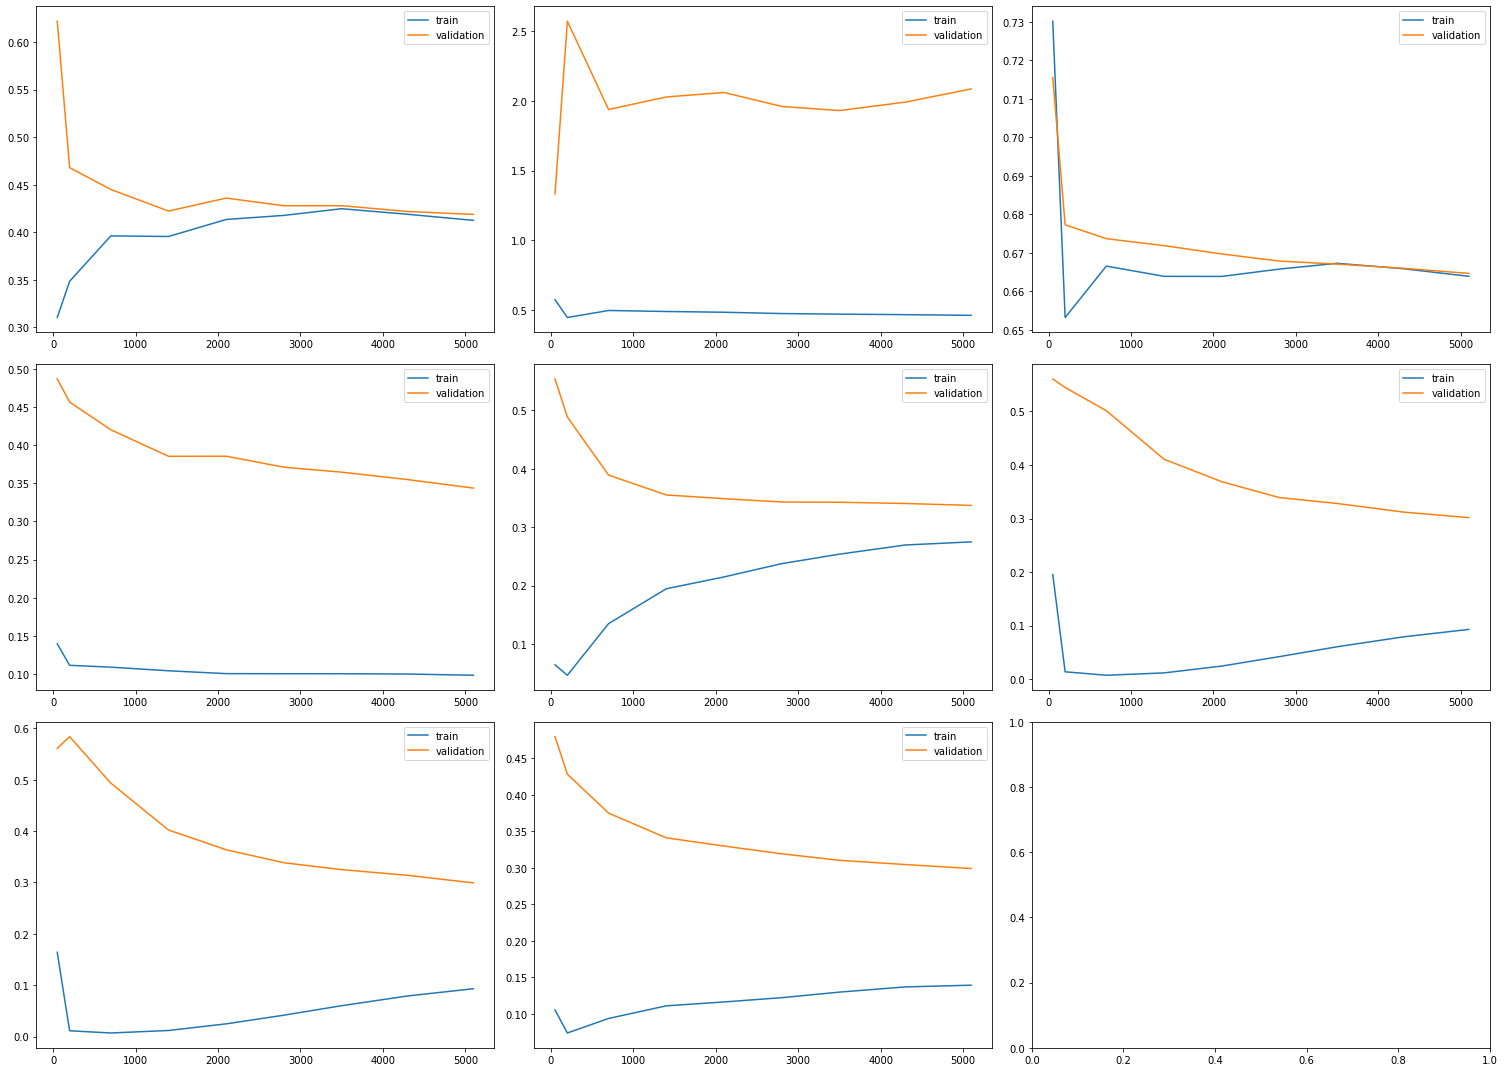

In [47]:
plot_learning_curves(X, y, list_of_models)

These plots show the learning curves of all the models. While the Logistic Regression and the SVC seem already quite at the limit, the other models show much room for improvement and are overfitting.

## Error Analysis



### Most wrong predictions

Instances which 6, 7 or all 8 models predicted wrongly.

In [23]:
def get_error_indices(X, y, dict_of_preds):
  error_instances = []
  for model, preds in baseline_preds.items():
    print(model)
    errors = y != preds
    idx = X.iloc[np.where(errors)[0], :].index.tolist()
    error_instances.extend(idx)
  errors_sorted = np.unique(error_instances, return_counts=True)[0]
  error_counts = np.unique(error_instances, return_counts=True)[1]
  list_of_errors = sorted(list(zip(error_counts, errors_sorted)), reverse=True)
  list_of_error_counts = sorted(list(zip(np.unique(error_counts, return_counts=True)[0], np.unique(error_counts, return_counts=True)[1])))
  return list_of_errors, list_of_error_counts

In [24]:
list_of_errors, list_of_error_counts = get_error_indices(X, y, baseline_preds)

LogisticRegression()
KNeighborsClassifier()
SVC(probability=True)
RandomForestClassifier()
XGBClassifier()
LGBMClassifier()
HistGradientBoostingClassifier()


In [25]:
# Voting Classifier would make 773 mistakes, which results in a performance of 86.35% accuracy.
list_of_error_counts

[(1, 439), (2, 182), (3, 118), (4, 102), (5, 93), (6, 103), (7, 174), (8, 323)]

In [26]:
indices = []
for error_idx in list_of_errors:
  if error_idx[0] > 5:
    indices.append(error_idx[1])

In [27]:
# DataFrame with instances which got 6 or 7 times wrongly predicted out of 7 models
most_wrong_df = train.loc[indices, :]
most_wrong_df.head()

district  percent households receiving food stamps      state  \
7566       46                                       2.8    wyoming   
7559       39                                       5.3    wyoming   
7537       17                                       9.6    wyoming   
7534       14                                       0.3    wyoming   
7502       81                                      10.5  wisconsin   

      percent uninsured  household language not english  non-white  \
7566                7.1                             8.4       9.55   
7559               13.0                            16.4       9.95   
7537               18.2                            15.8      11.32   
7534                5.8                             7.0      11.82   
7502                4.0                             5.2       7.53   

      black/afroamerican  percent female  under 20  20 to 34  35 to 49  \
7566                2.28           44.96     16.78     29.51     16.89   
7559                1.13           46.94     30.55     18.33     21.85   
7537                1.70           44.96     24.97     21.95     22.51   
7534                1.82           49.79     33.12     35.58     12.24   
7502                1.47           50.20     23.19     17.93     19.16   

      50 to 64  65 and over  median age  \
7566     17.18        19.63        38.4   
7559     20.13         9.14        35.5   
7537     17.84        12.73        36.3   
7534      9.53         9.52        23.2   
7502     21.73        18.00        41.6   

      monthly housing costs - $499 or lower  \
7566                                  20.54   
7559                                  28.29   
7537                                  34.50   
7534                                  17.19   
7502                                  13.12   

      monthly housing costs - $500 - 999  monthly housing costs - $1000 1999  \
7566                               30.27                               35.04   
7559                               29.31                               32.90   
7537                               37.34                               23.82   
7534                               34.62                               34.33   
7502                               40.43                               36.12   

      monthly housing costs - $2000 or higher  monthly housing costs - median  \
7566                                    14.15                           988.0   
7559                                     9.50                           858.0   
7537                                     4.34                           701.0   
7534                                    13.85                           937.0   
7502                                    10.33                           949.0   

      percent owner-occupied housing units  average family size  foreign born  \
7566                                  63.8                 2.65          5.37   
7559                                  68.9                 3.06         11.14   
7537                                  78.3                 3.49         10.11   
7534                                  50.3                 3.29          7.43   
7502                                  69.5                 2.87          3.67   

      percent of tot. population in poverty  \
7566                                   14.1   
7559                                   14.4   
7537                                   14.3   
7534                                   18.1   
7502                                    8.9   

      management, business, science, and arts occupations  \
7566                                              54.67     
7559                                              27.44     
7537                                              23.03     
7534                                              53.71     
7502                                              35.18     

      service occupations  sales and office occupations  \
7566        

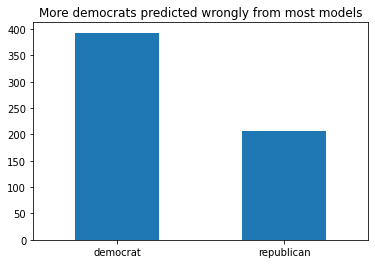

In [28]:
most_wrong_df.target.value_counts().plot.bar()
plt.title("More democrats predicted wrongly from most models")
plt.xticks([0, 1],["democrat", "republican"], rotation=0);

Twice as many Democrats as Republicans appear in the most_wrong predictions. This actually makes sense as the target is slightly imbalanced and models tend to be better on more data (-> more instances of republicans than democrats).

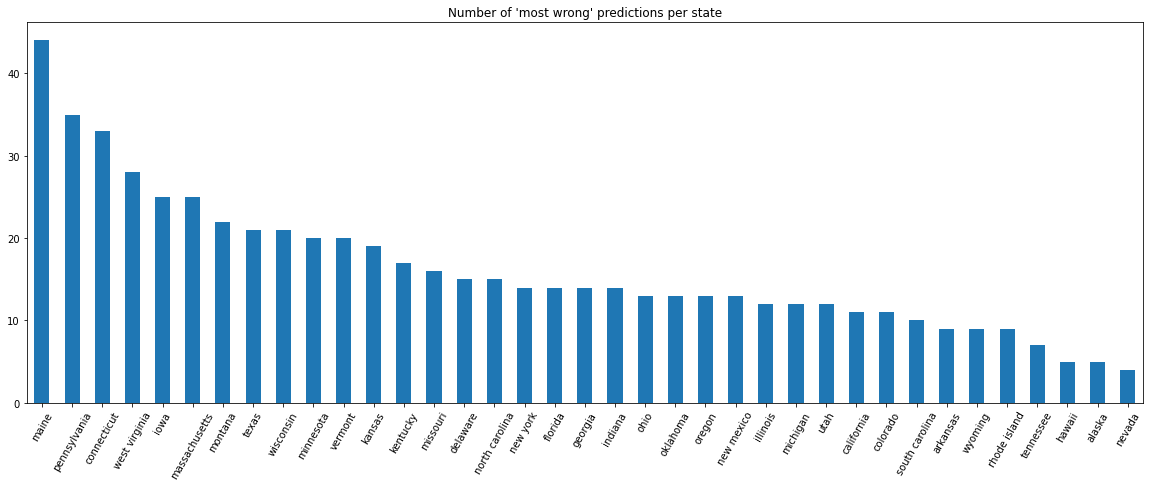

In [29]:
plt.figure(figsize=(20, 7))
state_idx = most_wrong_df.state.value_counts().index
most_wrong_df.state.value_counts().plot.bar()
plt.title("Number of 'most wrong' predictions per state")
plt.xticks(np.arange(len(state_idx)), state_idx, rotation=60);

In [30]:
def republican_percentage(X, y):
  """Returns percentage of republican and democratic elects per district."""
  df = pd.concat([X, y], axis=1)
  perc_elected = []
  for state, _ in enumerate(df.state.unique()):
  #for state in range(3):
    for i in range(2):
      perc_elected.append(df[(df.state == state) & (df.target == i)].shape[0] / df[df.state == state].shape[0])
  perc_rep, perc_dem = perc_elected[::2], perc_elected[1::2]
  return perc_rep, perc_dem

In [31]:
perc_rep, perc_dem = republican_percentage(X, y)

In [32]:
# Get sorted list of states
states = sorted(train.state.unique())
sorted_list = sorted(list(zip(perc_rep, states)), reverse=True)
sorted_perc_rep, sorted_states = [], []
for state in sorted_list:
  sorted_perc_rep.append(state[0])
  sorted_states.append(state[1])

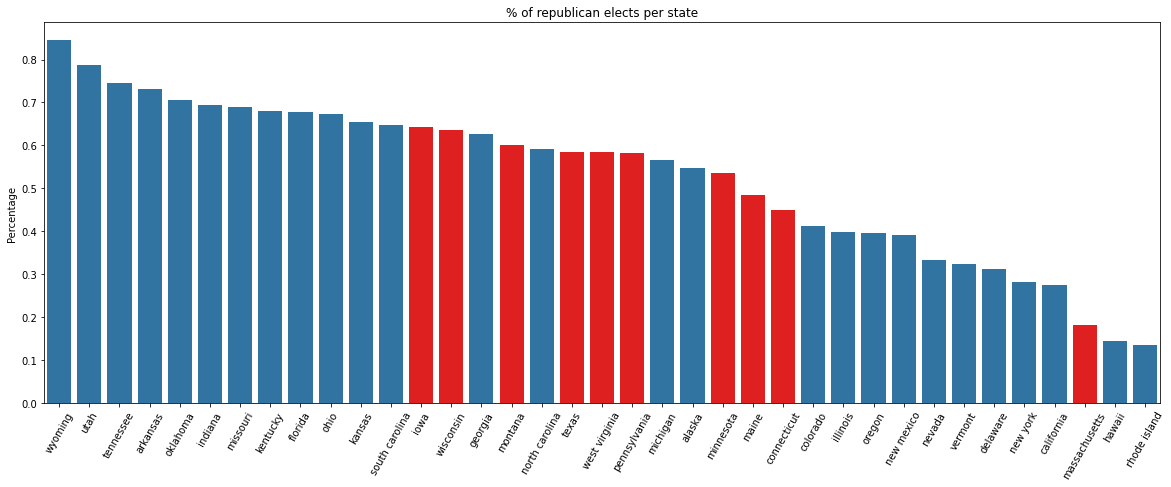

In [65]:
plt.figure(figsize=(20, 7))
#plt.bar(sorted_states, sorted_perc_rep)
sns.barplot(x=sorted_states, y=sorted_perc_rep, palette=["#1f77b4" if state not in most_wrong_df.state.value_counts().index[:10] else "red" for state in sorted_states])
plt.title("% of republican elects per state")
plt.ylabel("Percentage")
plt.xticks(rotation=60);

Red coloured are the ten states with the most instances in the most_wrong predicted DataFrame. As we can see, they tend to be in the middle of the distribution. So the more balanced the target variable in a state the more error prone it is for a model.

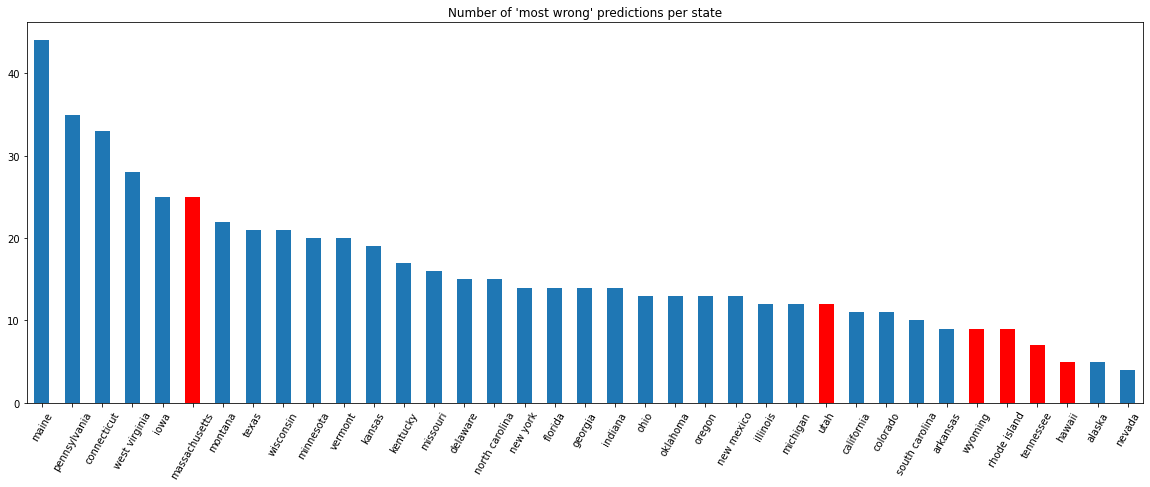

In [66]:
plt.figure(figsize=(20, 7))
state_idx = most_wrong_df.state.value_counts().index
most_wrong_df.state.value_counts().plot.bar(color=["#1f77b4" if state not in [*sorted_states[:3], *sorted_states[-3:]] else "red" for state in most_wrong_df.state.value_counts().index])
plt.title("Number of 'most wrong' predictions per state")
plt.xticks(np.arange(len(state_idx)), state_idx, rotation=60);

In contrast, states with a highly imbalanced target variable (red) tend to have a lower susceptibility to errors.

### Residual Analysis

In [67]:
def pearson_residuals(target, pred_probas):
  residuals = (target - pred_probas) / np.sqrt(pred_probas * (1 - pred_probas))
  return residuals

In [68]:
def plot_residuals(y, dict_of_probas):
  fig, axes = plt.subplots(3, 3, figsize=(21, 15))
  for ax, (model, probas) in zip(axes.flatten(), dict_of_probas.items()):
    residuals = pearson_residuals(y, probas[:, 1])
    sns.histplot(x=residuals, ax=ax)
    ax.set_title(f"{model} Pearson Residuals")
  plt.tight_layout()
  plt.show();

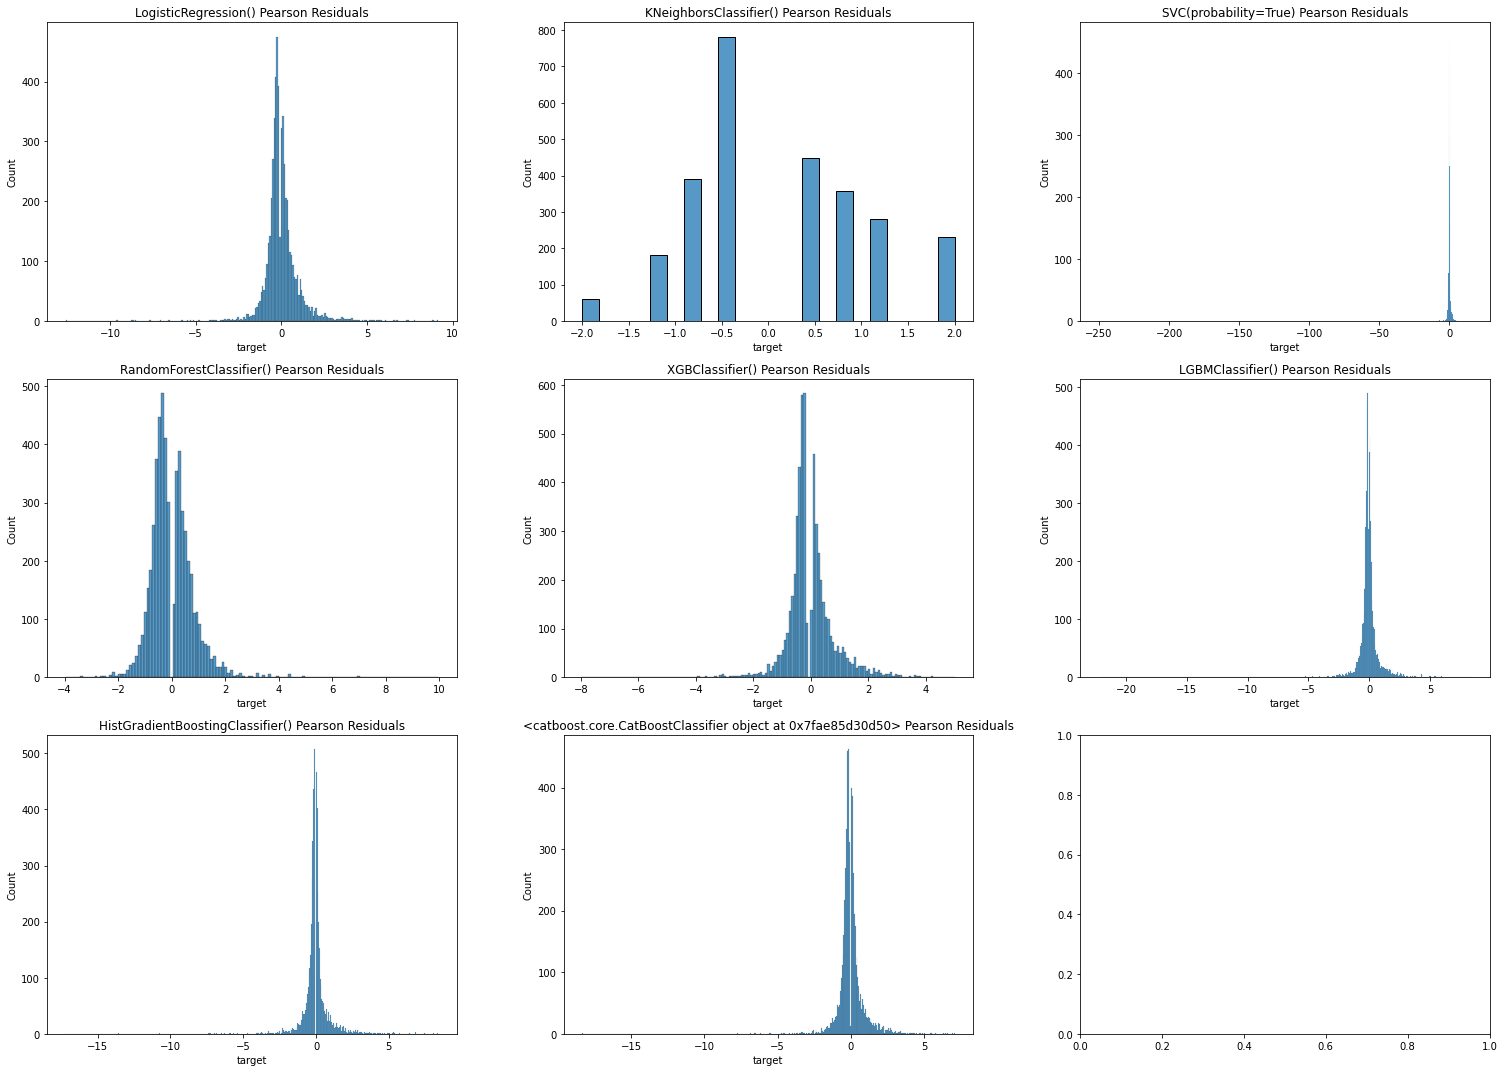

In [69]:
plot_residuals(y, baseline_probas)

### Highest Error Predictions

Instances which have a very high residual error. E.g. instances which have been predicted as democrats with a 80% probability but are actually republicans and vice versa.

In [ ]:
# Grenzwerte bei threshold 0.5
# 1 - 0.51 / sqrt(0.51 * (1 - 0.51))
# 0 - 0.49 / sqrt(0.49 * (1 - 0.49))

In [ ]:
high_error_idx = []
for model, probas in baseline_probas.items():
  residuals = pearson_residuals(y, probas[:, 1])
  idx = sorted(residuals.loc[(residuals > pearson_residuals(1, 0.1)) | (residuals < pearson_residuals(0, 0.9))].index.tolist())
  high_error_idx.extend(idx)
  high_error_idx = list(set(high_error_idx))

In [ ]:
# Get indices of rows which are in high_error and most_wrong DataFrames
high_error_df = df_train.loc[high_error_idx, :]
high_most_idx = [idx for idx in high_error_df.index if idx in most_wrong_df.index]

In [ ]:
X.loc[high_most_idx, :].head()

district  percent households receiving food stamps  state  \
4099       367                                       5.4      3   
4102       387                                      21.2      3   
4127       205                                      15.0      4   
33         266                                       3.6      0   
2091       251                                      12.4     19   
...        ...                                       ...    ...   
6065       256                                       2.0     21   
6097       390                                      30.7     21   
4065       217                                       1.6      3   
6116        43                                       4.2     22   
2043        31                                      19.6     18   

      percent uninsured  household language not english  non-white  \
4099                9.8                             8.6      13.03   
4102               10.3                            22.7      19.38   
4127                3.7                            29.2      20.43   
33                 12.2                             8.9      28.89   
2091               20.7                             3.7       5.25   
...                 ...                             ...        ...   
6065                1.6                            16.5      18.64   
6097               13.5                            43.3      41.66   
4065                2.9                             5.0       7.94   
6116                2.4                            16.6      15.54   
2043               11.0                             1.9       5.01   

      black/afroamerican  percent female  under 20  20 to 34  35 to 49  \
4099                0.70           49.69     21.06     20.02     18.19   
4102                0.73           49.64     25.99     17.73     17.38   
4127                4.09           50.17     23.18     19.88     20.41   
33                  1.06           50.57     26.50     20.60     19.70   
2091                0.35           46.98     22.90     16.10     19.70   
...                  ...             ...       ...       ...       ...   
6065                2.22           51.95     22.35     11.48     18.18   
6097                3.88           45.98     30.70     21.77     18.84   
4065                0.77           49.26     21.69     13.53     21.21   
6116                5.17           51.29     22.82     16.41     18.20   
2043                2.09           51.22     26.80     17.00     20.00   

      50 to 64  65 and over  median age  \
4099     21.58        19.15        42.0   
4102     19.65        19.26        40.0   
4127     18.82        17.70        40.6   
33       23.50         9.80        36.7   
2091     25.10        16.30        43.4   
...        ...          ...         ...   
6065     25.54        22.46        48.9   
6097     16.18        12.51        33.3   
4065     25.45        18.11        46.3   
6116     25.09        17.49        45.0   
2043     22.00        14.30        39.8   

      monthly housing costs - $499 or lower  \
4099                                  21.27   
4102                                  34.08   
4127                                   4.12   
33                                     8.10   
2091                                  30.30   
...                                     ...   
6065                                  10.05   
6097                                  44.74   
4065                                   7.22   
6116                                   0.77   
2043                                  33.70   

      monthly housing costs - $500 - 999  monthly housing costs - $1000 1999  \
4099                               22.70                               41.04   
4102                               39.31                               23.97   
4127                               33.82                               48.41   
33                                 17.20                             

In [ ]:
high_error_df.describe()

district  percent households receiving food stamps       state  \
count  339.000000                                339.000000  339.000000   
mean   267.616519                                 11.439233   19.058997   
std    150.434874                                  6.824986   10.090833   
min      1.000000                                  0.300000    0.000000   
25%    137.000000                                  6.000000   12.000000   
50%    300.000000                                 10.300000   18.000000   
75%    399.000000                                 15.850000   27.500000   
max    526.000000                                 41.900000   36.000000   

       percent uninsured  household language not english   non-white  \
count         339.000000                      339.000000  339.000000   
mean            8.981416                       13.289086   16.952684   
std             5.392070                       15.249581   15.160807   
min             0.700000                        0.300000    1.630000   
25%             5.000000                        4.200000    6.220000   
50%             7.700000                        7.800000   11.680000   
75%            11.750000                       16.400000   22.595000   
max            30.400000                       90.800000   87.270000   

       black/afroamerican  percent female    under 20    20 to 34    35 to 49  \
count          339.000000      339.000000  339.000000  339.000000  339.000000   
mean             5.548378       51.029794   24.679174   19.480265   18.869705   
std              7.922310        2.325856    3.632310    5.387089    2.543563   
min              0.000000       38.610000   14.800000    9.000000    3.800000   
25%              0.990000       50.045000   22.375000   16.100000   17.410000   
50%              2.520000       51.180000   24.500000   18.460000   19.040000   
75%              6.820000       52.300000   26.800000   21.810000   20.375000   
max             55.190000       59.750000   43.660000   67.100000   29.600000   

         50 to 64  65 and over  median age  \
count  339.000000   339.000000  339.000000   
mean    20.606991    16.357581   40.077286   
std      3.246500     4.461955    5.409523   
min      3.100000     2.500000   21.700000   
25%     18.820000    13.385000   36.700000   
50%     21.000000    16.300000   40.800000   
75%     22.415000    18.965000   43.300000   
max     29.300000    34.000000   58.100000   

       monthly housing costs - $499 or lower  \
count                             339.000000   
mean                               19.323923   
std                                13.369423   
min                                 0.770000   
25%                                 8.100000   
50%                                16.940000   
75%                                27.550000   
max                                60.800000   

       monthly housing costs - $500 - 999  monthly housing costs - $1000 1999  \
count                          339.000000                          339.000000   
mean                            31.403982                           33.730324   
std                             10.437260                           11.717383   
min                              2.040000                            6.600000   
25%                             22.860000                           24.850000   
50%                             33.400000                           35.000000   
75%                             39.355000                           41.900000   
max                             59.620000                           60.280000   

       monthly housing costs - $2000 or higher  \
count                               339.000000   
mean                                 14.195782   
std                                  15.077979   
min                                   0.000000   
25%                                   3.100000   
50%                                   7.600000   
75%                       

### Most different Distribution of Variables

In [72]:
X[df_train.target==0]

district  percent households receiving food stamps  state  \
606          1                                      16.6      7   
7278       362                                       5.4     32   
3664       251                                       5.1     35   
5919       225                                       6.0     19   
3591       510                                       8.8     33   
...        ...                                       ...    ...   
3702       303                                      14.5     35   
556        438                                      14.6      6   
2548       466                                       3.2     23   
6329       422                                       7.4     23   
7407       350                                      12.6     34   

      percent uninsured  household language not english  non-white  \
606                16.1                            11.1       9.96   
7278                7.4                            12.4       9.16   
3664                3.5                             5.7       6.26   
5919                6.4                             6.4       7.03   
3591                3.1                             3.9       5.50   
...                 ...                             ...        ...   
3702                8.2                             6.7       5.65   
556                22.7                            39.5      16.16   
2548                7.0                             8.7      19.49   
6329                9.4                            15.5      26.19   
7407                5.9                             0.4       2.19   

      black/afroamerican  percent female  under 20  20 to 34  35 to 49  \
606                 3.30           54.17     24.80     18.30     19.30   
7278                0.40           48.06     35.47     23.87     18.20   
3664                0.99           50.69     27.80     16.90     21.40   
5919                0.13           50.40     26.24     13.41     18.93   
3591                2.37           51.06     19.70     12.60     16.40   
...                  ...             ...       ...       ...       ...   
3702                1.79           49.84     21.10     16.20     17.10   
556                 8.48           51.21     26.30     17.90     18.00   
2548               13.33           52.00     28.60     17.00     25.20   
6329               16.81           53.09     24.92     18.18     19.87   
7407                0.23           51.47     21.81     16.25     16.81   

      50 to 64  65 and over  median age  \
606      19.80        17.90        40.7   
7278     12.52         9.94        28.0   
3664     21.60        12.30        38.7   
5919     21.83        19.60        43.0   
3591     25.20        26.10        50.6   
...        ...          ...         ...   
3702     23.50        22.10        46.8   
556      17.80        19.90        39.7   
2548     18.00        11.10        37.8   
6329     19.92        17.12        40.4   
7407     21.69        23.44        45.6   

      monthly housing costs - $499 or lower  \
606                                   31.20   
7278                                  13.05   
3664                                  12.20   
5919                                  36.74   
3591                                  15.10   
...                                     ...   
3702                                  24.80   
556                                   19.40   
2548                                   8.00   
6329                                  18.60   
7407                                  51.16   

      monthly housing costs - $500 - 999  monthly housing costs - $1000 1999  \
606                                37.40                               24.50   
7278                               16.42                               56.12   
3664                               37.30                               42.40   
5919                               31.89                             

In [78]:
def difference_to_normal_df(X, most_wrong_df):
  """ 
  Returns the difference of the means per feature of of X and most_wrong_df.
  The difference is measured using p-values from t-test.
  """
  p_values_0 = []
  p_values_1 = []
  for col in X.drop(["district", "state", "year"], axis=1).columns:
    _, p = ttest_ind(X[df_train.target==0][col], most_wrong_df[most_wrong_df.target==0][col])
    p_values_0.append(p)
    _, p = ttest_ind(X[df_train.target==1][col], most_wrong_df[most_wrong_df.target==1][col])
    p_values_1.append(p)
  p_values_0 = list(zip(p_values_0, X.drop(["district", "state", "year"], axis=1).columns))
  p_values_1 = list(zip(p_values_1, X.drop(["district", "state", "year"], axis=1).columns))
  return p_values_0, p_values_1

In [79]:
diff_rep, diff_dem = difference_to_normal_df(X, most_wrong_df)

These are the columns of the most_wrong_df which are the most different to the the columns itself in the original DataFrame. This could mean that this columns tend to have a high influence on the wrong decisions of the models.

In [80]:
# p_values with bonferroni correction 0.05 / 36 = 0.00138888888 and select the top few which appear in both target classes
sorted([pval for pval in diff_rep if pval[0] < 0.00138888888])[:8]

[(1.7389206774030994e-43, 'foreign born'),
 (1.776143710076368e-43, 'percent owner-occupied housing units'),
 (1.564702478130179e-39, 'household language not english'),
 (3.872067404591548e-35, 'non-white'),
 (4.055932223452721e-24, 'highschool'),
 (1.0744797176335284e-23, 'blue collar occupations'),
 (8.889239096054674e-23, 'bachelor or higher'),
 (1.2395677266311576e-22, '20 to 34')]

In [81]:
sorted([pval for pval in diff_dem if pval[0] < 0.00138888888])[:8]

[(3.4516516242161103e-75, 'percent owner-occupied housing units'),
 (6.477937141782666e-68, 'non-white'),
 (8.366889391195116e-45, 'median age'),
 (1.6081459078752383e-43, '20 to 34'),
 (2.247948236016585e-42, '50 to 64'),
 (1.1899289163859192e-40, 'foreign born'),
 (3.1063084485500185e-40, 'household language not english'),
 (6.389625647954371e-30, 'black/afroamerican')]

**Bonferroni Correction**<br>
Normally, we would look for an alpha value of 0.05 or a confidence level of 95%. However, due to the high number of statistical tests, we introduce the Bonferroni correction, which divides the alpha value by the number of executed hypothesis tests. The 37 features lead to 666 interactions and therefore also 666 hypothesis tests. So we divide the alpha value of 0.05 by 666 resulting in 0.000075 as our new alpha value.

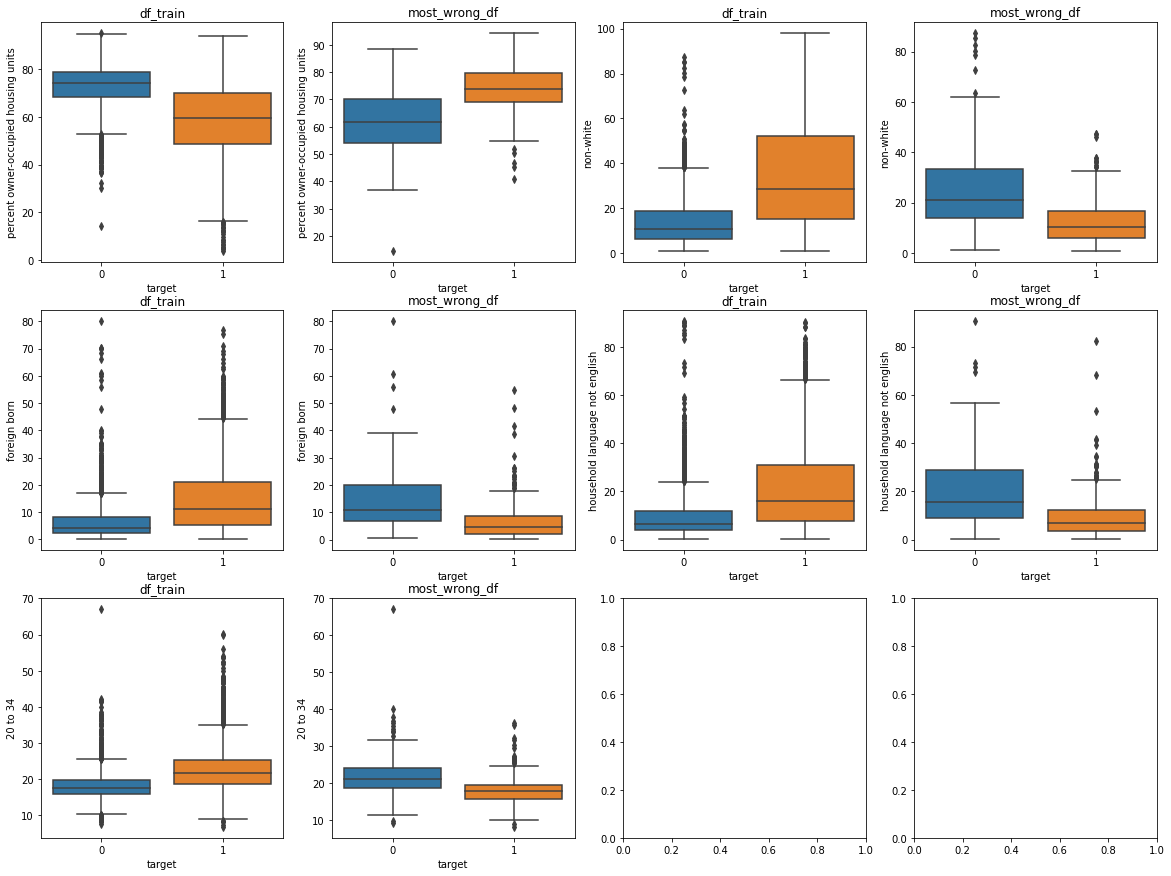

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15))
sns.boxplot(x="target", y="percent owner-occupied housing units", data=df_train, ax=ax[0, 0])
ax[0, 0].set_title("df_train")
sns.boxplot(x="target", y="percent owner-occupied housing units", data=most_wrong_df, ax=ax[0, 1])
ax[0, 1].set_title("most_wrong_df")

sns.boxplot(x="target", y="non-white", data=df_train, ax=ax[0, 2])
ax[0, 2].set_title("df_train")
sns.boxplot(x="target", y="non-white", data=most_wrong_df, ax=ax[0, 3])
ax[0, 3].set_title("most_wrong_df")

sns.boxplot(x="target", y="foreign born", data=df_train, ax=ax[1, 0])
ax[1, 0].set_title("df_train")
sns.boxplot(x="target", y="foreign born", data=most_wrong_df, ax=ax[1, 1])
ax[1, 1].set_title("most_wrong_df")

sns.boxplot(x="target", y="household language not english", data=df_train, ax=ax[1, 2])
ax[1, 2].set_title("df_train")
sns.boxplot(x="target", y="household language not english", data=most_wrong_df, ax=ax[1, 3])
ax[1, 3].set_title("most_wrong_df")

sns.boxplot(x="target", y="20 to 34", data=df_train, ax=ax[2, 0])
ax[2, 0].set_title("df_train")
sns.boxplot(x="target", y="20 to 34", data=most_wrong_df, ax=ax[2, 1])
ax[2, 1].set_title("most_wrong_df");

In the plots of these five features it's clearly visible that the mean and the distribution for each target class changes between the whole training set and the most_wrong_df. This seems to confuse the models.

In [ ]:
# Check for prediction with highest residual -> quasi most wrong single prediction
residuals.loc[residuals == residuals.min()]

6297   -5.06766
Name: target, dtype: float64

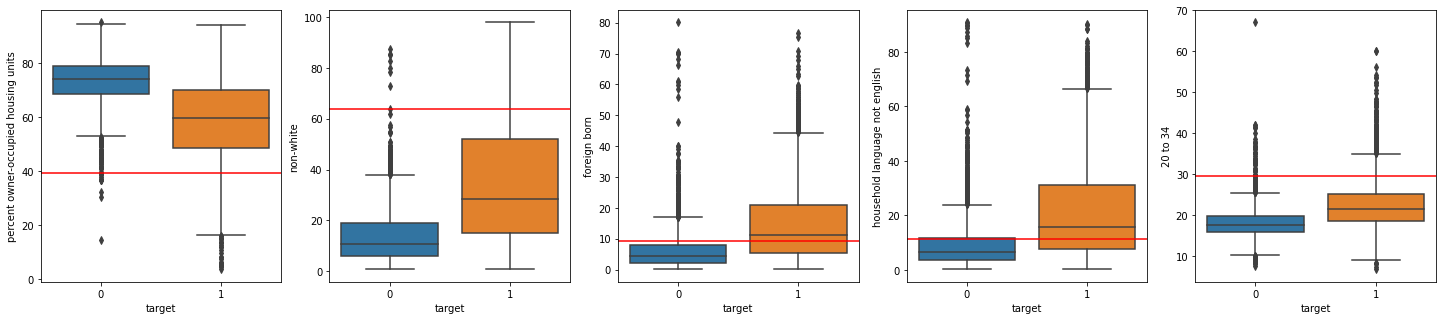

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
sns.boxplot(x="target", y="percent owner-occupied housing units", data=df_train, ax=ax[0])
ax[0].axhline(df_train.loc[6297, "percent owner-occupied housing units"], color="r")

sns.boxplot(x="target", y="non-white", data=df_train, ax=ax[1])
ax[1].axhline(df_train.loc[6297, "non-white"], color="r")

sns.boxplot(x="target", y="foreign born", data=df_train, ax=ax[2])
ax[2].axhline(df_train.loc[6297, "foreign born"], color="r")

sns.boxplot(x="target", y="household language not english", data=df_train, ax=ax[3])
ax[3].axhline(df_train.loc[6297, "household language not english"], color="r")

sns.boxplot(x="target", y="20 to 34", data=df_train, ax=ax[4])
ax[4].axhline(df_train.loc[6297, "20 to 34"], color="r")

# Feature Engineering

## Discretization

In [ ]:
def disc_strategy(X, y, list_of_models, min=5, max=30, step=2):
  """ Calculates log loss of two models. Both single variable model, one without 
  discretization and one with discretization (only of tyipe ordinal). Then, it compares their loss scores
  against each other and calculates a p value for statistical significance in
  the difference of the cross validated mean."""

  # Creating copies of the original DataFrame
  X_new = X.reset_index(drop=True) # reset so that cross validation works afterwards
  y_new = y.reset_index(drop=True)
  # Create DataFrame to save all accuracies of the different models
  df_total = pd.DataFrame()
  # Cross validation strategy
  kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=23)

  list_of_results, p_values = [], []
  # Create temporary DataFrame to save the model specific accuracies
  df_accuracies = pd.DataFrame()
  df_baselines = pd.DataFrame()
  # Loop over all the models
  for model in list_of_models:
    print(model)
    # Standardize Data if model = LogReg, KNN or SVC
    pipe = Pipeline(steps=[("std", StandardScaler()), ("model", model)])    
    results = {}
    # Cross validation loop
    for n_feat, feature in enumerate(X_new.drop("year", axis=1).columns):
      print(feature)
      # Dictionary to save all results and to convert it to a DataFrame later on
      results[feature] = {}
      # Variable to check for lowest mean and save the cross validated loss score
      best_result = -np.inf   
      # Feature column
      #results["feature"] = feature
      # Add baseline to results DataFrame
      #results["baseline"] = np.mean(baseline)
      #df_baselines.loc[n_feat, f"{model}_baseline"] = np.mean(baseline)
      
      # All variations of discretization from 2-10 bins, with ordinal ane onehot encoding and uniform/quantile/kmeans strategy
      for n_bins in range(min, max+1, step):
        for strategy in ["uniform", "quantile", "kmeans"]:
          # Discretizing
          discretizer = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy=strategy)
          new_feature = discretizer.fit_transform(X_new[feature].to_frame())
          #new_feature_val = discretizer.transform(X_val[feature].to_frame())
          # Add new features to respective DataFrames
          X_disc = pd.concat([X_new, pd.Series(new_feature.ravel())], axis=1)
          #X_val_new = pd.concat([X_val, pd.Series(new_feature_val.ravel())], axis=1)
          if type(model) in [type(LogisticRegression()), type(KNeighborsClassifier()), type(SVC())]:
            # Pipeline with standardizing and prediction
            scores = cross_val_score(pipe, X_disc, y_new, cv=kfold, scoring="accuracy", n_jobs=-1)
          else:
            # Only prediction
            scores = cross_val_score(model, X_disc, y_new, cv=kfold, scoring="accuracy", n_jobs=-1)
          df_accuracies[f"{feature}_{n_bins}_{strategy}"] = scores
  return df_accuracies

In [ ]:
df_disc_strategy = disc_strategy(X, y, [LogisticRegression()])

LogisticRegression()
district
percent households receiving food stamps
state
percent uninsured
household language not english
non-white
black/afroamerican
percent female
under 20
20 to 34
35 to 49
50 to 64
65 and over
median age
monthly housing costs - $499 or lower
monthly housing costs - $500 - 999
monthly housing costs - $1000 1999
monthly housing costs - $2000 or higher
monthly housing costs - median
percent owner-occupied housing units
average family size
foreign born
percent of tot. population in poverty
management, business, science, and arts occupations
service occupations
sales and office occupations
blue collar occupations
earnings $1 - $24'999
earnings $25'000 - 49'999
earnings $50'000 - 74'999
earnings $75'000 or more
median earnings
less than highschool
highschool
college or associate
bachelor or higher


In [ ]:
df_disc_strategy.to_csv("drive/MyDrive/US Elections/Notebook Data/df_disc_strategy.csv", index=False)

In [ ]:
df_disc_strategy = pd.read_csv("drive/MyDrive/US Elections/Notebook Data/df_disc_strategy.csv")

In [ ]:
best_strategies = []
for col in range(36):
  indices = []
  indices.extend(df_disc_strategy.iloc[:, (col*39):(col+1)*39].columns.tolist())
  best_strategies.append(df_disc_strategy.loc[:, indices].mean().idxmax())

In [ ]:
best_strategies = [strat.split("_")[-2:] for strat in best_strategies]

In [ ]:
with open("drive/MyDrive/US Elections/Notebook Data/best_strategies.pickle", "wb") as best_strategies_:
  pickle.dump(best_strategies, best_strategies_)

In [ ]:
disc_strategies = list(zip(X.drop("year", axis=1).columns, best_strategies))
disc_strategies

[('district', ['5', 'quantile']),
 ('percent households receiving food stamps', ['11', 'quantile']),
 ('state', ['23', 'quantile']),
 ('percent uninsured', ['13', 'quantile']),
 ('household language not english', ['5', 'quantile']),
 ('non-white', ['19', 'quantile']),
 ('black/afroamerican', ['21', 'quantile']),
 ('percent female', ['9', 'kmeans']),
 ('under 20', ['13', 'quantile']),
 ('20 to 34', ['27', 'kmeans']),
 ('35 to 49', ['29', 'kmeans']),
 ('50 to 64', ['7', 'quantile']),
 ('65 and over', ['7', 'quantile']),
 ('median age', ['13', 'uniform']),
 ('monthly housing costs - $499 or lower', ['25', 'uniform']),
 ('monthly housing costs - $500 - 999', ['15', 'kmeans']),
 ('monthly housing costs - $1000 1999', ['23', 'uniform']),
 ('monthly housing costs - $2000 or higher', ['15', 'quantile']),
 ('monthly housing costs - median', ['15', 'kmeans']),
 ('percent owner-occupied housing units', ['17', 'quantile']),
 ('average family size', ['13', 'quantile']),
 ('foreign born', ['19', 'un

In [ ]:
with open('drive/MyDrive/US Elections/Notebook Data/disc_strategies.pickle', 'wb') as disc_strategies_:
    pickle.dump(disc_strategies, disc_strategies_)

## Interaction Effects

In [ ]:
def find_interactions(X, y, n_rounds, p_value=0.1):
  """
  
  """
  X_new = X.copy().reset_index(drop=True)
  y_new = y.copy().reset_index(drop=True)
  # Create interaction DataFrame
  poly = PolynomialFeatures(interaction_only=True, include_bias=False)
  X_interaction = poly.fit_transform(X_new)
  X_interaction = pd.DataFrame(X_interaction, columns=poly.get_feature_names_out())
  # Instantiate LassoRegression
  log_reg = LogisticRegression(C=2, penalty="l1", solver="liblinear")
  # Create bootstrap resampling method
  list_cols = [] # list to save all the columns which are non null
  for i in range(n_rounds):
    # Take a fraction of the sample with bootstrapping
    X_boot = X_interaction.sample(frac=0.3, replace=True)
    # Scale variables
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_boot)
    X_scaled = pd.DataFrame(X_scaled, columns=scaler.get_feature_names_out())
    # Save indices of the chosen instances for y
    indices = X_scaled.index
    log_reg.fit(X_scaled, y_new.iloc[indices])
    # Check for all non-null values and save columns with non-null values to list
    important_cols = log_reg.coef_[0] != 0
    cols = X_interaction.columns[important_cols].tolist()
    list_cols.extend(cols)
  # Flatten the list
  #list_cols = [i for liste in list_cols for i in liste]
  # Value count of main and interaction effects
  cols = np.unique(list_cols, return_counts=True)[0]
  # 1 - (no. of times non-null / n_round) = p-value
  n_occur = 1 - (np.unique(list_cols, return_counts=True)[1] / n_rounds)
  final_list = sorted(list(zip(n_occur, cols)))

  # Calculate significant interactions
  significant_interactions = []
  for interaction in final_list:
    if interaction[0] < 0.1:
      significant_interactions.append(interaction[1])
    else:
      break
  
  return final_list, significant_interactions

In [ ]:
%%time
list_cols, significant_interactions = find_interactions(X, y, n_rounds=1000, p_value=0.1)

CPU times: user 3h 14min 34s, sys: 9.57 s, total: 3h 14min 44s
Wall time: 3h 13min 54s


In [ ]:
significant_interactions

['year', 'district state']

In [ ]:
with open('drive/MyDrive/US Elections/Notebook Data/interaction_list.pickle', 'wb') as interaction_list:
    pickle.dump(list_cols, interaction_list)

In [ ]:
# Interactions to consider
list_cols[:3]

[(0.050000000000000044, 'year'),
 (0.07499999999999996, 'district state'),
 (0.125, 'district percent uninsured')]

In [ ]:
def create_interactions(X):
  X_new = pd.DataFrame()
  X_new["district*state"] = X["district"] * X["state"]
  X_new["district*percent uninsured"] = X["district"] * X["percent uninsured"]
  return X_new

In [ ]:
X_interactions = create_interactions(X)
X_interactions.head()

district*state  district*percent uninsured
606                7                        16.1
1228            5292                      8687.7
5259            6202                      3145.3
4134             932                      1281.5
4734              45                        25.5

## Feature Generation with Decision Trees

In [ ]:
def cv_feature_generator(X, y, list_of_models=list, min=2, max=4):
  """ For different models this function creates gradient boosted features with GradientBoostingFeatureGenerator.
  The results for different tree depths are then cross validated. The DataFrame with all the cross validation 
  results as well as the strategy with the best median accuracy will be returned.
  """
  # Creating copies of the original DataFrame
  X_new = X.reset_index(drop=True) # reset so that cross validation works afterwards
  y_new = y.reset_index(drop=True)
  # Creating DataFrame for saving the accuracies of different models
  df_total = pd.DataFrame()
  # Cross validation strategy
  kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=23)

  # Loop over all the models
  for model in list_of_models:
    print(model)
    # Create temporary DataFrame to save the model specific accuracies
    df_accuracies = pd.DataFrame()
    df_baselines = pd.DataFrame()

    # Cross validation loop
    for num, (train, val) in enumerate(kfold.split(X_new, y_new)):
      # Create training and validation folds
      X_train, X_val = X_new.iloc[train], X_new.iloc[val]
      y_train, y_val = y_new[train], y_new[val]
      # Loop over strategies for tree depth
      for depth in range(min, max+1):
        # Create instance of feature generator, fit and transform the train and validation set
        gbfg = GradientBoostingFeatureGenerator(n_estimators=1, max_depth=depth)
        X_train_new = np.asarray(gbfg.fit_transform(X_train, y_train))
        X_val_new = np.asarray(gbfg.transform(X_val))

        if type(model) in [type(LogisticRegression()), type(KNeighborsClassifier()), type(SVC())]:
          sc = StandardScaler()
          X_train_new = sc.fit_transform(X_train_new)
          X_val_new = sc.transform(X_val_new)
          X_train_new, X_val_new = pd.DataFrame(X_train_new, columns=sc.get_feature_names_out()), pd.DataFrame(X_val_new, columns=sc.get_feature_names_out())

        model.fit(X_train_new, y_train)
        accuracy = model.score(X_val_new, y_val)
        df_accuracies.loc[num, str(model)[:-2]+"_depth_"+str(depth)] = accuracy
    # Concatenate DataFrame of new model to the total DataFrame
    df_total = pd.concat([df_total, df_accuracies], axis=1)

  # strategy wählen mit höchstem median value
  #strategy = df_accuracies.median().idxmax() # gibt zb "depth_2"
  n_depths = (max+1)-min
  
  # List to save the depth-strategies for different models
  strategies = []
  for col_idx in range(n_depths, df_total.shape[1]+1, n_depths):
    strategy = df_total.iloc[:, col_idx-n_depths:col_idx].median().idxmax()
    strategies.append(strategy)

  return df_total, strategies

In [ ]:
list_of_models = [LogisticRegression(), KNeighborsClassifier(), SVC(), RandomForestClassifier(), 
                  XGBClassifier(), LGBMClassifier(), HistGradientBoostingClassifier(), CatBoostClassifier()]

In [ ]:
%%time
fg_df, fg_strategies = cv_feature_generator(X, y, list_of_models, 
                                            min=2, max=5)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
6:	learn: 0.6224220	total: 78.4ms	remaining: 11.1s
7:	learn: 0.6136978	total: 89ms	remaining: 11s
8:	learn: 0.6048543	total: 111ms	remaining: 12.3s
9:	learn: 0.5962254	total: 124ms	remaining: 12.2s
10:	learn: 0.5890007	total: 134ms	remaining: 12.1s
11:	learn: 0.5810327	total: 145ms	remaining: 11.9s
12:	learn: 0.5740465	total: 155ms	remaining: 11.8s
13:	learn: 0.5666950	total: 166ms	remaining: 11.7s
14:	learn: 0.5612162	total: 177ms	remaining: 11.6s
15:	learn: 0.5561633	total: 187ms	remaining: 11.5s
16:	learn: 0.5498246	total: 205ms	remaining: 11.9s
17:	learn: 0.5442223	total: 224ms	remaining: 12.2s
18:	learn: 0.5382919	total: 235ms	remaining: 12.1s
19:	learn: 0.5328205	total: 245ms	remaining: 12s
20:	learn: 0.5284769	total: 256ms	remaining: 11.9s
21:	learn: 0.5234054	total: 266ms	remaining: 11.8s
22:	learn: 0.5190367	total: 277ms	remaining: 11.8s
23:	learn: 0.5145201	total: 288ms	remaining: 11.7s
24:	learn: 0.5093213	to

In [ ]:
fg_df.mean()

LogisticRegression_depth_2                                           0.835129
LogisticRegression_depth_3                                           0.841127
LogisticRegression_depth_4                                           0.840128
LogisticRegression_depth_5                                           0.836893
KNeighborsClassifier_depth_2                                         0.833774
KNeighborsClassifier_depth_3                                         0.835304
KNeighborsClassifier_depth_4                                         0.827594
KNeighborsClassifier_depth_5                                         0.821239
SVC_depth_2                                                          0.864019
SVC_depth_3                                                          0.864488
SVC_depth_4                                                          0.852309
SVC_depth_5                                                          0.839481
RandomForestClassifier_depth_2                                  

In [ ]:
fg_strategies

['LogisticRegression_depth_3',
 'KNeighborsClassifier_depth_3',
 'SVC_depth_3',
 'RandomForestClassifier_depth_4',
 'XGBClassifier_depth_2',
 'LGBMClassifier_depth_2',
 'HistGradientBoostingClassifier_depth_2',
 '<catboost.core.CatBoostClassifier object at 0x7faf1e142c5_depth_2']

In [ ]:
with open('drive/MyDrive/US Elections/Notebook Data/feature_generation.pickle', 'wb') as feature_generation:
    pickle.dump(fg_df, feature_generation)

## Drop correlated Features

In [ ]:
def get_drop_correlated_strategy(X, y, list_of_models, min=0.75, max=0.9, steps=16):
  """Cross validated feature dropping with different correlation thresholds. DataFrame with cross validation
  accuracies and strategies for each model are returned. 
  """
  # Creating copies of the original DataFrame
  X_new = X.reset_index(drop=True) # reset so that cross validation works afterwards
  y_new = y.reset_index(drop=True)
  # Create DataFrame to save all accuracies of the different models
  df_total = pd.DataFrame()
  # Cross validation strategy
  kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=23)

  # Loop over all the models
  for model in list_of_models:
    print(model)
    # Create temporary DataFrame to save the model specific accuracies
    df_accuracies = pd.DataFrame()
    # Cross validation loop
    for num, (train, val) in enumerate(kfold.split(X_new, y_new)):
      # Create training and validation folds
      X_train, X_val = X_new.iloc[train], X_new.iloc[val]
      y_train, y_val = y_new[train], y_new[val]

      # Create correlation matrix
      corr_matrix = pd.concat([X_train, y_train], axis=1).corr()
      # Create dictionaries to save results and dataframes
      results, dataframes = {}, {}
  
      # Loop through all relevant correlation thresholds
      for threshold in np.linspace(min, max, steps):
        # Create list for drop out features
        to_drop = []
        # Loop through all the columns (except they are already dropped out)
        for feature in corr_matrix.columns:
          # Check if feature is in to drop -> doesn't have to be checked for correlation anymore
          if feature in to_drop:
            continue
          # Check for correlations of > threshold
          high_correlations = corr_matrix[abs(corr_matrix[feature]) > threshold].index.tolist()
          # Subtract 1 (=feature) -> when subtracted and no correlations list will be = 0 -> if statement not executed
          if len(high_correlations)-1:
            corr_matrix_temp = corr_matrix[[*high_correlations, "target"]].corr()      
            # Get maximum correlation with target and remove it from the list of correlated features
            best_index = corr_matrix_temp.drop("target")["target"].idxmin() # CHANGE TO IDXMIN -> SEE WHAT HAPPENS
            high_correlations.remove(best_index)
            to_drop.extend(high_correlations)
        to_drop = set(to_drop)
        X_train_dropped = X_train.drop(to_drop, axis=1)
        X_val_dropped = X_val.drop(to_drop, axis=1)

        if type(model) in [type(LogisticRegression()), type(KNeighborsClassifier()), type(SVC())]:
              sc = StandardScaler()
              X_train_dropped = sc.fit_transform(X_train_dropped)
              X_val_dropped = sc.transform(X_val_dropped)
              X_train_dropped, X_val_dropped = pd.DataFrame(X_train_dropped, columns=sc.get_feature_names_out()), pd.DataFrame(X_val_dropped, columns=sc.get_feature_names_out())
        
        # Calculate score for respective fold
        model.fit(X_train_dropped, y_train)
        accuracy = model.score(X_val_dropped, y_val)
        df_accuracies.loc[num, str(model)[:-2]+"_"+str(threshold)] = accuracy
      
    # Concatenate DataFrame of new model to the total DataFrame
    df_total = pd.concat([df_total, df_accuracies], axis=1) 
    
  # Find best strategy for each model
  strategies = {}
  for num, col_idx in enumerate(range(steps, df_total.shape[1]+1, steps)):
    strategy = df_total.iloc[:, col_idx-steps:col_idx].mean().idxmax()
    strategies[str(list_of_models[num])] = float(strategy.split("_")[1])
  #df_total = df_total.append(df_total.median(), ignore_index=True)
  #df_total = df_total.rename(index={kfold.get_n_splits():"median"})
  
  return df_total, strategies

In [ ]:
%%time
list_of_models = [LogisticRegression(), KNeighborsClassifier(), SVC(), RandomForestClassifier(), 
                  XGBClassifier(), HistGradientBoostingClassifier(), LGBMClassifier(), 
                  CatBoostClassifier()]
corr_df, corr_strategies = get_drop_correlated_strategy(X, y, list_of_models, min=0.75, max=0.9, steps=16)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
214:	learn: 0.2442813	total: 1.55s	remaining: 1.33s
215:	learn: 0.2438697	total: 1.56s	remaining: 1.33s
216:	learn: 0.2432389	total: 1.56s	remaining: 1.32s
217:	learn: 0.2426304	total: 1.57s	remaining: 1.31s
218:	learn: 0.2420075	total: 1.58s	remaining: 1.3s
219:	learn: 0.2414951	total: 1.58s	remaining: 1.3s
220:	learn: 0.2410732	total: 1.59s	remaining: 1.29s
221:	learn: 0.2403960	total: 1.6s	remaining: 1.28s
222:	learn: 0.2396833	total: 1.61s	remaining: 1.27s
223:	learn: 0.2392406	total: 1.61s	remaining: 1.27s
224:	learn: 0.2386867	total: 1.62s	remaining: 1.26s
225:	learn: 0.2380685	total: 1.63s	remaining: 1.25s
226:	learn: 0.2373799	total: 1.64s	remaining: 1.25s
227:	learn: 0.2368561	total: 1.64s	remaining: 1.24s
228:	learn: 0.2362907	total: 1.65s	remaining: 1.23s
229:	learn: 0.2357782	total: 1.66s	remaining: 1.23s
230:	learn: 0.2352824	total: 1.66s	remaining: 1.22s
231:	learn: 0.2349011	total: 1.67s	remaining: 1.21s


In [ ]:
corr_df.to_csv("drive/MyDrive/US Elections/Notebook Data/corr_df.csv", index=False)

In [ ]:
with open("drive/MyDrive/US Elections/Notebook Data/corr_strategies.pickle", "wb") as corr_strategies_:
  pickle.dump(corr_strategies, corr_strategies_)

In [ ]:
pd.set_option("display.max_rows", None)
corr_df.mean()

LogisticRegression_0.75                                                         0.825771
LogisticRegression_0.76                                                         0.825889
LogisticRegression_0.77                                                         0.825890
LogisticRegression_0.78                                                         0.826478
LogisticRegression_0.79                                                         0.830539
LogisticRegression_0.8                                                          0.832833
LogisticRegression_0.81                                                         0.832892
LogisticRegression_0.8200000000000001                                           0.832598
LogisticRegression_0.8300000000000001                                           0.832362
LogisticRegression_0.8400000000000001                                           0.831891
LogisticRegression_0.85                                                         0.831950
LogisticRegression_0.

In [ ]:
# For different algorithms
corr_strategies

{'<catboost.core.CatBoostClassifier object at 0x7f76b95ec9d0>': 0.87,
 'HistGradientBoostingClassifier()': 0.8300000000000001,
 'KNeighborsClassifier()': 0.87,
 'LGBMClassifier()': 0.85,
 'LogisticRegression()': 0.87,
 'RandomForestClassifier()': 0.81,
 'SVC()': 0.8200000000000001,
 'XGBClassifier()': 0.88}

In [ ]:
def drop_correlated_features(X, y, corr_strategies):
  corr_matrix = pd.concat([X, y], axis=1).corr()
  corr_dfs = {}
  for model, threshold in corr_strategies.items():
    to_drop = []
    for feature in [col for col in corr_matrix.columns if col not in to_drop]:
      # Check for correlations of > threshold
      high_correlations = corr_matrix[abs(corr_matrix[feature]) > threshold].index.tolist()
      # Subtract 1 (=feature) -> when subtracted and no correlations list will be = 0 -> if statement not executed
      if len(high_correlations)-1:
        corr_matrix_temp = corr_matrix[[*high_correlations, "target"]].corr()      
        # Get maximum correlation with target and remove it from the list of correlated features
        best_index = corr_matrix_temp.drop("target")["target"].idxmax() # CHANGE TO IDXMIN -> SEE WHAT HAPPENS
        high_correlations.remove(best_index)
        to_drop.extend(high_correlations)
    to_drop = set(to_drop)
    X_dropped = X.drop(to_drop, axis=1)
    corr_dfs[str(model)] = X_dropped
  return corr_dfs

In [ ]:
# Drop correlated features
corr_dfs = drop_correlated_features(X, y, corr_strategies)

In [ ]:
with open("drive/MyDrive/US Elections/Notebook Data/corr_dfs.pickle", "wb") as corr_dfs_:
  pickle.dump(corr_dfs, corr_dfs_)

## Evaluation Pipeline

Evaluate best scaling and transformation strategy.

In [145]:
def evaluate_model(X, y, model):
  # Cross validation
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
	# Model Evaluation
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

In [146]:
def get_pipelines(X):
  pipelines = []
  model_ = model
  orig_cols = X.columns.tolist()
  #all_cols = X_new.columns.tolist()
  # Normal
  p_normal = Pipeline(steps=[("model", model)])
  pipelines.append(("p_normal", p_normal))
  # MinMax
  p_minmax = Pipeline(steps=[("minmax", MinMaxScaler()), ("model", model)])
  pipelines.append(("minmax", p_minmax))
  # Normalized
  p_normalized = Pipeline(steps=[("norm", Normalizer()), ("model", model)])
  pipelines.append(("norm", p_normalized))
  # Robust
  p_robust = Pipeline(steps=[("robust", RobustScaler()), ("model", model)])
  pipelines.append(("robust", p_robust))
  # Standardized
  p_stand = Pipeline(steps=[("stand", StandardScaler()), ("model", model)])
  pipelines.append(("stand", p_stand))

  transformer = Pipeline([("trans", PowerTransformer(standardize=False))])
  # Transform_MinMax
  minmax = ColumnTransformer([("trans", transformer, orig_cols), ("minmax", MinMaxScaler(), orig_cols)])
  t_minmax = Pipeline(steps=[("prep", minmax), ("model", model)])
  pipelines.append(("t_minmax", t_minmax))
  # Transform_Normalized
  normalized = ColumnTransformer([("trans", transformer, orig_cols), ("norm", Normalizer(), orig_cols)])
  t_normalized = Pipeline(steps=[("prep", normalized), ("model", model)])
  pipelines.append(("t_norm", t_normalized))
  # Transform_Robust
  robust = ColumnTransformer([("trans", transformer, orig_cols), ("robust", RobustScaler(), orig_cols)])
  t_robust = Pipeline(steps=[("prep", robust), ("model", model)])
  pipelines.append(("t_robust", t_robust))
  # Transform_Standardized
  stand = ColumnTransformer([("trans", transformer, orig_cols), ("stand", StandardScaler(), orig_cols)])
  t_stand = Pipeline(steps=[("prep", stand), ("model", model)])
  pipelines.append(("t_stand", t_stand))

  return pipelines

In [147]:
models = [LogisticRegression(), XGBClassifier(), LGBMClassifier()]
results = []

for model in models:
  print(model)
  pipelines = get_pipelines(X)
  for name, pipe in pipelines:
    scores = evaluate_model(X, y, pipe)
    results.append((model, name, round(np.mean(scores)*100, 4), round(np.std(scores), 4)))

LogisticRegression()
XGBClassifier()
LGBMClassifier()


In [148]:
results

[(LogisticRegression(), 'p_normal', 81.2004, 0.0177),
 (LogisticRegression(), 'minmax', 83.371, 0.0176),
 (LogisticRegression(), 'norm', 55.8343, 0.0069),
 (LogisticRegression(), 'robust', 83.5655, 0.0152),
 (LogisticRegression(), 'stand', 83.6539, 0.0159),
 (LogisticRegression(), 't_minmax', 77.1224, 0.0169),
 (LogisticRegression(), 't_norm', 77.1581, 0.0165),
 (LogisticRegression(), 't_robust', 77.2637, 0.0166),
 (LogisticRegression(), 't_stand', 77.0344, 0.0172),
 (XGBClassifier(), 'p_normal', 85.3135, 0.0081),
 (XGBClassifier(), 'minmax', 85.3135, 0.0081),
 (XGBClassifier(), 'norm', 84.4305, 0.0154),
 (XGBClassifier(), 'robust', 85.3135, 0.0081),
 (XGBClassifier(), 'stand', 85.3135, 0.0081),
 (XGBClassifier(), 't_minmax', 85.3135, 0.0081),
 (XGBClassifier(), 't_norm', 85.5958, 0.0135),
 (XGBClassifier(), 't_robust', 85.3135, 0.0081),
 (XGBClassifier(), 't_stand', 85.3135, 0.0081),
 (LGBMClassifier(), 'p_normal', 86.9549, 0.0082),
 (LGBMClassifier(), 'minmax', 86.7435, 0.0061),
 (LG

## Feature Selection

### Including random variable

In [ ]:
def feature_selection_dt(X, y):
  random_feature = pd.Series(np.random.randint(0, 100, 5665), name="random_feature")
  X_new = pd.concat([X.reset_index(drop=True), random_feature], axis=1)
  y_new = y.reset_index(drop=True)
  print(X_new.shape)
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
  bad_features = []
  for num, (train, val) in enumerate(cv.split(X_new, y_new)):
    if num % 5 == 0:
      print(num)
    X_train, X_val = X_new.iloc[train], X_new.iloc[val]
    y_train, y_val = y.iloc[train], y.iloc[val]

    tree_clf = RandomForestClassifier()
    tree_clf.fit(X_train, y_train)
    features = X_new.columns[tree_clf.feature_importances_ < tree_clf.feature_importances_[-1]]
    bad_features.extend(features)
  return bad_features

In [ ]:
bad_features = feature_selection_dt(X, y)

(5665, 38)
0


In [ ]:
# In every resample year has a worse feature importance than the added random variable
# ---> drop year variable
np.unique(bad_features, return_counts=True)

(array(["earnings $75'000 or more", 'year'], dtype='<U24'), array([ 1, 30]))

### Minimum Redundancy Maximum Relevance

In [ ]:
!pip install mrmr_selection
import mrmr

In [ ]:
# select top 10 features using mRMR
from mrmr import mrmr_classif

In [ ]:
selected_features = mrmr_classif(X=X_train_lr, y=y.reset_index(drop=True), K=30)

100%|██████████| 30/30 [00:06<00:00,  4.41it/s]


In [ ]:
selected_features

['percent owner-occupied housing units',
 'monthly housing costs - median_disc',
 'non-white',
 'fg_4',
 'percent owner-occupied housing units_disc',
 'non-white_disc',
 'fg_0',
 'management, business, science, and arts occupations*blue collar occupations',
 '20 to 34_disc',
 'household language not english',
 'non-white*black/afroamerican',
 'household language not english_disc',
 '20 to 34',
 'foreign born_disc',
 'black/afroamerican',
 'foreign born',
 'service occupations_disc',
 'percent female',
 'percent households receiving food stamps',
 'district*black/afroamerican',
 'monthly housing costs - $499 or lower*monthly housing costs - $1000 1999',
 'black/afroamerican_disc',
 'service occupations',
 'blue collar occupations_disc',
 'percent uninsured*black/afroamerican',
 'percent female_disc',
 'median age',
 'fg_7',
 'blue collar occupations',
 'percent of tot. population in poverty']

In [ ]:
scores = cross_val_score(HistGradientBoostingClassifier(), X[selected_features], y, 
                         cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=35),
                         scoring="accuracy", n_jobs=-1, verbose=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.9s finished


In [ ]:
np.mean(scores), np.std(scores), scores

(0.827535870606149,
 0.014161678377086465,
 array([0.81128748, 0.84303351, 0.82010582, 0.85890653, 0.81481481,
        0.83568905, 0.81448763, 0.8180212 , 0.79681979, 0.84275618,
        0.83421517, 0.84656085, 0.8377425 , 0.83597884, 0.81834215,
        0.81272085, 0.82508834, 0.81448763, 0.82332155, 0.83745583,
        0.81128748, 0.8324515 , 0.83950617, 0.80070547, 0.83597884,
        0.83215548, 0.83392226, 0.83215548, 0.84452297, 0.82155477]))

In [ ]:
np.arange(5, 31, 5)

In [ ]:
X_new.shape

(5665, 44)

In [ ]:
from mrmr import mrmr_classif

def feature_selection_mrmr(X, y):
  scores = pd.DataFrame()
  cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=39)
  for model in zip(list_of_models, :
    print(model)
    for num, (train, val) in enumerate(cv.split(X, y)):
      print(num)
      X_train, X_val = X.iloc[train], X.iloc[val]
      y_train, y_val = y.iloc[train], y.iloc[val]
      for i in range(21, 38, 2):
        selected_features = mrmr_classif(X=X_train, y=y_train, K=i)
        model.fit(X_train[selected_features], y_train)
        score = model.score(X_val[selected_features], y_val)
        scores.loc[num, f"{model}_{i}_features"] = score
  return scores

In [ ]:
for i 
mrmr_scores = feature_selection_mrmr(X, y)

In [ ]:
mrmr_scores.to_csv("drive/MyDrive/US Elections/Notebook Data/mrmr_scores.csv", index=False)

# Preparing Training Data

## Different Datasets

X normal = **X** <br>
X normals without correlated = **dict_of_Xs** <br>
X_disc = **X_new** <br>
X_discs without correlated = **dict_of_X_discs**


In [103]:
y_new = y.reset_index(drop=True)

In [104]:
# Discretization

In [105]:
with open('drive/MyDrive/US Elections/Notebook Data/disc_strategies.pickle', 'rb') as disc_strategies_:
    disc_strategies = pickle.load(disc_strategies_)
with open('drive/MyDrive/US Elections/Notebook Data/best_strategies.pickle', 'rb') as best_strategies_:
    best_strategies = pickle.load(best_strategies_)

In [106]:
def discretizer(X):
  """Creates discretized versions of the original columns for all columns regardless of its relation to the target."""
  X_new = X.reset_index(drop=True).copy()
  X_disc = pd.DataFrame()
  for col, strat in zip(X_new.drop("year", axis=1).columns, best_strategies):
    kbins = KBinsDiscretizer(n_bins=int(strat[0]), encode="ordinal", strategy=strat[1])
    disc_feature = kbins.fit_transform(X[col].to_frame()).ravel()
    X_disc = pd.concat([X_disc, pd.Series(disc_feature, name=f"{col}_disc")], axis=1)
  return X_disc

In [107]:
from sklearn.preprocessing import KBinsDiscretizer
X_disc = discretizer(X)

In [108]:
def drop_disc_normal_column(X, X_disc, y):
  """Decides which discretized columns actually have a stronger correlation with the target than the original columns.
  Those columns are kept as part of the DataFrame X_disc."""
  disc_cols_to_keep = [] # discretized cols to keep
  normal_cols_to_drop = []
  X_new = X.reset_index(drop=True)
  y_new = y.reset_index(drop=True)
  for col in X_new.columns[:-1]: # year has no discretized column
    if col in ["district", "state"]:
      continue
    corr_normal = abs(X_new[col].corr(y_new))
    corr_disc = abs(X_disc[f"{col}_disc"].corr(y_new))
    if corr_disc >= corr_normal:
      disc_cols_to_keep.append(f"{col}_disc")
      normal_cols_to_drop.append(col)
  return disc_cols_to_keep, normal_cols_to_drop

In [109]:
disc_cols_to_keep, normal_cols_to_drop = drop_disc_normal_column(X, X_disc, y)

In [110]:
# Keep the relevant columns of discretized DataFrame
X_disc = X_disc[disc_cols_to_keep]
X_new = pd.concat([X.drop(normal_cols_to_drop, axis=1).reset_index(drop=True), X_disc], axis=1)

In [111]:
scores = cross_val_score(LGBMClassifier(),
                         X_new,
                         y.reset_index(drop=True),
                         cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3),
                         scoring="accuracy",
                         n_jobs=-1)

In [112]:
np.mean(scores), np.std(scores), scores

(0.8678426533550208,
 0.014932388616567347,
 array([0.86772487, 0.85714286, 0.88007055, 0.86419753, 0.86948854,
        0.87279152, 0.86925795, 0.87279152, 0.85689046, 0.8745583 ,
        0.88007055, 0.87301587, 0.89594356, 0.85890653, 0.85714286,
        0.88869258, 0.87632509, 0.87809187, 0.8639576 , 0.83922261,
        0.86243386, 0.85361552, 0.85537919, 0.86948854, 0.88712522,
        0.8639576 , 0.82862191, 0.85865724, 0.85865724, 0.90106007]))

In [113]:
# Interactions

In [114]:
with open('drive/MyDrive/US Elections/Notebook Data/interaction_list.pickle', 'rb') as interaction_list:
    list_cols = pickle.load(interaction_list)

In [115]:
list_cols

[(0.050000000000000044, 'year'),
 (0.07499999999999996, 'district state'),
 (0.125, 'district percent uninsured'),
 (0.16000000000000003,
  'monthly housing costs - $499 or lower monthly housing costs - $2000 or higher'),
 (0.16000000000000003, 'state percent uninsured'),
 (0.17400000000000004, 'state black/afroamerican'),
 (0.17700000000000005, 'district black/afroamerican'),
 (0.17900000000000005, 'household language not english black/afroamerican'),
 (0.18999999999999995, 'district percent households receiving food stamps'),
 (0.19099999999999995, 'district foreign born'),
 (0.19199999999999995, 'non-white black/afroamerican'),
 (0.19699999999999995, 'percent households receiving food stamps state'),
 (0.19899999999999995, "earnings $1 - $24'999 earnings $75'000 or more"),
 (0.20099999999999996, 'black/afroamerican foreign born'),
 (0.21299999999999997, 'state foreign born'),
 (0.22199999999999998, 'district non-white'),
 (0.22199999999999998, 'percent uninsured black/afroamerican')

In [116]:
def create_interactions(X):
  X_new = pd.DataFrame()
  X_new["district*state"] = X["district"] * X["state"]
  X_new["district*percent uninsured"] = X["district"] * X["percent uninsured"]
  return X_new

In [117]:
X_interactions = create_interactions(X)
X_interactions.head()

district*state  district*percent uninsured
606                7                        16.1
1228            5292                      8687.7
5259            6202                      3145.3
4134             932                      1281.5
4734              45                        25.5

In [118]:
# Feature Generation

In [119]:
with open('drive/MyDrive/US Elections/Notebook Data/feature_generation.pickle', 'rb') as feature_generation:
    fg_df = pickle.load(feature_generation)

In [120]:
def feature_generation(X, y, fg_df):
  fg_strategy, fg_dataframes = {}, {}
  for num in range(8):
    strat = fg_df[fg_df.iloc[:, (num*4):(num+1)*4].columns].mean().idxmax().split("_")
    fg_strategy[f"{strat[0]}()"] = strat[-1]

  for num, (model, depth) in enumerate(fg_strategy.items()):
    gbfg = GradientBoostingFeatureGenerator(stack_to_X=False, n_estimators=1, max_depth=int(depth))
    X_new = np.asarray(gbfg.fit_transform(X, y))
    fg_dataframes[str(model)] = pd.DataFrame(X_new, columns=[f"fg_{i}" for i in range(X_new.shape[1])])
  return fg_dataframes

In [121]:
# Dictionary with DataFrames for all different algorithms
fg_dfs = feature_generation(X, y, fg_df)

In [122]:
# Drop correlated Features

In [123]:
with open("drive/MyDrive/US Elections/Notebook Data/corr_dfs.pickle", "rb") as corr_dfs_:
  corr_dfs = pickle.load(corr_dfs_)

In [124]:
# Rename CatBoost key in dictionaries
corr_dfs["CatBoostClassifier()"] = corr_dfs.pop(list(corr_dfs)[-1])
fg_dfs["CatBoostClassifier()"] = fg_dfs.pop(list(fg_dfs)[-1]) 
#cols_to_drop["CatBoostClassifier()"] = cols_to_drop.pop(list(cols_to_drop)[-1])

In [125]:
def get_final_dfs(corr_dfs):
  final_dfs = []
  for model, df in corr_dfs.items():
    final_dfs.append(pd.concat([df.drop("year", axis=1).reset_index(drop=True), X_interactions.reset_index(drop=True), fg_dfs[str(model)]], axis=1))
  return final_dfs

In [126]:
final_dfs = get_final_dfs(corr_dfs)

In [127]:
with open("drive/MyDrive/US Elections/Notebook Data/final_dfs.pickle", "wb") as final_dfs_:
    pickle.dump(final_dfs, final_dfs_)

In [128]:
 with open("drive/MyDrive/US Elections/Notebook Data/corr_strategies.pickle", "rb") as corr_strategies_:
  corr_strategies = pickle.load(corr_strategies_)

In [130]:
from mrmr import mrmr_classif

def feature_selection_mrmr_final(list_of_final_dfs, y, list_of_models):
  y_new = y.reset_index(drop=True)
  scores = pd.DataFrame()
  cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=39)
  for model, X in zip(list_of_models, list_of_final_dfs):
    print(model)
    for num_split, (train, val) in enumerate(cv.split(X, y_new)):
      print(num_split)

      X_train, X_val = X.iloc[train], X.iloc[val]
      y_train, y_val = y_new.iloc[train], y_new.iloc[val]

      transformer = PowerTransformer()
      X_train_new = transformer.fit_transform(X_train)
      X_train_new = pd.DataFrame(X_train_new, columns=transformer.get_feature_names_out())
      X_val_new = transformer.transform(X_val)
      X_val_new = pd.DataFrame(X_val_new, columns=transformer.get_feature_names_out())
      
      # Get no. of features for each DataFrame
      num_features = X_train.shape[1]

      for i in range(num_features-8, num_features+1, 2):
        selected_features = mrmr_classif(X=X_train_new, y=y_train.reset_index(drop=True), K=i)
        model.fit(X_train_new[selected_features], y_train)
        score = model.score(X_val_new[selected_features], y_val)
        scores.loc[num, f"{model}_{i}_features"] = score
  return scores

In [ ]:
list_of_models = [LogisticRegression(), KNeighborsClassifier(), SVC(kernel="linear"), RandomForestClassifier(),
                  XGBClassifier(), LGBMClassifier(), HistGradientBoostingClassifier(), CatBoostClassifier(verbose=100)]

In [ ]:
mrmr_scores_final = feature_selection_mrmr_final(final_dfs, y_new, list_of_models)

LogisticRegression()
0


100%|██████████| 40/40 [00:01<00:00, 34.71it/s]


1


100%|██████████| 40/40 [00:01<00:00, 36.26it/s]


2


100%|██████████| 40/40 [00:01<00:00, 35.85it/s]


3


100%|██████████| 40/40 [00:01<00:00, 32.01it/s]


4


100%|██████████| 40/40 [00:01<00:00, 35.56it/s]


5


100%|██████████| 40/40 [00:01<00:00, 34.51it/s]


6


100%|██████████| 40/40 [00:01<00:00, 32.57it/s]


7


100%|██████████| 40/40 [00:01<00:00, 33.22it/s]


8


100%|██████████| 40/40 [00:01<00:00, 35.19it/s]


9


100%|██████████| 40/40 [00:01<00:00, 33.96it/s]


KNeighborsClassifier()
0


100%|██████████| 40/40 [00:01<00:00, 32.70it/s]


1


100%|██████████| 40/40 [00:01<00:00, 35.37it/s]


2


100%|██████████| 40/40 [00:01<00:00, 35.73it/s]


3


100%|██████████| 40/40 [00:01<00:00, 34.53it/s]


4


100%|██████████| 40/40 [00:01<00:00, 34.80it/s]


5


100%|██████████| 40/40 [00:01<00:00, 35.41it/s]


6


100%|██████████| 40/40 [00:01<00:00, 35.66it/s]


7


100%|██████████| 40/40 [00:01<00:00, 34.24it/s]


8


100%|██████████| 40/40 [00:01<00:00, 35.78it/s]


9


100%|██████████| 40/40 [00:01<00:00, 33.59it/s]


SVC(kernel='linear')
0


100%|██████████| 34/34 [00:00<00:00, 34.99it/s]


1


100%|██████████| 34/34 [00:01<00:00, 33.71it/s]


2


100%|██████████| 34/34 [00:00<00:00, 36.89it/s]


3


100%|██████████| 34/34 [00:00<00:00, 37.75it/s]


4


100%|██████████| 34/34 [00:00<00:00, 34.05it/s]


5


100%|██████████| 34/34 [00:00<00:00, 36.32it/s]


6


100%|██████████| 34/34 [00:00<00:00, 36.01it/s]


7


100%|██████████| 34/34 [00:00<00:00, 36.07it/s]


8


100%|██████████| 34/34 [00:00<00:00, 35.69it/s]


9


100%|██████████| 34/34 [00:00<00:00, 38.72it/s]


RandomForestClassifier()
0


100%|██████████| 33/33 [00:00<00:00, 35.35it/s]


1


100%|██████████| 33/33 [00:00<00:00, 38.97it/s]


2


100%|██████████| 33/33 [00:00<00:00, 37.88it/s]


3


100%|██████████| 33/33 [00:00<00:00, 36.02it/s]


4


100%|██████████| 33/33 [00:00<00:00, 37.86it/s]


5


100%|██████████| 33/33 [00:00<00:00, 36.22it/s]


6


100%|██████████| 33/33 [00:00<00:00, 37.01it/s]


7


100%|██████████| 33/33 [00:00<00:00, 37.38it/s]


8


100%|██████████| 33/33 [00:00<00:00, 35.53it/s]


9


100%|██████████| 33/33 [00:00<00:00, 37.25it/s]


XGBClassifier()
0


100%|██████████| 37/37 [00:01<00:00, 34.77it/s]


1


100%|██████████| 37/37 [00:01<00:00, 34.45it/s]


2


100%|██████████| 37/37 [00:01<00:00, 35.33it/s]


3


100%|██████████| 37/37 [00:01<00:00, 34.58it/s]


4


100%|██████████| 37/37 [00:01<00:00, 34.66it/s]


5


100%|██████████| 37/37 [00:01<00:00, 33.87it/s]


6


100%|██████████| 37/37 [00:01<00:00, 33.70it/s]


7


100%|██████████| 37/37 [00:01<00:00, 34.61it/s]


8


100%|██████████| 37/37 [00:01<00:00, 35.44it/s]


9


100%|██████████| 37/37 [00:01<00:00, 36.10it/s]


LGBMClassifier()
0


100%|██████████| 30/30 [00:00<00:00, 35.76it/s]


1


100%|██████████| 30/30 [00:00<00:00, 39.90it/s]


2


100%|██████████| 30/30 [00:00<00:00, 38.75it/s]


3


100%|██████████| 30/30 [00:00<00:00, 39.14it/s]


4


100%|██████████| 30/30 [00:00<00:00, 36.41it/s]


5


100%|██████████| 30/30 [00:00<00:00, 39.58it/s]


6


100%|██████████| 30/30 [00:00<00:00, 38.48it/s]


7


100%|██████████| 30/30 [00:00<00:00, 39.40it/s]


8


100%|██████████| 30/30 [00:00<00:00, 36.77it/s]


9


100%|██████████| 30/30 [00:00<00:00, 40.51it/s]


HistGradientBoostingClassifier()
0


100%|██████████| 32/32 [00:00<00:00, 38.56it/s]


1


100%|██████████| 32/32 [00:00<00:00, 37.86it/s]


2


100%|██████████| 32/32 [00:00<00:00, 35.77it/s]


3


100%|██████████| 32/32 [00:00<00:00, 35.61it/s]


4


100%|██████████| 32/32 [00:00<00:00, 36.73it/s]


5


100%|██████████| 32/32 [00:00<00:00, 35.91it/s]


6


100%|██████████| 32/32 [00:00<00:00, 36.40it/s]


7


100%|██████████| 32/32 [00:00<00:00, 36.90it/s]


8


100%|██████████| 32/32 [00:00<00:00, 38.33it/s]


9


100%|██████████| 32/32 [00:00<00:00, 36.37it/s]


0


100%|██████████| 32/32 [00:00<00:00, 32.44it/s]


Learning rate set to 0.020654
0:	learn: 0.6812324	total: 57.1ms	remaining: 57.1s
100:	learn: 0.3732279	total: 898ms	remaining: 7.99s
200:	learn: 0.3178201	total: 1.75s	remaining: 6.97s
300:	learn: 0.2862576	total: 2.59s	remaining: 6.02s
400:	learn: 0.2606420	total: 3.42s	remaining: 5.11s
500:	learn: 0.2357535	total: 4.25s	remaining: 4.23s
600:	learn: 0.2131325	total: 5.05s	remaining: 3.36s
700:	learn: 0.1944916	total: 5.88s	remaining: 2.51s
800:	learn: 0.1777310	total: 6.71s	remaining: 1.67s
900:	learn: 0.1638610	total: 7.56s	remaining: 831ms
999:	learn: 0.1514934	total: 8.36s	remaining: 0us


100%|██████████| 34/34 [00:01<00:00, 32.57it/s]


Learning rate set to 0.020654
0:	learn: 0.6819859	total: 9.34ms	remaining: 9.34s
100:	learn: 0.3714486	total: 920ms	remaining: 8.19s
200:	learn: 0.3154875	total: 1.81s	remaining: 7.19s
300:	learn: 0.2833965	total: 2.7s	remaining: 6.27s
400:	learn: 0.2579812	total: 3.59s	remaining: 5.36s
500:	learn: 0.2330937	total: 4.47s	remaining: 4.45s
600:	learn: 0.2113083	total: 5.36s	remaining: 3.56s
700:	learn: 0.1916893	total: 6.24s	remaining: 2.66s
800:	learn: 0.1749688	total: 7.12s	remaining: 1.77s
900:	learn: 0.1607001	total: 8.02s	remaining: 882ms
999:	learn: 0.1483698	total: 8.89s	remaining: 0us


100%|██████████| 36/36 [00:01<00:00, 33.44it/s]


Learning rate set to 0.020654
0:	learn: 0.6816142	total: 9.68ms	remaining: 9.67s
100:	learn: 0.3700275	total: 972ms	remaining: 8.65s
200:	learn: 0.3175795	total: 1.93s	remaining: 7.65s
300:	learn: 0.2839245	total: 2.88s	remaining: 6.7s
400:	learn: 0.2579747	total: 3.83s	remaining: 5.72s
500:	learn: 0.2331396	total: 4.75s	remaining: 4.74s
600:	learn: 0.2099358	total: 5.68s	remaining: 3.77s
700:	learn: 0.1905069	total: 6.62s	remaining: 2.82s
800:	learn: 0.1737161	total: 7.55s	remaining: 1.88s
900:	learn: 0.1590486	total: 8.51s	remaining: 935ms
999:	learn: 0.1460313	total: 9.45s	remaining: 0us


100%|██████████| 38/38 [00:01<00:00, 32.90it/s]


Learning rate set to 0.020654
0:	learn: 0.6819685	total: 13ms	remaining: 13s
100:	learn: 0.3711979	total: 1.03s	remaining: 9.21s
200:	learn: 0.3157763	total: 2.04s	remaining: 8.1s
300:	learn: 0.2830091	total: 3.03s	remaining: 7.05s
400:	learn: 0.2567526	total: 4.02s	remaining: 6.01s
500:	learn: 0.2322980	total: 5.01s	remaining: 4.99s
600:	learn: 0.2088166	total: 6s	remaining: 3.98s
700:	learn: 0.1889170	total: 6.99s	remaining: 2.98s
800:	learn: 0.1713863	total: 8.01s	remaining: 1.99s
900:	learn: 0.1562723	total: 9s	remaining: 989ms
999:	learn: 0.1430666	total: 10s	remaining: 0us


100%|██████████| 40/40 [00:01<00:00, 34.62it/s]


Learning rate set to 0.020654
0:	learn: 0.6821230	total: 10.8ms	remaining: 10.8s
100:	learn: 0.3710694	total: 1.09s	remaining: 9.74s
200:	learn: 0.3158401	total: 2.14s	remaining: 8.5s
300:	learn: 0.2828322	total: 3.17s	remaining: 7.36s
400:	learn: 0.2568730	total: 4.22s	remaining: 6.3s
500:	learn: 0.2310253	total: 5.27s	remaining: 5.25s
600:	learn: 0.2068004	total: 6.32s	remaining: 4.2s
700:	learn: 0.1860035	total: 7.41s	remaining: 3.16s
800:	learn: 0.1681834	total: 8.47s	remaining: 2.1s
900:	learn: 0.1537745	total: 9.53s	remaining: 1.05s
999:	learn: 0.1405140	total: 10.6s	remaining: 0us
1


100%|██████████| 32/32 [00:01<00:00, 31.07it/s]


Learning rate set to 0.020654
0:	learn: 0.6814520	total: 9.9ms	remaining: 9.89s
100:	learn: 0.3671986	total: 879ms	remaining: 7.82s
200:	learn: 0.3139318	total: 1.75s	remaining: 6.96s
300:	learn: 0.2821857	total: 2.6s	remaining: 6.03s
400:	learn: 0.2559115	total: 3.44s	remaining: 5.14s
500:	learn: 0.2313548	total: 4.26s	remaining: 4.24s
600:	learn: 0.2093239	total: 5.13s	remaining: 3.4s
700:	learn: 0.1904218	total: 5.98s	remaining: 2.55s
800:	learn: 0.1739285	total: 6.86s	remaining: 1.7s
900:	learn: 0.1593680	total: 7.73s	remaining: 850ms
999:	learn: 0.1461718	total: 8.59s	remaining: 0us


100%|██████████| 34/34 [00:01<00:00, 30.73it/s]


Learning rate set to 0.020654
0:	learn: 0.6818790	total: 8.95ms	remaining: 8.94s
100:	learn: 0.3675433	total: 922ms	remaining: 8.21s
200:	learn: 0.3118513	total: 1.81s	remaining: 7.21s
300:	learn: 0.2795520	total: 2.72s	remaining: 6.31s
400:	learn: 0.2546309	total: 3.6s	remaining: 5.38s
500:	learn: 0.2299550	total: 4.47s	remaining: 4.45s
600:	learn: 0.2077006	total: 5.36s	remaining: 3.56s
700:	learn: 0.1883327	total: 6.3s	remaining: 2.69s
800:	learn: 0.1718888	total: 7.2s	remaining: 1.79s
900:	learn: 0.1572007	total: 8.1s	remaining: 890ms
999:	learn: 0.1440784	total: 8.99s	remaining: 0us


100%|██████████| 36/36 [00:01<00:00, 32.40it/s]


Learning rate set to 0.020654
0:	learn: 0.6818453	total: 9.59ms	remaining: 9.58s
100:	learn: 0.3667306	total: 970ms	remaining: 8.63s
200:	learn: 0.3124844	total: 1.9s	remaining: 7.55s
300:	learn: 0.2791950	total: 2.85s	remaining: 6.61s
400:	learn: 0.2539475	total: 3.79s	remaining: 5.65s
500:	learn: 0.2300895	total: 4.73s	remaining: 4.71s
600:	learn: 0.2075223	total: 5.72s	remaining: 3.79s
700:	learn: 0.1880608	total: 6.67s	remaining: 2.85s
800:	learn: 0.1707783	total: 7.63s	remaining: 1.9s
900:	learn: 0.1559320	total: 8.59s	remaining: 944ms
999:	learn: 0.1432944	total: 9.51s	remaining: 0us


100%|██████████| 38/38 [00:01<00:00, 34.12it/s]


Learning rate set to 0.020654
0:	learn: 0.6816629	total: 10.2ms	remaining: 10.2s
100:	learn: 0.3680758	total: 1.01s	remaining: 9.03s
200:	learn: 0.3138481	total: 2.01s	remaining: 8.01s
300:	learn: 0.2809482	total: 3.02s	remaining: 7.02s
400:	learn: 0.2550556	total: 4.03s	remaining: 6.01s
500:	learn: 0.2304557	total: 5.05s	remaining: 5.03s
600:	learn: 0.2071047	total: 6.08s	remaining: 4.04s
700:	learn: 0.1873821	total: 7.09s	remaining: 3.02s
800:	learn: 0.1702586	total: 8.08s	remaining: 2.01s
900:	learn: 0.1548642	total: 9.07s	remaining: 997ms
999:	learn: 0.1416854	total: 10.1s	remaining: 0us


100%|██████████| 40/40 [00:01<00:00, 34.41it/s]


Learning rate set to 0.020654
0:	learn: 0.6814946	total: 10.7ms	remaining: 10.7s
100:	learn: 0.3667074	total: 1.08s	remaining: 9.59s
200:	learn: 0.3136133	total: 2.14s	remaining: 8.5s
300:	learn: 0.2803763	total: 3.21s	remaining: 7.45s
400:	learn: 0.2534516	total: 4.27s	remaining: 6.38s
500:	learn: 0.2291871	total: 5.36s	remaining: 5.33s
600:	learn: 0.2058063	total: 6.41s	remaining: 4.26s
700:	learn: 0.1856440	total: 7.46s	remaining: 3.18s
800:	learn: 0.1679939	total: 8.52s	remaining: 2.12s
900:	learn: 0.1530796	total: 9.58s	remaining: 1.05s
999:	learn: 0.1396284	total: 10.6s	remaining: 0us
2


100%|██████████| 32/32 [00:01<00:00, 31.14it/s]


Learning rate set to 0.020654
0:	learn: 0.6807636	total: 8.76ms	remaining: 8.75s
100:	learn: 0.3639501	total: 901ms	remaining: 8.02s
200:	learn: 0.3093530	total: 1.79s	remaining: 7.13s
300:	learn: 0.2780028	total: 2.69s	remaining: 6.24s
400:	learn: 0.2535591	total: 3.54s	remaining: 5.29s
500:	learn: 0.2293142	total: 4.4s	remaining: 4.38s
600:	learn: 0.2072189	total: 5.25s	remaining: 3.48s
700:	learn: 0.1889724	total: 6.08s	remaining: 2.59s
800:	learn: 0.1732645	total: 6.92s	remaining: 1.72s
900:	learn: 0.1587919	total: 7.75s	remaining: 852ms
999:	learn: 0.1456992	total: 8.59s	remaining: 0us


100%|██████████| 34/34 [00:01<00:00, 33.10it/s]


Learning rate set to 0.020654
0:	learn: 0.6799953	total: 8.78ms	remaining: 8.77s
100:	learn: 0.3648259	total: 934ms	remaining: 8.31s
200:	learn: 0.3115497	total: 1.84s	remaining: 7.33s
300:	learn: 0.2786618	total: 2.74s	remaining: 6.36s
400:	learn: 0.2534503	total: 3.65s	remaining: 5.46s
500:	learn: 0.2293115	total: 4.54s	remaining: 4.52s
600:	learn: 0.2063403	total: 5.4s	remaining: 3.59s
700:	learn: 0.1872087	total: 6.28s	remaining: 2.68s
800:	learn: 0.1708178	total: 7.16s	remaining: 1.78s
900:	learn: 0.1568461	total: 8.05s	remaining: 885ms
999:	learn: 0.1438278	total: 8.93s	remaining: 0us


100%|██████████| 36/36 [00:01<00:00, 32.11it/s]


Learning rate set to 0.020654
0:	learn: 0.6815174	total: 8.94ms	remaining: 8.93s
100:	learn: 0.3621907	total: 993ms	remaining: 8.84s
200:	learn: 0.3092294	total: 1.95s	remaining: 7.76s
300:	learn: 0.2773931	total: 2.9s	remaining: 6.74s
400:	learn: 0.2526735	total: 3.88s	remaining: 5.79s
500:	learn: 0.2279322	total: 4.82s	remaining: 4.8s
600:	learn: 0.2048101	total: 5.77s	remaining: 3.83s
700:	learn: 0.1848365	total: 6.72s	remaining: 2.87s
800:	learn: 0.1680118	total: 7.66s	remaining: 1.9s
900:	learn: 0.1528749	total: 8.61s	remaining: 946ms
999:	learn: 0.1401659	total: 9.56s	remaining: 0us


100%|██████████| 38/38 [00:01<00:00, 31.99it/s]


Learning rate set to 0.020654
0:	learn: 0.6818457	total: 10.2ms	remaining: 10.2s
100:	learn: 0.3637509	total: 1.04s	remaining: 9.3s
200:	learn: 0.3094889	total: 2.07s	remaining: 8.22s
300:	learn: 0.2777430	total: 3.09s	remaining: 7.18s
400:	learn: 0.2517069	total: 4.1s	remaining: 6.13s
500:	learn: 0.2280087	total: 5.11s	remaining: 5.09s
600:	learn: 0.2044374	total: 6.11s	remaining: 4.06s
700:	learn: 0.1847011	total: 7.1s	remaining: 3.03s
800:	learn: 0.1681260	total: 8.1s	remaining: 2.01s
900:	learn: 0.1532569	total: 9.1s	remaining: 1s
999:	learn: 0.1395015	total: 10.1s	remaining: 0us


100%|██████████| 40/40 [00:01<00:00, 34.60it/s]


Learning rate set to 0.020654
0:	learn: 0.6814662	total: 10.4ms	remaining: 10.4s
100:	learn: 0.3644929	total: 1.07s	remaining: 9.54s
200:	learn: 0.3085745	total: 2.15s	remaining: 8.57s
300:	learn: 0.2764053	total: 3.21s	remaining: 7.45s
400:	learn: 0.2509672	total: 4.25s	remaining: 6.35s
500:	learn: 0.2264823	total: 5.3s	remaining: 5.28s
600:	learn: 0.2034030	total: 6.34s	remaining: 4.21s
700:	learn: 0.1837573	total: 7.4s	remaining: 3.16s
800:	learn: 0.1672369	total: 8.48s	remaining: 2.1s
900:	learn: 0.1522769	total: 9.53s	remaining: 1.05s
999:	learn: 0.1393180	total: 10.6s	remaining: 0us
3


100%|██████████| 32/32 [00:01<00:00, 30.12it/s]


Learning rate set to 0.020654
0:	learn: 0.6817028	total: 11.1ms	remaining: 11.1s
100:	learn: 0.3715896	total: 835ms	remaining: 7.43s
200:	learn: 0.3181535	total: 1.67s	remaining: 6.62s
300:	learn: 0.2860475	total: 2.49s	remaining: 5.79s
400:	learn: 0.2605951	total: 3.32s	remaining: 4.96s
500:	learn: 0.2368795	total: 4.16s	remaining: 4.14s
600:	learn: 0.2153214	total: 4.98s	remaining: 3.31s
700:	learn: 0.1968566	total: 5.85s	remaining: 2.5s
800:	learn: 0.1799132	total: 6.69s	remaining: 1.66s
900:	learn: 0.1655293	total: 7.52s	remaining: 827ms
999:	learn: 0.1522576	total: 8.33s	remaining: 0us


100%|██████████| 34/34 [00:01<00:00, 32.02it/s]


Learning rate set to 0.020654
0:	learn: 0.6808672	total: 8.88ms	remaining: 8.88s
100:	learn: 0.3729705	total: 954ms	remaining: 8.49s
200:	learn: 0.3190925	total: 1.84s	remaining: 7.3s
300:	learn: 0.2863869	total: 2.72s	remaining: 6.31s
400:	learn: 0.2595956	total: 3.6s	remaining: 5.38s
500:	learn: 0.2351299	total: 4.48s	remaining: 4.46s
600:	learn: 0.2124019	total: 5.37s	remaining: 3.56s
700:	learn: 0.1941558	total: 6.27s	remaining: 2.67s
800:	learn: 0.1776761	total: 7.16s	remaining: 1.78s
900:	learn: 0.1627840	total: 8.05s	remaining: 885ms
999:	learn: 0.1501957	total: 8.93s	remaining: 0us


100%|██████████| 36/36 [00:01<00:00, 33.32it/s]


Learning rate set to 0.020654
0:	learn: 0.6805139	total: 9.07ms	remaining: 9.06s
100:	learn: 0.3721294	total: 980ms	remaining: 8.73s
200:	learn: 0.3175624	total: 1.92s	remaining: 7.62s
300:	learn: 0.2844542	total: 2.85s	remaining: 6.62s
400:	learn: 0.2589872	total: 3.78s	remaining: 5.65s
500:	learn: 0.2352737	total: 4.73s	remaining: 4.71s
600:	learn: 0.2119492	total: 5.68s	remaining: 3.77s
700:	learn: 0.1933464	total: 6.63s	remaining: 2.83s
800:	learn: 0.1761149	total: 7.59s	remaining: 1.89s
900:	learn: 0.1619520	total: 8.54s	remaining: 938ms
999:	learn: 0.1489370	total: 9.47s	remaining: 0us


100%|██████████| 38/38 [00:01<00:00, 32.99it/s]


Learning rate set to 0.020654
0:	learn: 0.6809033	total: 14ms	remaining: 13.9s
100:	learn: 0.3709613	total: 1.05s	remaining: 9.34s
200:	learn: 0.3160011	total: 2.05s	remaining: 8.16s
300:	learn: 0.2827771	total: 3.06s	remaining: 7.12s
400:	learn: 0.2569566	total: 4.07s	remaining: 6.08s
500:	learn: 0.2333685	total: 5.07s	remaining: 5.04s
600:	learn: 0.2116535	total: 6.07s	remaining: 4.03s
700:	learn: 0.1917465	total: 7.06s	remaining: 3.01s
800:	learn: 0.1751824	total: 8.03s	remaining: 2s
900:	learn: 0.1602973	total: 9.03s	remaining: 992ms
999:	learn: 0.1469220	total: 10s	remaining: 0us


100%|██████████| 40/40 [00:01<00:00, 34.08it/s]


Learning rate set to 0.020654
0:	learn: 0.6833406	total: 10.1ms	remaining: 10.1s
100:	learn: 0.3713912	total: 1.07s	remaining: 9.55s
200:	learn: 0.3168771	total: 2.13s	remaining: 8.48s
300:	learn: 0.2847872	total: 3.19s	remaining: 7.41s
400:	learn: 0.2583219	total: 4.24s	remaining: 6.34s
500:	learn: 0.2331658	total: 5.29s	remaining: 5.27s
600:	learn: 0.2101780	total: 6.34s	remaining: 4.21s
700:	learn: 0.1905106	total: 7.38s	remaining: 3.15s
800:	learn: 0.1731564	total: 8.43s	remaining: 2.09s
900:	learn: 0.1583603	total: 9.48s	remaining: 1.04s
999:	learn: 0.1452664	total: 10.5s	remaining: 0us
4


100%|██████████| 32/32 [00:01<00:00, 31.77it/s]


Learning rate set to 0.020654
0:	learn: 0.6807806	total: 8.67ms	remaining: 8.66s
100:	learn: 0.3678950	total: 862ms	remaining: 7.67s
200:	learn: 0.3136283	total: 1.71s	remaining: 6.78s
300:	learn: 0.2817030	total: 2.54s	remaining: 5.91s
400:	learn: 0.2559604	total: 3.36s	remaining: 5.02s
500:	learn: 0.2322801	total: 4.18s	remaining: 4.16s
600:	learn: 0.2104199	total: 5s	remaining: 3.32s
700:	learn: 0.1919541	total: 5.82s	remaining: 2.48s
800:	learn: 0.1748742	total: 6.64s	remaining: 1.65s
900:	learn: 0.1602315	total: 7.46s	remaining: 820ms
999:	learn: 0.1476785	total: 8.3s	remaining: 0us


100%|██████████| 34/34 [00:01<00:00, 32.21it/s]


Learning rate set to 0.020654
0:	learn: 0.6824642	total: 8.66ms	remaining: 8.65s
100:	learn: 0.3669343	total: 905ms	remaining: 8.06s
200:	learn: 0.3115643	total: 1.83s	remaining: 7.27s
300:	learn: 0.2793510	total: 2.72s	remaining: 6.31s
400:	learn: 0.2537910	total: 3.6s	remaining: 5.38s
500:	learn: 0.2293690	total: 4.51s	remaining: 4.49s
600:	learn: 0.2072165	total: 5.4s	remaining: 3.58s
700:	learn: 0.1883813	total: 6.29s	remaining: 2.68s
800:	learn: 0.1716128	total: 7.17s	remaining: 1.78s
900:	learn: 0.1573068	total: 8.05s	remaining: 885ms
999:	learn: 0.1448342	total: 8.97s	remaining: 0us


100%|██████████| 36/36 [00:01<00:00, 31.34it/s]


Learning rate set to 0.020654
0:	learn: 0.6821413	total: 9.22ms	remaining: 9.21s
100:	learn: 0.3659567	total: 984ms	remaining: 8.76s
200:	learn: 0.3119441	total: 1.94s	remaining: 7.72s
300:	learn: 0.2798737	total: 2.89s	remaining: 6.71s
400:	learn: 0.2551959	total: 3.83s	remaining: 5.73s
500:	learn: 0.2302969	total: 4.77s	remaining: 4.75s
600:	learn: 0.2069139	total: 5.72s	remaining: 3.79s
700:	learn: 0.1878949	total: 6.65s	remaining: 2.84s
800:	learn: 0.1712065	total: 7.58s	remaining: 1.88s
900:	learn: 0.1564020	total: 8.52s	remaining: 936ms
999:	learn: 0.1434455	total: 9.49s	remaining: 0us


100%|██████████| 38/38 [00:01<00:00, 33.40it/s]


Learning rate set to 0.020654
0:	learn: 0.6804759	total: 9.64ms	remaining: 9.63s
100:	learn: 0.3671845	total: 1.04s	remaining: 9.3s
200:	learn: 0.3140749	total: 2.04s	remaining: 8.13s
300:	learn: 0.2809682	total: 3.04s	remaining: 7.05s
400:	learn: 0.2545494	total: 4.03s	remaining: 6.03s
500:	learn: 0.2294545	total: 5.02s	remaining: 5s
600:	learn: 0.2057783	total: 6.02s	remaining: 4s
700:	learn: 0.1857084	total: 7.01s	remaining: 2.99s
800:	learn: 0.1692685	total: 8.02s	remaining: 1.99s
900:	learn: 0.1553070	total: 9.07s	remaining: 996ms
999:	learn: 0.1427113	total: 10.1s	remaining: 0us


100%|██████████| 40/40 [00:01<00:00, 31.84it/s]


Learning rate set to 0.020654
0:	learn: 0.6819978	total: 10.5ms	remaining: 10.5s
100:	learn: 0.3660213	total: 1.09s	remaining: 9.7s
200:	learn: 0.3120311	total: 2.16s	remaining: 8.58s
300:	learn: 0.2793385	total: 3.21s	remaining: 7.45s
400:	learn: 0.2534214	total: 4.25s	remaining: 6.36s
500:	learn: 0.2283522	total: 5.29s	remaining: 5.27s
600:	learn: 0.2042910	total: 6.32s	remaining: 4.2s
700:	learn: 0.1848266	total: 7.42s	remaining: 3.16s
800:	learn: 0.1673964	total: 8.5s	remaining: 2.11s
900:	learn: 0.1524426	total: 9.56s	remaining: 1.05s
999:	learn: 0.1397884	total: 10.6s	remaining: 0us
5


100%|██████████| 32/32 [00:01<00:00, 32.00it/s]


Learning rate set to 0.020655
0:	learn: 0.6811552	total: 8.18ms	remaining: 8.17s
100:	learn: 0.3699867	total: 867ms	remaining: 7.71s
200:	learn: 0.3155376	total: 1.71s	remaining: 6.8s
300:	learn: 0.2839688	total: 2.56s	remaining: 5.94s
400:	learn: 0.2585070	total: 3.4s	remaining: 5.08s
500:	learn: 0.2344691	total: 4.24s	remaining: 4.23s
600:	learn: 0.2123030	total: 5.09s	remaining: 3.38s
700:	learn: 0.1940910	total: 5.98s	remaining: 2.55s
800:	learn: 0.1782162	total: 6.87s	remaining: 1.71s
900:	learn: 0.1635172	total: 7.72s	remaining: 849ms
999:	learn: 0.1505051	total: 8.55s	remaining: 0us


100%|██████████| 34/34 [00:01<00:00, 32.31it/s]


Learning rate set to 0.020655
0:	learn: 0.6821017	total: 8.55ms	remaining: 8.54s
100:	learn: 0.3710460	total: 908ms	remaining: 8.08s
200:	learn: 0.3175555	total: 1.8s	remaining: 7.14s
300:	learn: 0.2842919	total: 2.68s	remaining: 6.22s
400:	learn: 0.2587944	total: 3.56s	remaining: 5.31s
500:	learn: 0.2343224	total: 4.42s	remaining: 4.41s
600:	learn: 0.2127565	total: 5.32s	remaining: 3.53s
700:	learn: 0.1926443	total: 6.24s	remaining: 2.66s
800:	learn: 0.1763139	total: 7.16s	remaining: 1.78s
900:	learn: 0.1614561	total: 8.06s	remaining: 886ms
999:	learn: 0.1485180	total: 8.94s	remaining: 0us


100%|██████████| 36/36 [00:01<00:00, 31.83it/s]


Learning rate set to 0.020655
0:	learn: 0.6815998	total: 10.1ms	remaining: 10.1s
100:	learn: 0.3701363	total: 973ms	remaining: 8.66s
200:	learn: 0.3154436	total: 1.92s	remaining: 7.64s
300:	learn: 0.2830950	total: 2.86s	remaining: 6.64s
400:	learn: 0.2582510	total: 3.81s	remaining: 5.68s
500:	learn: 0.2334333	total: 4.78s	remaining: 4.76s
600:	learn: 0.2104852	total: 5.75s	remaining: 3.82s
700:	learn: 0.1902368	total: 6.74s	remaining: 2.87s
800:	learn: 0.1721664	total: 7.69s	remaining: 1.91s
900:	learn: 0.1570945	total: 8.63s	remaining: 948ms
999:	learn: 0.1441261	total: 9.55s	remaining: 0us


100%|██████████| 38/38 [00:01<00:00, 33.54it/s]


Learning rate set to 0.020655
0:	learn: 0.6822166	total: 9.65ms	remaining: 9.64s
100:	learn: 0.3707582	total: 1.01s	remaining: 9.01s
200:	learn: 0.3152912	total: 2.01s	remaining: 7.99s
300:	learn: 0.2832741	total: 3.01s	remaining: 6.99s
400:	learn: 0.2568001	total: 4.02s	remaining: 6s
500:	learn: 0.2328752	total: 5.03s	remaining: 5.01s
600:	learn: 0.2093719	total: 6.07s	remaining: 4.03s
700:	learn: 0.1889285	total: 7.07s	remaining: 3.02s
800:	learn: 0.1715567	total: 8.07s	remaining: 2.01s
900:	learn: 0.1557719	total: 9.08s	remaining: 997ms
999:	learn: 0.1427011	total: 10.1s	remaining: 0us


100%|██████████| 40/40 [00:01<00:00, 34.39it/s]


Learning rate set to 0.020655
0:	learn: 0.6822805	total: 10.4ms	remaining: 10.4s
100:	learn: 0.3699748	total: 1.08s	remaining: 9.65s
200:	learn: 0.3152254	total: 2.15s	remaining: 8.56s
300:	learn: 0.2830825	total: 3.23s	remaining: 7.5s
400:	learn: 0.2570117	total: 4.35s	remaining: 6.49s
500:	learn: 0.2318557	total: 5.42s	remaining: 5.4s
600:	learn: 0.2090702	total: 6.46s	remaining: 4.29s
700:	learn: 0.1879144	total: 7.52s	remaining: 3.21s
800:	learn: 0.1700040	total: 8.58s	remaining: 2.13s
900:	learn: 0.1541187	total: 9.63s	remaining: 1.06s
999:	learn: 0.1401946	total: 10.7s	remaining: 0us
6


100%|██████████| 32/32 [00:01<00:00, 31.24it/s]


Learning rate set to 0.020655
0:	learn: 0.6814049	total: 10.4ms	remaining: 10.4s
100:	learn: 0.3718033	total: 854ms	remaining: 7.6s
200:	learn: 0.3165194	total: 1.69s	remaining: 6.71s
300:	learn: 0.2853623	total: 2.54s	remaining: 5.91s
400:	learn: 0.2604562	total: 3.37s	remaining: 5.04s
500:	learn: 0.2356588	total: 4.2s	remaining: 4.18s
600:	learn: 0.2133578	total: 5.04s	remaining: 3.35s
700:	learn: 0.1952752	total: 5.86s	remaining: 2.5s
800:	learn: 0.1783772	total: 6.69s	remaining: 1.66s
900:	learn: 0.1635754	total: 7.53s	remaining: 827ms
999:	learn: 0.1507184	total: 8.35s	remaining: 0us


100%|██████████| 34/34 [00:01<00:00, 31.47it/s]


Learning rate set to 0.020655
0:	learn: 0.6817904	total: 9.03ms	remaining: 9.03s
100:	learn: 0.3703584	total: 926ms	remaining: 8.24s
200:	learn: 0.3158208	total: 1.84s	remaining: 7.31s
300:	learn: 0.2826151	total: 2.73s	remaining: 6.34s
400:	learn: 0.2572744	total: 3.63s	remaining: 5.42s
500:	learn: 0.2336786	total: 4.51s	remaining: 4.5s
600:	learn: 0.2111544	total: 5.41s	remaining: 3.59s
700:	learn: 0.1923180	total: 6.31s	remaining: 2.69s
800:	learn: 0.1754360	total: 7.2s	remaining: 1.79s
900:	learn: 0.1607039	total: 8.1s	remaining: 890ms
999:	learn: 0.1474974	total: 9s	remaining: 0us


100%|██████████| 36/36 [00:01<00:00, 31.71it/s]


Learning rate set to 0.020655
0:	learn: 0.6815090	total: 15.5ms	remaining: 15.5s
100:	learn: 0.3689780	total: 1s	remaining: 8.92s
200:	learn: 0.3161072	total: 1.99s	remaining: 7.9s
300:	learn: 0.2835917	total: 2.97s	remaining: 6.91s
400:	learn: 0.2576838	total: 3.94s	remaining: 5.88s
500:	learn: 0.2338781	total: 4.9s	remaining: 4.88s
600:	learn: 0.2100514	total: 5.84s	remaining: 3.88s
700:	learn: 0.1902456	total: 6.79s	remaining: 2.89s
800:	learn: 0.1728859	total: 7.74s	remaining: 1.92s
900:	learn: 0.1576550	total: 8.71s	remaining: 957ms
999:	learn: 0.1440395	total: 9.68s	remaining: 0us


100%|██████████| 38/38 [00:01<00:00, 32.53it/s]


Learning rate set to 0.020655
0:	learn: 0.6825653	total: 9.79ms	remaining: 9.78s
100:	learn: 0.3690528	total: 1.03s	remaining: 9.15s
200:	learn: 0.3145679	total: 2.03s	remaining: 8.07s
300:	learn: 0.2813284	total: 3.05s	remaining: 7.09s
400:	learn: 0.2547684	total: 4.05s	remaining: 6.05s
500:	learn: 0.2294950	total: 5.05s	remaining: 5.03s
600:	learn: 0.2061118	total: 6.05s	remaining: 4.02s
700:	learn: 0.1859301	total: 7.06s	remaining: 3.01s
800:	learn: 0.1693962	total: 8.07s	remaining: 2s
900:	learn: 0.1541184	total: 9.08s	remaining: 998ms
999:	learn: 0.1412378	total: 10.1s	remaining: 0us


100%|██████████| 40/40 [00:01<00:00, 33.80it/s]


Learning rate set to 0.020655
0:	learn: 0.6818712	total: 10.3ms	remaining: 10.3s
100:	learn: 0.3697186	total: 1.07s	remaining: 9.54s
200:	learn: 0.3163240	total: 2.16s	remaining: 8.58s
300:	learn: 0.2835079	total: 3.21s	remaining: 7.45s
400:	learn: 0.2565842	total: 4.26s	remaining: 6.37s
500:	learn: 0.2321794	total: 5.33s	remaining: 5.31s
600:	learn: 0.2083213	total: 6.4s	remaining: 4.25s
700:	learn: 0.1873961	total: 7.47s	remaining: 3.19s
800:	learn: 0.1690623	total: 8.55s	remaining: 2.12s
900:	learn: 0.1538688	total: 9.61s	remaining: 1.05s
999:	learn: 0.1407860	total: 10.7s	remaining: 0us
7


100%|██████████| 32/32 [00:01<00:00, 30.15it/s]


Learning rate set to 0.020655
0:	learn: 0.6813853	total: 8.42ms	remaining: 8.41s
100:	learn: 0.3717031	total: 897ms	remaining: 7.99s
200:	learn: 0.3181600	total: 1.75s	remaining: 6.95s
300:	learn: 0.2855194	total: 2.6s	remaining: 6.05s
400:	learn: 0.2595847	total: 3.47s	remaining: 5.18s
500:	learn: 0.2354859	total: 4.33s	remaining: 4.32s
600:	learn: 0.2131558	total: 5.21s	remaining: 3.46s
700:	learn: 0.1939234	total: 6.08s	remaining: 2.59s
800:	learn: 0.1771819	total: 6.94s	remaining: 1.72s
900:	learn: 0.1622903	total: 7.8s	remaining: 857ms
999:	learn: 0.1486629	total: 8.65s	remaining: 0us


100%|██████████| 34/34 [00:01<00:00, 30.09it/s]


Learning rate set to 0.020655
0:	learn: 0.6826246	total: 8.74ms	remaining: 8.73s
100:	learn: 0.3712624	total: 908ms	remaining: 8.09s
200:	learn: 0.3176416	total: 1.81s	remaining: 7.19s
300:	learn: 0.2850333	total: 2.71s	remaining: 6.31s
400:	learn: 0.2598545	total: 3.62s	remaining: 5.4s
500:	learn: 0.2345597	total: 4.52s	remaining: 4.5s
600:	learn: 0.2127768	total: 5.42s	remaining: 3.6s
700:	learn: 0.1940816	total: 6.32s	remaining: 2.7s
800:	learn: 0.1768636	total: 7.21s	remaining: 1.79s
900:	learn: 0.1624586	total: 8.09s	remaining: 889ms
999:	learn: 0.1489160	total: 8.97s	remaining: 0us


100%|██████████| 36/36 [00:01<00:00, 32.93it/s]


Learning rate set to 0.020655
0:	learn: 0.6807670	total: 9.23ms	remaining: 9.22s
100:	learn: 0.3694560	total: 962ms	remaining: 8.56s
200:	learn: 0.3170557	total: 1.91s	remaining: 7.58s
300:	learn: 0.2843594	total: 2.85s	remaining: 6.62s
400:	learn: 0.2588428	total: 3.81s	remaining: 5.69s
500:	learn: 0.2337246	total: 4.78s	remaining: 4.76s
600:	learn: 0.2111377	total: 5.76s	remaining: 3.83s
700:	learn: 0.1916496	total: 6.72s	remaining: 2.87s
800:	learn: 0.1741682	total: 7.67s	remaining: 1.91s
900:	learn: 0.1594961	total: 8.65s	remaining: 951ms
999:	learn: 0.1458424	total: 9.6s	remaining: 0us


100%|██████████| 38/38 [00:01<00:00, 32.61it/s]


Learning rate set to 0.020655
0:	learn: 0.6819974	total: 14.8ms	remaining: 14.8s
100:	learn: 0.3712776	total: 1.02s	remaining: 9.09s
200:	learn: 0.3170384	total: 2.06s	remaining: 8.2s
300:	learn: 0.2849254	total: 3.1s	remaining: 7.21s
400:	learn: 0.2590103	total: 4.12s	remaining: 6.15s
500:	learn: 0.2340254	total: 5.13s	remaining: 5.11s
600:	learn: 0.2106308	total: 6.13s	remaining: 4.07s
700:	learn: 0.1898358	total: 7.13s	remaining: 3.04s
800:	learn: 0.1730353	total: 8.13s	remaining: 2.02s
900:	learn: 0.1580909	total: 9.13s	remaining: 1s
999:	learn: 0.1449681	total: 10.1s	remaining: 0us


100%|██████████| 40/40 [00:01<00:00, 33.61it/s]


Learning rate set to 0.020655
0:	learn: 0.6829146	total: 10.9ms	remaining: 10.8s
100:	learn: 0.3697623	total: 1.11s	remaining: 9.87s
200:	learn: 0.3162022	total: 2.17s	remaining: 8.64s
300:	learn: 0.2835991	total: 3.24s	remaining: 7.54s
400:	learn: 0.2568747	total: 4.31s	remaining: 6.44s
500:	learn: 0.2325063	total: 5.38s	remaining: 5.36s
600:	learn: 0.2086653	total: 6.46s	remaining: 4.29s
700:	learn: 0.1882843	total: 7.53s	remaining: 3.21s
800:	learn: 0.1698799	total: 8.63s	remaining: 2.14s
900:	learn: 0.1551158	total: 9.71s	remaining: 1.07s
999:	learn: 0.1416113	total: 10.8s	remaining: 0us
8


100%|██████████| 32/32 [00:01<00:00, 29.47it/s]


Learning rate set to 0.020655
0:	learn: 0.6813862	total: 12ms	remaining: 12s
100:	learn: 0.3690786	total: 895ms	remaining: 7.96s
200:	learn: 0.3145670	total: 1.75s	remaining: 6.94s
300:	learn: 0.2837499	total: 2.6s	remaining: 6.04s
400:	learn: 0.2579061	total: 3.47s	remaining: 5.18s
500:	learn: 0.2334054	total: 4.33s	remaining: 4.31s
600:	learn: 0.2111010	total: 5.18s	remaining: 3.44s
700:	learn: 0.1921906	total: 6.04s	remaining: 2.58s
800:	learn: 0.1761700	total: 6.93s	remaining: 1.72s
900:	learn: 0.1615718	total: 7.78s	remaining: 855ms
999:	learn: 0.1484341	total: 8.62s	remaining: 0us


100%|██████████| 34/34 [00:01<00:00, 31.69it/s]


Learning rate set to 0.020655
0:	learn: 0.6825262	total: 9.74ms	remaining: 9.73s
100:	learn: 0.3701753	total: 903ms	remaining: 8.04s
200:	learn: 0.3166245	total: 1.79s	remaining: 7.11s
300:	learn: 0.2835329	total: 2.68s	remaining: 6.22s
400:	learn: 0.2574920	total: 3.56s	remaining: 5.33s
500:	learn: 0.2331796	total: 4.45s	remaining: 4.43s
600:	learn: 0.2104433	total: 5.34s	remaining: 3.54s
700:	learn: 0.1908291	total: 6.23s	remaining: 2.66s
800:	learn: 0.1741915	total: 7.15s	remaining: 1.78s
900:	learn: 0.1592337	total: 8.06s	remaining: 886ms
999:	learn: 0.1464440	total: 8.94s	remaining: 0us


100%|██████████| 36/36 [00:01<00:00, 31.43it/s]


Learning rate set to 0.020655
0:	learn: 0.6799868	total: 9.2ms	remaining: 9.19s
100:	learn: 0.3696550	total: 986ms	remaining: 8.78s
200:	learn: 0.3163784	total: 1.94s	remaining: 7.7s
300:	learn: 0.2837676	total: 2.88s	remaining: 6.69s
400:	learn: 0.2576985	total: 3.81s	remaining: 5.69s
500:	learn: 0.2335939	total: 4.74s	remaining: 4.72s
600:	learn: 0.2102343	total: 5.69s	remaining: 3.78s
700:	learn: 0.1896334	total: 6.67s	remaining: 2.84s
800:	learn: 0.1721298	total: 7.62s	remaining: 1.89s
900:	learn: 0.1572494	total: 8.57s	remaining: 942ms
999:	learn: 0.1441863	total: 9.51s	remaining: 0us


100%|██████████| 38/38 [00:01<00:00, 32.37it/s]


Learning rate set to 0.020655
0:	learn: 0.6800381	total: 13.3ms	remaining: 13.3s
100:	learn: 0.3688308	total: 1.05s	remaining: 9.32s
200:	learn: 0.3146532	total: 2.06s	remaining: 8.19s
300:	learn: 0.2818825	total: 3.06s	remaining: 7.12s
400:	learn: 0.2557403	total: 4.07s	remaining: 6.08s
500:	learn: 0.2312514	total: 5.08s	remaining: 5.06s
600:	learn: 0.2083074	total: 6.13s	remaining: 4.07s
700:	learn: 0.1891728	total: 7.15s	remaining: 3.05s
800:	learn: 0.1721845	total: 8.15s	remaining: 2.02s
900:	learn: 0.1568653	total: 9.16s	remaining: 1.01s
999:	learn: 0.1435928	total: 10.2s	remaining: 0us


100%|██████████| 40/40 [00:01<00:00, 34.89it/s]


Learning rate set to 0.020655
0:	learn: 0.6826632	total: 10.6ms	remaining: 10.5s
100:	learn: 0.3691344	total: 1.08s	remaining: 9.65s
200:	learn: 0.3146704	total: 2.14s	remaining: 8.5s
300:	learn: 0.2821590	total: 3.2s	remaining: 7.43s
400:	learn: 0.2556962	total: 4.27s	remaining: 6.38s
500:	learn: 0.2308847	total: 5.37s	remaining: 5.35s
600:	learn: 0.2072966	total: 6.45s	remaining: 4.28s
700:	learn: 0.1866129	total: 7.53s	remaining: 3.21s
800:	learn: 0.1690758	total: 8.58s	remaining: 2.13s
900:	learn: 0.1538334	total: 9.64s	remaining: 1.06s
999:	learn: 0.1402967	total: 10.7s	remaining: 0us
9


100%|██████████| 32/32 [00:01<00:00, 31.61it/s]


Learning rate set to 0.020655
0:	learn: 0.6810248	total: 9.29ms	remaining: 9.28s
100:	learn: 0.3710288	total: 857ms	remaining: 7.63s
200:	learn: 0.3158858	total: 1.71s	remaining: 6.8s
300:	learn: 0.2841700	total: 2.55s	remaining: 5.93s
400:	learn: 0.2591864	total: 3.41s	remaining: 5.1s
500:	learn: 0.2346158	total: 4.24s	remaining: 4.22s
600:	learn: 0.2128936	total: 5.08s	remaining: 3.37s
700:	learn: 0.1934442	total: 5.91s	remaining: 2.52s
800:	learn: 0.1774766	total: 6.74s	remaining: 1.67s
900:	learn: 0.1627269	total: 7.58s	remaining: 832ms
999:	learn: 0.1500986	total: 8.4s	remaining: 0us


100%|██████████| 34/34 [00:01<00:00, 32.51it/s]


Learning rate set to 0.020655
0:	learn: 0.6825554	total: 12.2ms	remaining: 12.2s
100:	learn: 0.3718326	total: 921ms	remaining: 8.2s
200:	learn: 0.3181190	total: 1.82s	remaining: 7.24s
300:	learn: 0.2847631	total: 2.71s	remaining: 6.29s
400:	learn: 0.2592659	total: 3.6s	remaining: 5.38s
500:	learn: 0.2353704	total: 4.52s	remaining: 4.51s
600:	learn: 0.2125262	total: 5.42s	remaining: 3.6s
700:	learn: 0.1929467	total: 6.31s	remaining: 2.69s
800:	learn: 0.1769190	total: 7.2s	remaining: 1.79s
900:	learn: 0.1622807	total: 8.09s	remaining: 889ms
999:	learn: 0.1489972	total: 8.97s	remaining: 0us


100%|██████████| 36/36 [00:01<00:00, 33.51it/s]


Learning rate set to 0.020655
0:	learn: 0.6816017	total: 9.39ms	remaining: 9.38s
100:	learn: 0.3687369	total: 969ms	remaining: 8.62s
200:	learn: 0.3156681	total: 1.95s	remaining: 7.77s
300:	learn: 0.2834526	total: 2.94s	remaining: 6.83s
400:	learn: 0.2587881	total: 3.94s	remaining: 5.88s
500:	learn: 0.2350350	total: 4.89s	remaining: 4.87s
600:	learn: 0.2123054	total: 5.85s	remaining: 3.89s
700:	learn: 0.1930049	total: 6.8s	remaining: 2.9s
800:	learn: 0.1763923	total: 7.73s	remaining: 1.92s
900:	learn: 0.1606954	total: 8.67s	remaining: 953ms
999:	learn: 0.1468546	total: 9.61s	remaining: 0us


100%|██████████| 38/38 [00:01<00:00, 33.20it/s]


Learning rate set to 0.020655
0:	learn: 0.6828248	total: 15.1ms	remaining: 15.1s
100:	learn: 0.3714500	total: 1.03s	remaining: 9.22s
200:	learn: 0.3174518	total: 2.07s	remaining: 8.21s
300:	learn: 0.2850214	total: 3.07s	remaining: 7.14s
400:	learn: 0.2582786	total: 4.11s	remaining: 6.14s
500:	learn: 0.2343423	total: 5.11s	remaining: 5.09s
600:	learn: 0.2124015	total: 6.12s	remaining: 4.06s
700:	learn: 0.1918269	total: 7.13s	remaining: 3.04s
800:	learn: 0.1744566	total: 8.13s	remaining: 2.02s
900:	learn: 0.1587247	total: 9.14s	remaining: 1s
999:	learn: 0.1460468	total: 10.1s	remaining: 0us


100%|██████████| 40/40 [00:01<00:00, 32.61it/s]


Learning rate set to 0.020655
0:	learn: 0.6829138	total: 12.7ms	remaining: 12.7s
100:	learn: 0.3708296	total: 1.09s	remaining: 9.74s
200:	learn: 0.3162192	total: 2.18s	remaining: 8.68s
300:	learn: 0.2841055	total: 3.24s	remaining: 7.53s
400:	learn: 0.2576631	total: 4.3s	remaining: 6.42s
500:	learn: 0.2330658	total: 5.35s	remaining: 5.33s
600:	learn: 0.2093735	total: 6.42s	remaining: 4.26s
700:	learn: 0.1888063	total: 7.46s	remaining: 3.18s
800:	learn: 0.1708569	total: 8.53s	remaining: 2.12s
900:	learn: 0.1560450	total: 9.6s	remaining: 1.05s
999:	learn: 0.1427090	total: 10.7s	remaining: 0us


In [ ]:
# final_dfs_normal
mrmr_scores_final.mean()

LogisticRegression()_32_features                                           0.851590
LogisticRegression()_34_features                                           0.855124
LogisticRegression()_36_features                                           0.862191
LogisticRegression()_38_features                                           0.869258
LogisticRegression()_40_features                                           0.863958
KNeighborsClassifier()_32_features                                         0.869258
KNeighborsClassifier()_34_features                                         0.865724
KNeighborsClassifier()_36_features                                         0.862191
KNeighborsClassifier()_38_features                                         0.865724
KNeighborsClassifier()_40_features                                         0.867491
SVC(kernel='linear')_26_features                                           0.844523
SVC(kernel='linear')_28_features                                           0

In [ ]:
mrmr_scores_final.to_csv("drive/MyDrive/US Elections/Notebook Data/mrmr_scores_final.csv", index=False)

In [ ]:
strategies = [[36, 41], [28, 34], [30, 35], [27, 32], [31, 36], [29, 31], [26, 31], [33, 38]]

In [ ]:
def feature_selection_mrmr_final_2(list_of_final_dfs, y, list_of_models, strategies):
  y_new = y.reset_index(drop=True)
  scores = pd.DataFrame()
  cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=39)
  for model, X, strat in zip(list_of_models, list_of_final_dfs, strategies):
    print(model)
    for num_split, (train, val) in enumerate(cv.split(X, y_new)):
      print(num_split)

      X_train, X_val = X.iloc[train], X.iloc[val]
      y_train, y_val = y_new.iloc[train], y_new.iloc[val]

      transformer = PowerTransformer()
      X_train_new = transformer.fit_transform(X_train)
      X_train_new = pd.DataFrame(X_train_new, columns=transformer.get_feature_names_out())
      X_val_new = transformer.transform(X_val)
      X_val_new = pd.DataFrame(X_val_new, columns=transformer.get_feature_names_out())
      
      # Get no. of features for each DataFrame
      num_features = X_train.shape[1]

      for i in range(strat[0], strat[1]):
        selected_features = mrmr_classif(X=X_train_new, y=y_train.reset_index(drop=True), K=i)
        model.fit(X_train_new[selected_features], y_train)
        score = model.score(X_val_new[selected_features], y_val)
        scores.loc[num, f"{model}_{i}_features"] = score
  return scores

In [ ]:
mrmr_scores_2 = feature_selection_mrmr_final_2(final_dfs, y_new, list_of_models, strategies)

LogisticRegression()
0


100%|██████████| 40/40 [00:01<00:00, 27.96it/s]


1


100%|██████████| 40/40 [00:01<00:00, 33.33it/s]


2


100%|██████████| 40/40 [00:01<00:00, 31.52it/s]


3


100%|██████████| 40/40 [00:01<00:00, 34.06it/s]


4


100%|██████████| 40/40 [00:01<00:00, 34.05it/s]


5


100%|██████████| 40/40 [00:01<00:00, 33.00it/s]


6


100%|██████████| 40/40 [00:01<00:00, 32.12it/s]


7


100%|██████████| 40/40 [00:01<00:00, 33.27it/s]


8


100%|██████████| 40/40 [00:01<00:00, 34.26it/s]


9


100%|██████████| 40/40 [00:01<00:00, 32.09it/s]


KNeighborsClassifier()
0


100%|██████████| 33/33 [00:01<00:00, 31.23it/s]


1


100%|██████████| 33/33 [00:01<00:00, 31.12it/s]


2


100%|██████████| 33/33 [00:01<00:00, 31.08it/s]


3


100%|██████████| 33/33 [00:01<00:00, 30.44it/s]


4


100%|██████████| 33/33 [00:01<00:00, 31.68it/s]


5


100%|██████████| 33/33 [00:01<00:00, 30.61it/s]


6


100%|██████████| 33/33 [00:01<00:00, 30.18it/s]


7


100%|██████████| 33/33 [00:01<00:00, 29.19it/s]


8


100%|██████████| 33/33 [00:01<00:00, 31.81it/s]


9


100%|██████████| 33/33 [00:01<00:00, 31.47it/s]


SVC(kernel='linear')
0


100%|██████████| 34/34 [00:01<00:00, 32.91it/s]


1


100%|██████████| 34/34 [00:00<00:00, 34.53it/s]


2


100%|██████████| 34/34 [00:01<00:00, 33.99it/s]


3


100%|██████████| 34/34 [00:00<00:00, 34.62it/s]


4


100%|██████████| 34/34 [00:00<00:00, 34.02it/s]


5


100%|██████████| 34/34 [00:01<00:00, 32.13it/s]


6


100%|██████████| 34/34 [00:00<00:00, 34.09it/s]


7


100%|██████████| 34/34 [00:01<00:00, 32.99it/s]


8


100%|██████████| 34/34 [00:01<00:00, 31.56it/s]


9


100%|██████████| 34/34 [00:01<00:00, 33.56it/s]


RandomForestClassifier()
0


100%|██████████| 31/31 [00:00<00:00, 33.50it/s]


1


100%|██████████| 31/31 [00:00<00:00, 34.61it/s]


2


100%|██████████| 31/31 [00:00<00:00, 32.98it/s]


3


100%|██████████| 31/31 [00:00<00:00, 33.29it/s]


4


100%|██████████| 31/31 [00:00<00:00, 32.47it/s]


5


100%|██████████| 31/31 [00:00<00:00, 32.72it/s]


6


100%|██████████| 31/31 [00:00<00:00, 34.47it/s]


7


100%|██████████| 31/31 [00:00<00:00, 32.57it/s]


8


100%|██████████| 31/31 [00:00<00:00, 33.95it/s]


9


100%|██████████| 31/31 [00:00<00:00, 33.33it/s]


XGBClassifier()
0


100%|██████████| 35/35 [00:01<00:00, 31.59it/s]


1


100%|██████████| 35/35 [00:01<00:00, 30.89it/s]


2


100%|██████████| 35/35 [00:01<00:00, 32.15it/s]


3


100%|██████████| 35/35 [00:01<00:00, 31.82it/s]


4


100%|██████████| 35/35 [00:01<00:00, 31.81it/s]


5


100%|██████████| 35/35 [00:01<00:00, 32.25it/s]


6


100%|██████████| 35/35 [00:01<00:00, 31.12it/s]


7


100%|██████████| 35/35 [00:01<00:00, 33.31it/s]


8


100%|██████████| 35/35 [00:01<00:00, 30.88it/s]


9


100%|██████████| 35/35 [00:01<00:00, 31.35it/s]


LGBMClassifier()
0


100%|██████████| 30/30 [00:00<00:00, 35.34it/s]


1


100%|██████████| 30/30 [00:01<00:00, 29.14it/s]


2


100%|██████████| 30/30 [00:00<00:00, 37.25it/s]


3


100%|██████████| 30/30 [00:00<00:00, 35.49it/s]


4


100%|██████████| 30/30 [00:00<00:00, 34.78it/s]


5


100%|██████████| 30/30 [00:00<00:00, 35.84it/s]


6


100%|██████████| 30/30 [00:00<00:00, 35.64it/s]


7


100%|██████████| 30/30 [00:00<00:00, 34.60it/s]


8


100%|██████████| 30/30 [00:00<00:00, 35.03it/s]


9


100%|██████████| 30/30 [00:00<00:00, 32.10it/s]


HistGradientBoostingClassifier()
0


100%|██████████| 30/30 [00:00<00:00, 33.28it/s]


1


100%|██████████| 30/30 [00:00<00:00, 34.54it/s]


2


100%|██████████| 30/30 [00:00<00:00, 32.63it/s]


3


100%|██████████| 30/30 [00:00<00:00, 34.15it/s]


4


100%|██████████| 30/30 [00:00<00:00, 35.61it/s]


5


100%|██████████| 30/30 [00:00<00:00, 34.95it/s]


6


100%|██████████| 30/30 [00:00<00:00, 34.04it/s]


7


100%|██████████| 30/30 [00:00<00:00, 34.00it/s]


8


100%|██████████| 30/30 [00:00<00:00, 34.75it/s]


9


100%|██████████| 30/30 [00:00<00:00, 33.29it/s]


0


100%|██████████| 33/33 [00:01<00:00, 31.08it/s]


Learning rate set to 0.020654
0:	learn: 0.6823275	total: 23.6ms	remaining: 23.6s
100:	learn: 0.3739074	total: 890ms	remaining: 7.92s
200:	learn: 0.3195116	total: 1.75s	remaining: 6.96s
300:	learn: 0.2856944	total: 2.6s	remaining: 6.03s
400:	learn: 0.2595569	total: 3.45s	remaining: 5.16s
500:	learn: 0.2340404	total: 4.33s	remaining: 4.31s
600:	learn: 0.2121110	total: 5.19s	remaining: 3.44s
700:	learn: 0.1927455	total: 6.05s	remaining: 2.58s
800:	learn: 0.1766261	total: 6.93s	remaining: 1.72s
900:	learn: 0.1621295	total: 7.81s	remaining: 858ms
999:	learn: 0.1492843	total: 8.68s	remaining: 0us


100%|██████████| 34/34 [00:01<00:00, 30.27it/s]


Learning rate set to 0.020654
0:	learn: 0.6819859	total: 10.6ms	remaining: 10.6s
100:	learn: 0.3714486	total: 911ms	remaining: 8.1s
200:	learn: 0.3154875	total: 1.79s	remaining: 7.11s
300:	learn: 0.2833965	total: 2.71s	remaining: 6.29s
400:	learn: 0.2579812	total: 3.66s	remaining: 5.46s
500:	learn: 0.2330937	total: 4.57s	remaining: 4.55s
600:	learn: 0.2113083	total: 5.47s	remaining: 3.63s
700:	learn: 0.1916893	total: 6.41s	remaining: 2.73s
800:	learn: 0.1749688	total: 7.33s	remaining: 1.82s
900:	learn: 0.1607001	total: 8.24s	remaining: 906ms
999:	learn: 0.1483698	total: 9.15s	remaining: 0us


100%|██████████| 35/35 [00:01<00:00, 30.93it/s]


Learning rate set to 0.020654
0:	learn: 0.6799441	total: 14.4ms	remaining: 14.4s
100:	learn: 0.3695514	total: 944ms	remaining: 8.4s
200:	learn: 0.3159728	total: 1.88s	remaining: 7.46s
300:	learn: 0.2830009	total: 2.81s	remaining: 6.53s
400:	learn: 0.2564551	total: 3.74s	remaining: 5.59s
500:	learn: 0.2314576	total: 4.67s	remaining: 4.65s
600:	learn: 0.2100941	total: 5.57s	remaining: 3.7s
700:	learn: 0.1896669	total: 6.47s	remaining: 2.76s
800:	learn: 0.1728418	total: 7.38s	remaining: 1.83s
900:	learn: 0.1580655	total: 8.29s	remaining: 911ms
999:	learn: 0.1448610	total: 9.18s	remaining: 0us


100%|██████████| 36/36 [00:01<00:00, 31.98it/s]


Learning rate set to 0.020654
0:	learn: 0.6816142	total: 11.5ms	remaining: 11.5s
100:	learn: 0.3700275	total: 973ms	remaining: 8.66s
200:	learn: 0.3175795	total: 1.92s	remaining: 7.64s
300:	learn: 0.2839245	total: 2.89s	remaining: 6.71s
400:	learn: 0.2579747	total: 3.83s	remaining: 5.72s
500:	learn: 0.2331396	total: 4.78s	remaining: 4.76s
600:	learn: 0.2099358	total: 5.75s	remaining: 3.82s
700:	learn: 0.1905069	total: 6.82s	remaining: 2.91s
800:	learn: 0.1737161	total: 7.8s	remaining: 1.94s
900:	learn: 0.1590486	total: 8.75s	remaining: 962ms
999:	learn: 0.1460313	total: 9.69s	remaining: 0us


100%|██████████| 37/37 [00:01<00:00, 32.83it/s]


Learning rate set to 0.020654
0:	learn: 0.6804417	total: 25.8ms	remaining: 25.8s
100:	learn: 0.3692860	total: 1.01s	remaining: 9s
200:	learn: 0.3144071	total: 1.97s	remaining: 7.83s
300:	learn: 0.2823622	total: 2.96s	remaining: 6.86s
400:	learn: 0.2576432	total: 3.93s	remaining: 5.86s
500:	learn: 0.2320872	total: 4.9s	remaining: 4.88s
600:	learn: 0.2087747	total: 5.88s	remaining: 3.91s
700:	learn: 0.1889582	total: 6.87s	remaining: 2.93s
800:	learn: 0.1717600	total: 7.83s	remaining: 1.95s
900:	learn: 0.1573165	total: 8.79s	remaining: 965ms
999:	learn: 0.1442340	total: 9.74s	remaining: 0us
1


100%|██████████| 33/33 [00:01<00:00, 31.06it/s]


Learning rate set to 0.020654
0:	learn: 0.6821409	total: 8.63ms	remaining: 8.63s
100:	learn: 0.3683676	total: 867ms	remaining: 7.72s
200:	learn: 0.3142305	total: 1.77s	remaining: 7.04s
300:	learn: 0.2821054	total: 2.64s	remaining: 6.14s
400:	learn: 0.2560764	total: 3.52s	remaining: 5.25s
500:	learn: 0.2327530	total: 4.37s	remaining: 4.35s
600:	learn: 0.2100658	total: 5.24s	remaining: 3.48s
700:	learn: 0.1904961	total: 6.09s	remaining: 2.6s
800:	learn: 0.1733815	total: 6.92s	remaining: 1.72s
900:	learn: 0.1585525	total: 7.77s	remaining: 854ms
999:	learn: 0.1456811	total: 8.61s	remaining: 0us


100%|██████████| 34/34 [00:01<00:00, 31.56it/s]


Learning rate set to 0.020654
0:	learn: 0.6818790	total: 8.62ms	remaining: 8.61s
100:	learn: 0.3675433	total: 919ms	remaining: 8.18s
200:	learn: 0.3118513	total: 1.81s	remaining: 7.21s
300:	learn: 0.2795520	total: 2.72s	remaining: 6.31s
400:	learn: 0.2546309	total: 3.62s	remaining: 5.4s
500:	learn: 0.2299550	total: 4.52s	remaining: 4.5s
600:	learn: 0.2077006	total: 5.42s	remaining: 3.6s
700:	learn: 0.1883327	total: 6.31s	remaining: 2.69s
800:	learn: 0.1718888	total: 7.19s	remaining: 1.79s
900:	learn: 0.1572007	total: 8.07s	remaining: 886ms
999:	learn: 0.1440784	total: 8.95s	remaining: 0us


100%|██████████| 35/35 [00:01<00:00, 30.78it/s]


Learning rate set to 0.020654
0:	learn: 0.6816891	total: 14.5ms	remaining: 14.5s
100:	learn: 0.3680094	total: 932ms	remaining: 8.3s
200:	learn: 0.3138245	total: 1.84s	remaining: 7.34s
300:	learn: 0.2810686	total: 2.77s	remaining: 6.44s
400:	learn: 0.2554419	total: 3.7s	remaining: 5.53s
500:	learn: 0.2306060	total: 4.64s	remaining: 4.62s
600:	learn: 0.2087029	total: 5.55s	remaining: 3.68s
700:	learn: 0.1894691	total: 6.45s	remaining: 2.75s
800:	learn: 0.1728371	total: 7.37s	remaining: 1.83s
900:	learn: 0.1578146	total: 8.27s	remaining: 909ms
999:	learn: 0.1452021	total: 9.18s	remaining: 0us


100%|██████████| 36/36 [00:01<00:00, 30.88it/s]


Learning rate set to 0.020654
0:	learn: 0.6818453	total: 9.87ms	remaining: 9.86s
100:	learn: 0.3667306	total: 989ms	remaining: 8.8s
200:	learn: 0.3124844	total: 1.96s	remaining: 7.79s
300:	learn: 0.2791950	total: 2.93s	remaining: 6.81s
400:	learn: 0.2539475	total: 3.9s	remaining: 5.82s
500:	learn: 0.2300895	total: 4.85s	remaining: 4.83s
600:	learn: 0.2075223	total: 5.81s	remaining: 3.86s
700:	learn: 0.1880608	total: 6.78s	remaining: 2.89s
800:	learn: 0.1707783	total: 7.76s	remaining: 1.93s
900:	learn: 0.1559320	total: 8.7s	remaining: 956ms
999:	learn: 0.1432944	total: 9.64s	remaining: 0us


100%|██████████| 37/37 [00:01<00:00, 30.05it/s]


Learning rate set to 0.020654
0:	learn: 0.6807146	total: 11.5ms	remaining: 11.5s
100:	learn: 0.3667571	total: 1.05s	remaining: 9.32s
200:	learn: 0.3124901	total: 2.03s	remaining: 8.06s
300:	learn: 0.2804221	total: 3s	remaining: 6.97s
400:	learn: 0.2542749	total: 3.96s	remaining: 5.92s
500:	learn: 0.2294215	total: 4.92s	remaining: 4.9s
600:	learn: 0.2072391	total: 5.87s	remaining: 3.9s
700:	learn: 0.1872455	total: 6.82s	remaining: 2.91s
800:	learn: 0.1697977	total: 7.76s	remaining: 1.93s
900:	learn: 0.1547178	total: 8.73s	remaining: 959ms
999:	learn: 0.1419546	total: 9.67s	remaining: 0us
2


100%|██████████| 33/33 [00:01<00:00, 30.23it/s]


Learning rate set to 0.020654
0:	learn: 0.6805780	total: 8.97ms	remaining: 8.96s
100:	learn: 0.3644919	total: 941ms	remaining: 8.38s
200:	learn: 0.3109540	total: 1.82s	remaining: 7.24s
300:	learn: 0.2792365	total: 2.7s	remaining: 6.28s
400:	learn: 0.2533318	total: 3.58s	remaining: 5.36s
500:	learn: 0.2296950	total: 4.46s	remaining: 4.44s
600:	learn: 0.2075735	total: 5.32s	remaining: 3.53s
700:	learn: 0.1884783	total: 6.21s	remaining: 2.65s
800:	learn: 0.1718513	total: 7.1s	remaining: 1.76s
900:	learn: 0.1570787	total: 8.01s	remaining: 880ms
999:	learn: 0.1443977	total: 8.89s	remaining: 0us


100%|██████████| 34/34 [00:01<00:00, 29.85it/s]


Learning rate set to 0.020654
0:	learn: 0.6799953	total: 9.04ms	remaining: 9.03s
100:	learn: 0.3648259	total: 943ms	remaining: 8.39s
200:	learn: 0.3115497	total: 1.84s	remaining: 7.32s
300:	learn: 0.2786618	total: 2.73s	remaining: 6.33s
400:	learn: 0.2534503	total: 3.61s	remaining: 5.39s
500:	learn: 0.2293115	total: 4.49s	remaining: 4.48s
600:	learn: 0.2063403	total: 5.38s	remaining: 3.57s
700:	learn: 0.1872087	total: 6.26s	remaining: 2.67s
800:	learn: 0.1708178	total: 7.13s	remaining: 1.77s
900:	learn: 0.1568461	total: 8.02s	remaining: 881ms
999:	learn: 0.1438278	total: 8.9s	remaining: 0us


100%|██████████| 35/35 [00:01<00:00, 30.43it/s]


Learning rate set to 0.020654
0:	learn: 0.6804530	total: 10.3ms	remaining: 10.3s
100:	learn: 0.3636783	total: 928ms	remaining: 8.26s
200:	learn: 0.3089601	total: 1.82s	remaining: 7.26s
300:	learn: 0.2765799	total: 2.73s	remaining: 6.33s
400:	learn: 0.2515633	total: 3.63s	remaining: 5.43s
500:	learn: 0.2272971	total: 4.53s	remaining: 4.51s
600:	learn: 0.2042472	total: 5.43s	remaining: 3.6s
700:	learn: 0.1847981	total: 6.34s	remaining: 2.71s
800:	learn: 0.1689923	total: 7.25s	remaining: 1.8s
900:	learn: 0.1548007	total: 8.17s	remaining: 898ms
999:	learn: 0.1427505	total: 9.09s	remaining: 0us


100%|██████████| 36/36 [00:01<00:00, 29.93it/s]


Learning rate set to 0.020654
0:	learn: 0.6815174	total: 17.9ms	remaining: 17.9s
100:	learn: 0.3621907	total: 983ms	remaining: 8.75s
200:	learn: 0.3092294	total: 1.92s	remaining: 7.63s
300:	learn: 0.2773931	total: 2.86s	remaining: 6.65s
400:	learn: 0.2526735	total: 3.8s	remaining: 5.68s
500:	learn: 0.2279322	total: 4.73s	remaining: 4.71s
600:	learn: 0.2048101	total: 5.69s	remaining: 3.77s
700:	learn: 0.1848365	total: 6.64s	remaining: 2.83s
800:	learn: 0.1680118	total: 7.58s	remaining: 1.88s
900:	learn: 0.1528749	total: 8.55s	remaining: 939ms
999:	learn: 0.1401659	total: 9.5s	remaining: 0us


100%|██████████| 37/37 [00:01<00:00, 31.47it/s]


Learning rate set to 0.020654
0:	learn: 0.6786172	total: 11.4ms	remaining: 11.4s
100:	learn: 0.3626636	total: 1s	remaining: 8.93s
200:	learn: 0.3105922	total: 1.98s	remaining: 7.87s
300:	learn: 0.2770406	total: 2.93s	remaining: 6.81s
400:	learn: 0.2514143	total: 3.89s	remaining: 5.81s
500:	learn: 0.2277399	total: 4.85s	remaining: 4.83s
600:	learn: 0.2049648	total: 5.8s	remaining: 3.85s
700:	learn: 0.1856226	total: 6.76s	remaining: 2.88s
800:	learn: 0.1689509	total: 7.73s	remaining: 1.92s
900:	learn: 0.1540015	total: 8.69s	remaining: 955ms
999:	learn: 0.1416808	total: 9.63s	remaining: 0us
3


100%|██████████| 33/33 [00:01<00:00, 31.45it/s]


Learning rate set to 0.020654
0:	learn: 0.6830139	total: 12.6ms	remaining: 12.6s
100:	learn: 0.3708378	total: 861ms	remaining: 7.66s
200:	learn: 0.3177088	total: 1.71s	remaining: 6.78s
300:	learn: 0.2848718	total: 2.55s	remaining: 5.92s
400:	learn: 0.2592712	total: 3.4s	remaining: 5.08s
500:	learn: 0.2354031	total: 4.25s	remaining: 4.23s
600:	learn: 0.2136740	total: 5.09s	remaining: 3.38s
700:	learn: 0.1964587	total: 5.96s	remaining: 2.54s
800:	learn: 0.1798441	total: 6.84s	remaining: 1.7s
900:	learn: 0.1657939	total: 7.67s	remaining: 842ms
999:	learn: 0.1526673	total: 8.49s	remaining: 0us


100%|██████████| 34/34 [00:01<00:00, 30.74it/s]


Learning rate set to 0.020654
0:	learn: 0.6808672	total: 8.8ms	remaining: 8.79s
100:	learn: 0.3729705	total: 916ms	remaining: 8.15s
200:	learn: 0.3190925	total: 1.82s	remaining: 7.22s
300:	learn: 0.2863869	total: 2.7s	remaining: 6.28s
400:	learn: 0.2595956	total: 3.6s	remaining: 5.38s
500:	learn: 0.2351299	total: 4.51s	remaining: 4.49s
600:	learn: 0.2124019	total: 5.42s	remaining: 3.6s
700:	learn: 0.1941558	total: 6.33s	remaining: 2.7s
800:	learn: 0.1776761	total: 7.21s	remaining: 1.79s
900:	learn: 0.1627840	total: 8.09s	remaining: 889ms
999:	learn: 0.1501957	total: 8.96s	remaining: 0us


100%|██████████| 35/35 [00:01<00:00, 30.99it/s]


Learning rate set to 0.020654
0:	learn: 0.6819133	total: 10.3ms	remaining: 10.3s
100:	learn: 0.3721335	total: 949ms	remaining: 8.45s
200:	learn: 0.3177335	total: 1.86s	remaining: 7.38s
300:	learn: 0.2858667	total: 2.76s	remaining: 6.41s
400:	learn: 0.2600292	total: 3.69s	remaining: 5.5s
500:	learn: 0.2358403	total: 4.61s	remaining: 4.59s
600:	learn: 0.2132800	total: 5.53s	remaining: 3.67s
700:	learn: 0.1938239	total: 6.45s	remaining: 2.75s
800:	learn: 0.1765671	total: 7.37s	remaining: 1.83s
900:	learn: 0.1622878	total: 8.27s	remaining: 909ms
999:	learn: 0.1494128	total: 9.18s	remaining: 0us


100%|██████████| 36/36 [00:01<00:00, 31.37it/s]


Learning rate set to 0.020654
0:	learn: 0.6805139	total: 12.5ms	remaining: 12.5s
100:	learn: 0.3721294	total: 968ms	remaining: 8.62s
200:	learn: 0.3175624	total: 1.93s	remaining: 7.65s
300:	learn: 0.2844542	total: 2.88s	remaining: 6.68s
400:	learn: 0.2589872	total: 3.84s	remaining: 5.74s
500:	learn: 0.2352737	total: 4.8s	remaining: 4.78s
600:	learn: 0.2119492	total: 5.75s	remaining: 3.82s
700:	learn: 0.1933464	total: 6.7s	remaining: 2.86s
800:	learn: 0.1761149	total: 7.65s	remaining: 1.9s
900:	learn: 0.1619520	total: 8.59s	remaining: 944ms
999:	learn: 0.1489370	total: 9.53s	remaining: 0us


100%|██████████| 37/37 [00:01<00:00, 30.97it/s]


Learning rate set to 0.020654
0:	learn: 0.6810957	total: 9.69ms	remaining: 9.68s
100:	learn: 0.3711345	total: 1s	remaining: 8.95s
200:	learn: 0.3175965	total: 1.99s	remaining: 7.93s
300:	learn: 0.2849784	total: 2.96s	remaining: 6.89s
400:	learn: 0.2591407	total: 3.94s	remaining: 5.89s
500:	learn: 0.2357487	total: 4.9s	remaining: 4.88s
600:	learn: 0.2126575	total: 5.86s	remaining: 3.89s
700:	learn: 0.1935100	total: 6.82s	remaining: 2.91s
800:	learn: 0.1761301	total: 7.84s	remaining: 1.95s
900:	learn: 0.1614236	total: 8.81s	remaining: 968ms
999:	learn: 0.1486902	total: 9.74s	remaining: 0us
4


100%|██████████| 33/33 [00:01<00:00, 30.35it/s]


Learning rate set to 0.020654
0:	learn: 0.6823188	total: 8.79ms	remaining: 8.79s
100:	learn: 0.3683913	total: 901ms	remaining: 8.02s
200:	learn: 0.3138242	total: 1.81s	remaining: 7.2s
300:	learn: 0.2815072	total: 2.67s	remaining: 6.21s
400:	learn: 0.2559955	total: 3.54s	remaining: 5.29s
500:	learn: 0.2325496	total: 4.39s	remaining: 4.37s
600:	learn: 0.2098034	total: 5.23s	remaining: 3.47s
700:	learn: 0.1913721	total: 6.1s	remaining: 2.6s
800:	learn: 0.1750950	total: 6.94s	remaining: 1.72s
900:	learn: 0.1610846	total: 7.78s	remaining: 855ms
999:	learn: 0.1482043	total: 8.62s	remaining: 0us


100%|██████████| 34/34 [00:01<00:00, 31.38it/s]


Learning rate set to 0.020654
0:	learn: 0.6824642	total: 9.11ms	remaining: 9.11s
100:	learn: 0.3669343	total: 941ms	remaining: 8.38s
200:	learn: 0.3115643	total: 1.85s	remaining: 7.35s
300:	learn: 0.2793510	total: 2.75s	remaining: 6.39s
400:	learn: 0.2537910	total: 3.67s	remaining: 5.49s
500:	learn: 0.2293690	total: 4.54s	remaining: 4.53s
600:	learn: 0.2072165	total: 5.42s	remaining: 3.6s
700:	learn: 0.1883813	total: 6.31s	remaining: 2.69s
800:	learn: 0.1716128	total: 7.19s	remaining: 1.78s
900:	learn: 0.1573068	total: 8.09s	remaining: 889ms
999:	learn: 0.1448342	total: 8.97s	remaining: 0us


100%|██████████| 35/35 [00:01<00:00, 30.70it/s]


Learning rate set to 0.020654
0:	learn: 0.6807647	total: 13.6ms	remaining: 13.6s
100:	learn: 0.3676752	total: 960ms	remaining: 8.54s
200:	learn: 0.3117442	total: 1.89s	remaining: 7.52s
300:	learn: 0.2791012	total: 2.81s	remaining: 6.53s
400:	learn: 0.2530801	total: 3.71s	remaining: 5.55s
500:	learn: 0.2287911	total: 4.61s	remaining: 4.59s
600:	learn: 0.2061192	total: 5.5s	remaining: 3.65s
700:	learn: 0.1869018	total: 6.41s	remaining: 2.73s
800:	learn: 0.1697861	total: 7.29s	remaining: 1.81s
900:	learn: 0.1551112	total: 8.19s	remaining: 899ms
999:	learn: 0.1418083	total: 9.08s	remaining: 0us


100%|██████████| 36/36 [00:01<00:00, 31.23it/s]


Learning rate set to 0.020654
0:	learn: 0.6821413	total: 9.07ms	remaining: 9.06s
100:	learn: 0.3659567	total: 957ms	remaining: 8.51s
200:	learn: 0.3119441	total: 1.97s	remaining: 7.82s
300:	learn: 0.2798737	total: 2.92s	remaining: 6.79s
400:	learn: 0.2551959	total: 3.87s	remaining: 5.78s
500:	learn: 0.2302969	total: 4.8s	remaining: 4.79s
600:	learn: 0.2069139	total: 5.75s	remaining: 3.82s
700:	learn: 0.1878949	total: 6.69s	remaining: 2.85s
800:	learn: 0.1712065	total: 7.64s	remaining: 1.9s
900:	learn: 0.1564020	total: 8.57s	remaining: 942ms
999:	learn: 0.1434455	total: 9.51s	remaining: 0us


100%|██████████| 37/37 [00:01<00:00, 32.23it/s]


Learning rate set to 0.020654
0:	learn: 0.6793337	total: 10.8ms	remaining: 10.8s
100:	learn: 0.3662280	total: 1.01s	remaining: 8.97s
200:	learn: 0.3108367	total: 2.01s	remaining: 7.98s
300:	learn: 0.2784790	total: 2.98s	remaining: 6.92s
400:	learn: 0.2519698	total: 3.95s	remaining: 5.9s
500:	learn: 0.2273709	total: 4.91s	remaining: 4.89s
600:	learn: 0.2040152	total: 5.87s	remaining: 3.9s
700:	learn: 0.1848757	total: 6.83s	remaining: 2.91s
800:	learn: 0.1685803	total: 7.8s	remaining: 1.94s
900:	learn: 0.1539159	total: 8.78s	remaining: 965ms
999:	learn: 0.1412680	total: 9.76s	remaining: 0us
5


100%|██████████| 33/33 [00:01<00:00, 29.46it/s]


Learning rate set to 0.020655
0:	learn: 0.6831310	total: 8.52ms	remaining: 8.51s
100:	learn: 0.3719567	total: 889ms	remaining: 7.91s
200:	learn: 0.3172548	total: 1.75s	remaining: 6.96s
300:	learn: 0.2846861	total: 2.61s	remaining: 6.07s
400:	learn: 0.2596225	total: 3.47s	remaining: 5.19s
500:	learn: 0.2343676	total: 4.32s	remaining: 4.3s
600:	learn: 0.2122616	total: 5.17s	remaining: 3.44s
700:	learn: 0.1934181	total: 6.03s	remaining: 2.57s
800:	learn: 0.1772531	total: 6.88s	remaining: 1.71s
900:	learn: 0.1625212	total: 7.73s	remaining: 850ms
999:	learn: 0.1501417	total: 8.57s	remaining: 0us


100%|██████████| 34/34 [00:01<00:00, 30.78it/s]


Learning rate set to 0.020655
0:	learn: 0.6821017	total: 10.4ms	remaining: 10.4s
100:	learn: 0.3710460	total: 918ms	remaining: 8.17s
200:	learn: 0.3175555	total: 1.81s	remaining: 7.19s
300:	learn: 0.2842919	total: 2.7s	remaining: 6.27s
400:	learn: 0.2587944	total: 3.58s	remaining: 5.35s
500:	learn: 0.2343224	total: 4.46s	remaining: 4.44s
600:	learn: 0.2127565	total: 5.34s	remaining: 3.55s
700:	learn: 0.1926443	total: 6.23s	remaining: 2.66s
800:	learn: 0.1763139	total: 7.14s	remaining: 1.77s
900:	learn: 0.1614561	total: 8.04s	remaining: 883ms
999:	learn: 0.1485180	total: 8.93s	remaining: 0us


100%|██████████| 35/35 [00:01<00:00, 30.47it/s]


Learning rate set to 0.020655
0:	learn: 0.6810026	total: 8.87ms	remaining: 8.86s
100:	learn: 0.3698850	total: 969ms	remaining: 8.63s
200:	learn: 0.3174443	total: 1.87s	remaining: 7.44s
300:	learn: 0.2841030	total: 2.77s	remaining: 6.44s
400:	learn: 0.2586663	total: 3.68s	remaining: 5.5s
500:	learn: 0.2344652	total: 4.59s	remaining: 4.58s
600:	learn: 0.2113255	total: 5.51s	remaining: 3.65s
700:	learn: 0.1913092	total: 6.44s	remaining: 2.75s
800:	learn: 0.1739989	total: 7.38s	remaining: 1.83s
900:	learn: 0.1583139	total: 8.31s	remaining: 913ms
999:	learn: 0.1452987	total: 9.23s	remaining: 0us


100%|██████████| 36/36 [00:01<00:00, 30.42it/s]


Learning rate set to 0.020655
0:	learn: 0.6815998	total: 10.5ms	remaining: 10.5s
100:	learn: 0.3701363	total: 968ms	remaining: 8.62s
200:	learn: 0.3154436	total: 1.91s	remaining: 7.6s
300:	learn: 0.2830950	total: 2.85s	remaining: 6.61s
400:	learn: 0.2582510	total: 3.78s	remaining: 5.64s
500:	learn: 0.2334333	total: 4.72s	remaining: 4.7s
600:	learn: 0.2104852	total: 5.68s	remaining: 3.77s
700:	learn: 0.1902368	total: 6.63s	remaining: 2.83s
800:	learn: 0.1721664	total: 7.58s	remaining: 1.88s
900:	learn: 0.1570945	total: 8.52s	remaining: 936ms
999:	learn: 0.1441261	total: 9.43s	remaining: 0us


100%|██████████| 37/37 [00:01<00:00, 32.67it/s]


Learning rate set to 0.020655
0:	learn: 0.6802453	total: 11.7ms	remaining: 11.7s
100:	learn: 0.3704810	total: 983ms	remaining: 8.75s
200:	learn: 0.3164186	total: 1.93s	remaining: 7.68s
300:	learn: 0.2845998	total: 2.88s	remaining: 6.69s
400:	learn: 0.2582737	total: 3.83s	remaining: 5.72s
500:	learn: 0.2335528	total: 4.78s	remaining: 4.76s
600:	learn: 0.2093079	total: 5.77s	remaining: 3.83s
700:	learn: 0.1897218	total: 6.75s	remaining: 2.88s
800:	learn: 0.1718567	total: 7.72s	remaining: 1.92s
900:	learn: 0.1569334	total: 8.68s	remaining: 953ms
999:	learn: 0.1434976	total: 9.62s	remaining: 0us
6


100%|██████████| 33/33 [00:01<00:00, 31.03it/s]


Learning rate set to 0.020655
0:	learn: 0.6819617	total: 8.15ms	remaining: 8.14s
100:	learn: 0.3722523	total: 884ms	remaining: 7.87s
200:	learn: 0.3183930	total: 1.75s	remaining: 6.95s
300:	learn: 0.2849935	total: 2.62s	remaining: 6.09s
400:	learn: 0.2594793	total: 3.48s	remaining: 5.2s
500:	learn: 0.2354342	total: 4.37s	remaining: 4.35s
600:	learn: 0.2131492	total: 5.24s	remaining: 3.48s
700:	learn: 0.1939239	total: 6.09s	remaining: 2.6s
800:	learn: 0.1770470	total: 6.94s	remaining: 1.72s
900:	learn: 0.1620037	total: 7.79s	remaining: 856ms
999:	learn: 0.1490053	total: 8.63s	remaining: 0us


100%|██████████| 34/34 [00:01<00:00, 30.97it/s]


Learning rate set to 0.020655
0:	learn: 0.6817904	total: 14.4ms	remaining: 14.4s
100:	learn: 0.3703584	total: 933ms	remaining: 8.3s
200:	learn: 0.3158208	total: 1.82s	remaining: 7.25s
300:	learn: 0.2826151	total: 2.71s	remaining: 6.29s
400:	learn: 0.2572744	total: 3.62s	remaining: 5.41s
500:	learn: 0.2336786	total: 4.54s	remaining: 4.52s
600:	learn: 0.2111544	total: 5.45s	remaining: 3.62s
700:	learn: 0.1923180	total: 6.34s	remaining: 2.71s
800:	learn: 0.1754360	total: 7.23s	remaining: 1.8s
900:	learn: 0.1607039	total: 8.11s	remaining: 892ms
999:	learn: 0.1474974	total: 9s	remaining: 0us


100%|██████████| 35/35 [00:01<00:00, 30.52it/s]


Learning rate set to 0.020655
0:	learn: 0.6803877	total: 8.97ms	remaining: 8.96s
100:	learn: 0.3721244	total: 944ms	remaining: 8.4s
200:	learn: 0.3171279	total: 1.84s	remaining: 7.34s
300:	learn: 0.2845546	total: 2.76s	remaining: 6.41s
400:	learn: 0.2585082	total: 3.68s	remaining: 5.5s
500:	learn: 0.2341378	total: 4.6s	remaining: 4.58s
600:	learn: 0.2113907	total: 5.49s	remaining: 3.65s
700:	learn: 0.1917515	total: 6.39s	remaining: 2.73s
800:	learn: 0.1747280	total: 7.29s	remaining: 1.81s
900:	learn: 0.1597973	total: 8.19s	remaining: 900ms
999:	learn: 0.1461981	total: 9.1s	remaining: 0us


100%|██████████| 36/36 [00:01<00:00, 31.82it/s]


Learning rate set to 0.020655
0:	learn: 0.6815090	total: 9.17ms	remaining: 9.16s
100:	learn: 0.3689780	total: 965ms	remaining: 8.59s
200:	learn: 0.3161072	total: 1.91s	remaining: 7.61s
300:	learn: 0.2835917	total: 2.85s	remaining: 6.63s
400:	learn: 0.2576838	total: 3.82s	remaining: 5.7s
500:	learn: 0.2338781	total: 4.76s	remaining: 4.75s
600:	learn: 0.2100514	total: 5.7s	remaining: 3.79s
700:	learn: 0.1902456	total: 6.64s	remaining: 2.83s
800:	learn: 0.1728859	total: 7.58s	remaining: 1.88s
900:	learn: 0.1576550	total: 8.51s	remaining: 936ms
999:	learn: 0.1440395	total: 9.45s	remaining: 0us


100%|██████████| 37/37 [00:01<00:00, 32.84it/s]


Learning rate set to 0.020655
0:	learn: 0.6805981	total: 9.51ms	remaining: 9.5s
100:	learn: 0.3694648	total: 1.01s	remaining: 8.97s
200:	learn: 0.3154383	total: 1.98s	remaining: 7.86s
300:	learn: 0.2833461	total: 2.95s	remaining: 6.84s
400:	learn: 0.2574741	total: 3.92s	remaining: 5.86s
500:	learn: 0.2336904	total: 4.88s	remaining: 4.86s
600:	learn: 0.2105424	total: 5.83s	remaining: 3.87s
700:	learn: 0.1904966	total: 6.79s	remaining: 2.9s
800:	learn: 0.1726248	total: 7.74s	remaining: 1.92s
900:	learn: 0.1585174	total: 8.68s	remaining: 954ms
999:	learn: 0.1449483	total: 9.63s	remaining: 0us
7


100%|██████████| 33/33 [00:01<00:00, 29.93it/s]


Learning rate set to 0.020655
0:	learn: 0.6811998	total: 8.66ms	remaining: 8.65s
100:	learn: 0.3715483	total: 949ms	remaining: 8.45s
200:	learn: 0.3156406	total: 1.85s	remaining: 7.37s
300:	learn: 0.2836231	total: 2.75s	remaining: 6.37s
400:	learn: 0.2587760	total: 3.63s	remaining: 5.42s
500:	learn: 0.2341031	total: 4.52s	remaining: 4.5s
600:	learn: 0.2127929	total: 5.41s	remaining: 3.59s
700:	learn: 0.1935290	total: 6.28s	remaining: 2.68s
800:	learn: 0.1764242	total: 7.17s	remaining: 1.78s
900:	learn: 0.1612728	total: 8.06s	remaining: 886ms
999:	learn: 0.1477519	total: 8.94s	remaining: 0us


100%|██████████| 34/34 [00:01<00:00, 30.85it/s]


Learning rate set to 0.020655
0:	learn: 0.6826246	total: 8.67ms	remaining: 8.66s
100:	learn: 0.3712624	total: 937ms	remaining: 8.34s
200:	learn: 0.3176416	total: 1.84s	remaining: 7.31s
300:	learn: 0.2850333	total: 2.71s	remaining: 6.3s
400:	learn: 0.2598545	total: 3.6s	remaining: 5.38s
500:	learn: 0.2345597	total: 4.49s	remaining: 4.47s
600:	learn: 0.2127768	total: 5.38s	remaining: 3.57s
700:	learn: 0.1940816	total: 6.27s	remaining: 2.67s
800:	learn: 0.1768636	total: 7.14s	remaining: 1.77s
900:	learn: 0.1624586	total: 8.03s	remaining: 883ms
999:	learn: 0.1489160	total: 8.94s	remaining: 0us


100%|██████████| 35/35 [00:01<00:00, 30.17it/s]


Learning rate set to 0.020655
0:	learn: 0.6809398	total: 9.28ms	remaining: 9.27s
100:	learn: 0.3694794	total: 914ms	remaining: 8.14s
200:	learn: 0.3163064	total: 1.82s	remaining: 7.22s
300:	learn: 0.2837380	total: 2.73s	remaining: 6.33s
400:	learn: 0.2579084	total: 3.63s	remaining: 5.42s
500:	learn: 0.2338491	total: 4.52s	remaining: 4.5s
600:	learn: 0.2108921	total: 5.41s	remaining: 3.59s
700:	learn: 0.1911097	total: 6.31s	remaining: 2.69s
800:	learn: 0.1742795	total: 7.21s	remaining: 1.79s
900:	learn: 0.1592066	total: 8.11s	remaining: 891ms
999:	learn: 0.1460305	total: 8.98s	remaining: 0us


100%|██████████| 36/36 [00:01<00:00, 31.27it/s]


Learning rate set to 0.020655
0:	learn: 0.6807670	total: 12.3ms	remaining: 12.3s
100:	learn: 0.3694560	total: 978ms	remaining: 8.7s
200:	learn: 0.3170557	total: 1.91s	remaining: 7.61s
300:	learn: 0.2843594	total: 2.83s	remaining: 6.58s
400:	learn: 0.2588428	total: 3.76s	remaining: 5.62s
500:	learn: 0.2337246	total: 4.68s	remaining: 4.67s
600:	learn: 0.2111377	total: 5.62s	remaining: 3.73s
700:	learn: 0.1916496	total: 6.56s	remaining: 2.8s
800:	learn: 0.1741682	total: 7.51s	remaining: 1.86s
900:	learn: 0.1594961	total: 8.45s	remaining: 929ms
999:	learn: 0.1458424	total: 9.39s	remaining: 0us


100%|██████████| 37/37 [00:01<00:00, 29.97it/s]


Learning rate set to 0.020655
0:	learn: 0.6812397	total: 9.55ms	remaining: 9.54s
100:	learn: 0.3718662	total: 1s	remaining: 8.94s
200:	learn: 0.3185746	total: 1.97s	remaining: 7.82s
300:	learn: 0.2859985	total: 2.93s	remaining: 6.8s
400:	learn: 0.2601759	total: 3.89s	remaining: 5.81s
500:	learn: 0.2349659	total: 4.84s	remaining: 4.82s
600:	learn: 0.2114609	total: 5.79s	remaining: 3.84s
700:	learn: 0.1919831	total: 6.75s	remaining: 2.88s
800:	learn: 0.1745496	total: 7.72s	remaining: 1.92s
900:	learn: 0.1594125	total: 8.69s	remaining: 955ms
999:	learn: 0.1466305	total: 9.66s	remaining: 0us
8


100%|██████████| 33/33 [00:01<00:00, 30.82it/s]


Learning rate set to 0.020655
0:	learn: 0.6819460	total: 8.12ms	remaining: 8.11s
100:	learn: 0.3695153	total: 887ms	remaining: 7.89s
200:	learn: 0.3165571	total: 1.74s	remaining: 6.92s
300:	learn: 0.2841358	total: 2.59s	remaining: 6.01s
400:	learn: 0.2590891	total: 3.44s	remaining: 5.14s
500:	learn: 0.2354885	total: 4.29s	remaining: 4.28s
600:	learn: 0.2135655	total: 5.14s	remaining: 3.41s
700:	learn: 0.1937067	total: 6.02s	remaining: 2.57s
800:	learn: 0.1764546	total: 6.89s	remaining: 1.71s
900:	learn: 0.1617589	total: 7.75s	remaining: 852ms
999:	learn: 0.1483734	total: 8.63s	remaining: 0us


100%|██████████| 34/34 [00:01<00:00, 31.22it/s]


Learning rate set to 0.020655
0:	learn: 0.6825262	total: 20.2ms	remaining: 20.2s
100:	learn: 0.3701753	total: 903ms	remaining: 8.04s
200:	learn: 0.3166245	total: 1.82s	remaining: 7.24s
300:	learn: 0.2835329	total: 2.71s	remaining: 6.3s
400:	learn: 0.2574920	total: 3.6s	remaining: 5.38s
500:	learn: 0.2331796	total: 4.49s	remaining: 4.47s
600:	learn: 0.2104433	total: 5.39s	remaining: 3.58s
700:	learn: 0.1908291	total: 6.28s	remaining: 2.68s
800:	learn: 0.1741915	total: 7.18s	remaining: 1.78s
900:	learn: 0.1592337	total: 8.09s	remaining: 889ms
999:	learn: 0.1464440	total: 8.96s	remaining: 0us


100%|██████████| 35/35 [00:01<00:00, 30.95it/s]


Learning rate set to 0.020655
0:	learn: 0.6802891	total: 9.16ms	remaining: 9.15s
100:	learn: 0.3688652	total: 959ms	remaining: 8.53s
200:	learn: 0.3148352	total: 1.84s	remaining: 7.33s
300:	learn: 0.2833825	total: 2.75s	remaining: 6.39s
400:	learn: 0.2572129	total: 3.65s	remaining: 5.45s
500:	learn: 0.2323502	total: 4.56s	remaining: 4.54s
600:	learn: 0.2094629	total: 5.47s	remaining: 3.63s
700:	learn: 0.1900564	total: 6.39s	remaining: 2.73s
800:	learn: 0.1737262	total: 7.3s	remaining: 1.81s
900:	learn: 0.1594637	total: 8.21s	remaining: 902ms
999:	learn: 0.1460249	total: 9.1s	remaining: 0us


100%|██████████| 36/36 [00:01<00:00, 32.19it/s]


Learning rate set to 0.020655
0:	learn: 0.6799868	total: 11.9ms	remaining: 11.9s
100:	learn: 0.3696550	total: 978ms	remaining: 8.7s
200:	learn: 0.3163784	total: 1.92s	remaining: 7.63s
300:	learn: 0.2837676	total: 2.86s	remaining: 6.65s
400:	learn: 0.2576985	total: 3.82s	remaining: 5.71s
500:	learn: 0.2335939	total: 4.79s	remaining: 4.77s
600:	learn: 0.2102343	total: 5.76s	remaining: 3.82s
700:	learn: 0.1896334	total: 6.71s	remaining: 2.86s
800:	learn: 0.1721298	total: 7.67s	remaining: 1.91s
900:	learn: 0.1572494	total: 8.6s	remaining: 945ms
999:	learn: 0.1441863	total: 9.53s	remaining: 0us


100%|██████████| 37/37 [00:01<00:00, 32.22it/s]


Learning rate set to 0.020655
0:	learn: 0.6808232	total: 9.12ms	remaining: 9.11s
100:	learn: 0.3682219	total: 979ms	remaining: 8.71s
200:	learn: 0.3153899	total: 1.95s	remaining: 7.75s
300:	learn: 0.2824174	total: 2.9s	remaining: 6.73s
400:	learn: 0.2569616	total: 3.86s	remaining: 5.76s
500:	learn: 0.2329334	total: 4.81s	remaining: 4.79s
600:	learn: 0.2097577	total: 5.8s	remaining: 3.85s
700:	learn: 0.1899311	total: 6.76s	remaining: 2.88s
800:	learn: 0.1732415	total: 7.71s	remaining: 1.92s
900:	learn: 0.1584254	total: 8.66s	remaining: 952ms
999:	learn: 0.1452298	total: 9.61s	remaining: 0us
9


100%|██████████| 33/33 [00:01<00:00, 30.98it/s]


Learning rate set to 0.020655
0:	learn: 0.6823400	total: 8.57ms	remaining: 8.56s
100:	learn: 0.3724722	total: 888ms	remaining: 7.9s
200:	learn: 0.3187791	total: 1.74s	remaining: 6.92s
300:	learn: 0.2851636	total: 2.6s	remaining: 6.04s
400:	learn: 0.2599369	total: 3.43s	remaining: 5.13s
500:	learn: 0.2366146	total: 4.28s	remaining: 4.26s
600:	learn: 0.2148879	total: 5.12s	remaining: 3.4s
700:	learn: 0.1953432	total: 5.97s	remaining: 2.55s
800:	learn: 0.1789301	total: 6.81s	remaining: 1.69s
900:	learn: 0.1647262	total: 7.65s	remaining: 841ms
999:	learn: 0.1511103	total: 8.48s	remaining: 0us


100%|██████████| 34/34 [00:01<00:00, 31.84it/s]


Learning rate set to 0.020655
0:	learn: 0.6825554	total: 8.55ms	remaining: 8.54s
100:	learn: 0.3718326	total: 921ms	remaining: 8.2s
200:	learn: 0.3181190	total: 1.81s	remaining: 7.19s
300:	learn: 0.2847631	total: 2.71s	remaining: 6.29s
400:	learn: 0.2592659	total: 3.6s	remaining: 5.38s
500:	learn: 0.2353704	total: 4.5s	remaining: 4.48s
600:	learn: 0.2125262	total: 5.38s	remaining: 3.58s
700:	learn: 0.1929467	total: 6.26s	remaining: 2.67s
800:	learn: 0.1769190	total: 7.14s	remaining: 1.77s
900:	learn: 0.1622807	total: 8.05s	remaining: 884ms
999:	learn: 0.1489972	total: 8.91s	remaining: 0us


100%|██████████| 35/35 [00:01<00:00, 31.13it/s]


Learning rate set to 0.020655
0:	learn: 0.6819096	total: 8.86ms	remaining: 8.85s
100:	learn: 0.3716122	total: 941ms	remaining: 8.38s
200:	learn: 0.3169948	total: 1.87s	remaining: 7.43s
300:	learn: 0.2838817	total: 2.76s	remaining: 6.42s
400:	learn: 0.2570913	total: 3.67s	remaining: 5.48s
500:	learn: 0.2334050	total: 4.59s	remaining: 4.58s
600:	learn: 0.2109291	total: 5.49s	remaining: 3.64s
700:	learn: 0.1925841	total: 6.4s	remaining: 2.73s
800:	learn: 0.1755169	total: 7.3s	remaining: 1.81s
900:	learn: 0.1601136	total: 8.21s	remaining: 902ms
999:	learn: 0.1471137	total: 9.1s	remaining: 0us


100%|██████████| 36/36 [00:01<00:00, 31.35it/s]


Learning rate set to 0.020655
0:	learn: 0.6816017	total: 9.28ms	remaining: 9.27s
100:	learn: 0.3687369	total: 975ms	remaining: 8.68s
200:	learn: 0.3156681	total: 1.93s	remaining: 7.66s
300:	learn: 0.2834526	total: 2.88s	remaining: 6.7s
400:	learn: 0.2587881	total: 3.82s	remaining: 5.71s
500:	learn: 0.2350350	total: 4.76s	remaining: 4.74s
600:	learn: 0.2123054	total: 5.68s	remaining: 3.77s
700:	learn: 0.1930049	total: 6.62s	remaining: 2.82s
800:	learn: 0.1763923	total: 7.54s	remaining: 1.87s
900:	learn: 0.1606954	total: 8.47s	remaining: 930ms
999:	learn: 0.1468546	total: 9.39s	remaining: 0us


100%|██████████| 37/37 [00:01<00:00, 31.70it/s]


Learning rate set to 0.020655
0:	learn: 0.6813445	total: 9.4ms	remaining: 9.4s
100:	learn: 0.3693531	total: 990ms	remaining: 8.82s
200:	learn: 0.3167618	total: 1.96s	remaining: 7.79s
300:	learn: 0.2838559	total: 2.93s	remaining: 6.8s
400:	learn: 0.2581674	total: 3.93s	remaining: 5.87s
500:	learn: 0.2341877	total: 4.88s	remaining: 4.86s
600:	learn: 0.2114364	total: 5.83s	remaining: 3.87s
700:	learn: 0.1916193	total: 6.77s	remaining: 2.89s
800:	learn: 0.1751076	total: 7.72s	remaining: 1.92s
900:	learn: 0.1597498	total: 8.67s	remaining: 953ms
999:	learn: 0.1468553	total: 9.68s	remaining: 0us


In [ ]:
mrmr_scores_2.mean()

LogisticRegression()_36_features                                           0.862191
LogisticRegression()_37_features                                           0.867491
LogisticRegression()_38_features                                           0.869258
LogisticRegression()_39_features                                           0.865724
LogisticRegression()_40_features                                           0.863958
KNeighborsClassifier()_28_features                                         0.855124
KNeighborsClassifier()_29_features                                         0.856890
KNeighborsClassifier()_30_features                                         0.874558
KNeighborsClassifier()_31_features                                         0.869258
KNeighborsClassifier()_32_features                                         0.869258
KNeighborsClassifier()_33_features                                         0.867491
SVC(kernel='linear')_30_features                                           0

In [ ]:
mrmr_scores_2.to_csv("drive/MyDrive/US Elections/Notebook Data/mrmr_scores_2.csv", index=False)

In [ ]:
mrmr_scores_final = pd.read_csv("drive/MyDrive/US Elections/Notebook Data/mrmr_scores_final.csv")
mrmr_scores_2 = pd.read_csv("drive/MyDrive/US Elections/Notebook Data/mrmr_scores_2.csv")

In [131]:
feature_sel_strategies = [38, 30, 32, 27, 33, 30, 28, 33]

## Hyperparamter Tuning

In [ ]:
def get_scores(model, X, y, feature_sel_strategy):
  selected_features = mrmr_classif(X=X, y=y, K=feature_sel_strategy)
  pipe = Pipeline(steps=[("transformer", PowerTransformer()), ("model", model)])
  scores = cross_val_score(pipe,
                           X[selected_features],
                           y,
                           scoring="accuracy",
                           cv=StratifiedKFold(n_splits=10),
                           n_jobs=1,
                           verbose=10)
  return (np.mean(scores), np.std(scores), scores)

In [ ]:
# Logistic Regression
param_dist = {
    "model__penalty": ["l2", None],
    "model__C": [1, 3, 4, 5, 10],
    "model__solver": ["lbfgs"],
    "model__max_iter": [100, 200, 500, 1000],

}

selected_features = mrmr_classif(X=final_dfs[0], y=y_new, K=feature_sel_strategies[0])

pipe_lr = Pipeline(steps=[("trans_std", PowerTransformer()), ("model", LogisticRegression())])

rand_clf = RandomizedSearchCV(pipe_lr,
                              param_dist,
                              n_iter=25,
                              cv=StratifiedKFold(n_splits=10),
                              scoring="accuracy",
                              n_jobs=1,
                              verbose=10)

rand_clf.fit(final_dfs[0][selected_features], y_new)

100%|██████████| 38/38 [00:01<00:00, 29.83it/s]


Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV 1/10; 1/25] START model__C=4, model__max_iter=500, model__penalty=l2, model__solver=lbfgs
[CV 1/10; 1/25] END model__C=4, model__max_iter=500, model__penalty=l2, model__solver=lbfgs;, score=0.864 total time=   0.6s
[CV 2/10; 1/25] START model__C=4, model__max_iter=500, model__penalty=l2, model__solver=lbfgs
[CV 2/10; 1/25] END model__C=4, model__max_iter=500, model__penalty=l2, model__solver=lbfgs;, score=0.817 total time=   0.6s
[CV 3/10; 1/25] START model__C=4, model__max_iter=500, model__penalty=l2, model__solver=lbfgs
[CV 3/10; 1/25] END model__C=4, model__max_iter=500, model__penalty=l2, model__solver=lbfgs;, score=0.894 total time=   0.6s
[CV 4/10; 1/25] START model__C=4, model__max_iter=500, model__penalty=l2, model__solver=lbfgs
[CV 4/10; 1/25] END model__C=4, model__max_iter=500, model__penalty=l2, model__solver=lbfgs;, score=0.843 total time=   0.6s
[CV 5/10; 1/25] START model__C=4, model__max_iter=500, model_

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('trans_std', PowerTransformer()),
                                             ('model', LogisticRegression())]),
                   n_iter=25, n_jobs=1,
                   param_distributions={'model__C': [1, 3, 4, 5, 10],
                                        'model__max_iter': [100, 200, 500,
                                                            1000],
                                        'model__penalty': ['l2', None],
                                        'model__solver': ['lbfgs']},
                   scoring='accuracy', verbose=10)

In [ ]:
rand_clf.best_estimator_, rand_clf.best_score_

(Pipeline(steps=[('trans_std', PowerTransformer()),
                 ('model', LogisticRegression(C=0.5, max_iter=300))]),
 0.8457083029521193)

In [ ]:
results_lr = get_scores(LogisticRegression(C=0.5, max_iter=500), final_dfs[0], y_new, feature_sel_strategies[0])

100%|██████████| 38/38 [00:02<00:00, 18.24it/s]


In [ ]:
results_lr

(0.8450068864085354,
 0.021738820637161167,
 array([0.86772487, 0.81657848, 0.89065256, 0.8377425 , 0.84832451,
        0.83215548, 0.84452297, 0.82508834, 0.82508834, 0.86219081]))

In [ ]:
# KNeighborsClassifier
param_dist = {
    "model__n_neighbors": [3, 5, 7, 9, 11, 13, 15],
    "model__weights": ["uniform", "distance"]
}

selected_features = mrmr_classif(X=final_dfs[1], y=y_new, K=feature_sel_strategies[1])

pipe_knn = Pipeline(steps=[("trans_std", PowerTransformer()), ("model", KNeighborsClassifier())])

rand_clf = RandomizedSearchCV(pipe_knn,
                              param_dist,
                              n_iter=20,
                              cv=StratifiedKFold(n_splits=10),
                              scoring="accuracy",
                              n_jobs=1,
                              verbose=10)
rand_clf.fit(final_dfs[1][selected_features], y_new)

100%|██████████| 30/30 [00:02<00:00, 14.94it/s]


Fitting 10 folds for each of 14 candidates, totalling 140 fits
[CV 1/10; 1/14] START model__n_neighbors=3, model__weights=uniform..............
[CV 1/10; 1/14] END model__n_neighbors=3, model__weights=uniform;, score=0.854 total time=   0.8s
[CV 2/10; 1/14] START model__n_neighbors=3, model__weights=uniform..............
[CV 2/10; 1/14] END model__n_neighbors=3, model__weights=uniform;, score=0.834 total time=   0.8s
[CV 3/10; 1/14] START model__n_neighbors=3, model__weights=uniform..............
[CV 3/10; 1/14] END model__n_neighbors=3, model__weights=uniform;, score=0.866 total time=   0.8s
[CV 4/10; 1/14] START model__n_neighbors=3, model__weights=uniform..............
[CV 4/10; 1/14] END model__n_neighbors=3, model__weights=uniform;, score=0.838 total time=   0.7s
[CV 5/10; 1/14] START model__n_neighbors=3, model__weights=uniform..............
[CV 5/10; 1/14] END model__n_neighbors=3, model__weights=uniform;, score=0.840 total time=   0.8s
[CV 6/10; 1/14] START model__n_neighbors=3

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('trans_std', PowerTransformer()),
                                             ('model',
                                              KNeighborsClassifier())]),
                   n_iter=20, n_jobs=1,
                   param_distributions={'model__n_neighbors': [3, 5, 7, 9, 11,
                                                               13, 15],
                                        'model__weights': ['uniform',
                                                           'distance']},
                   scoring='accuracy', verbose=10)

In [ ]:
rand_clf.best_estimator_, rand_clf.best_score_

(Pipeline(steps=[('trans_std', PowerTransformer()),
                 ('model',
                  KNeighborsClassifier(n_neighbors=11, weights='distance'))]),
 0.8382949751029845)

In [ ]:
results_knn = get_scores(KNeighborsClassifier(n_neighbors=11, weights='distance'), 
                         final_dfs[1], y_new, feature_sel_strategies[1])

100%|██████████| 30/30 [00:01<00:00, 15.33it/s]


In [ ]:
results_knn

(0.8382949751029845,
 0.013103891078187033,
 array([0.85714286, 0.84303351, 0.85185185, 0.85714286, 0.84126984,
        0.81978799, 0.82862191, 0.83215548, 0.82332155, 0.82862191]))

In [ ]:
# SVC
param_dist = {
    "model__kernel": ["linear", "rbf", "sigmoid"],
    "model__C": [0.3, 1, 3],
    "model__tol": [1e-3, 1e-4, 1e-5]
}

selected_features = mrmr_classif(X=final_dfs[2], y=y_new, K=feature_sel_strategies[2])

pipe_svc = Pipeline(steps=[("trans_std", PowerTransformer()), ("model", SVC())])

rand_clf = RandomizedSearchCV(pipe_svc,
                              param_dist,
                              n_iter=20,
                              cv=StratifiedKFold(n_splits=10),
                              scoring="accuracy",
                              n_jobs=1,
                              verbose=10)

rand_clf.fit(final_dfs[2][selected_features], y_new)

100%|██████████| 32/32 [00:01<00:00, 17.43it/s]


Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV 1/10; 1/20] START model__C=1, model__kernel=sigmoid, model__tol=0.001.......
[CV 1/10; 1/20] END model__C=1, model__kernel=sigmoid, model__tol=0.001;, score=0.728 total time=   2.8s
[CV 2/10; 1/20] START model__C=1, model__kernel=sigmoid, model__tol=0.001.......
[CV 2/10; 1/20] END model__C=1, model__kernel=sigmoid, model__tol=0.001;, score=0.718 total time=   2.7s
[CV 3/10; 1/20] START model__C=1, model__kernel=sigmoid, model__tol=0.001.......
[CV 3/10; 1/20] END model__C=1, model__kernel=sigmoid, model__tol=0.001;, score=0.743 total time=   3.1s
[CV 4/10; 1/20] START model__C=1, model__kernel=sigmoid, model__tol=0.001.......
[CV 4/10; 1/20] END model__C=1, model__kernel=sigmoid, model__tol=0.001;, score=0.713 total time=   1.5s
[CV 5/10; 1/20] START model__C=1, model__kernel=sigmoid, model__tol=0.001.......
[CV 5/10; 1/20] END model__C=1, model__kernel=sigmoid, model__tol=0.001;, score=0.713 total time=   2.0s
[CV 6/1

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('trans_std', PowerTransformer()),
                                             ('model', SVC())]),
                   n_iter=20, n_jobs=1,
                   param_distributions={'model__C': [0.3, 1, 3],
                                        'model__kernel': ['linear', 'rbf',
                                                          'sigmoid'],
                                        'model__tol': [0.001, 0.0001, 1e-05]},
                   scoring='accuracy', verbose=10)

In [ ]:
rand_clf.best_estimator_, rand_clf.best_score_

(Pipeline(steps=[('trans_std', PowerTransformer()),
                 ('model', SVC(C=3, tol=0.0001))]), 0.8534799733268519)

In [ ]:
results_svc = get_scores(SVC(C=3, tol=0.0001), final_dfs[2], y_new, feature_sel_strategies[2])

100%|██████████| 32/32 [00:02<00:00, 14.66it/s]


In [ ]:
results_svc

(0.8534799733268519,
 0.0122265535074803,
 array([0.86772487, 0.84126984, 0.87477954, 0.86243386, 0.85714286,
        0.8409894 , 0.83922261, 0.84452297, 0.84452297, 0.86219081]))

In [ ]:
# RandomForestClassifier
param_dist = {
    "model__n_estimators": [100, 200, 500],
    "model__max_features": [0.4, 0.5, 0.6],
    #"model__max_depth": [8, 12, None],
    "model__max_samples": [0.5, 0.6, 0.75],
    #"model__min_samples_split": [2, 3, 4],
    "model__min_samples_leaf": [1, 2, 5, 10]
}

selected_features = mrmr_classif(X=final_dfs[3], y=y_new, K=feature_sel_strategies[3])

pipe_rf = Pipeline(steps=[("trans_std", PowerTransformer()), ("model", RandomForestClassifier())])

rand_clf = RandomizedSearchCV(pipe_rf,
                              param_dist,
                              n_iter=25,
                              cv=StratifiedKFold(n_splits=10),
                              scoring="accuracy",
                              n_jobs=1,
                              verbose=10)

rand_clf.fit(final_dfs[3][selected_features], y_new)

100%|██████████| 27/27 [00:02<00:00, 10.17it/s]


Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV 1/10; 1/25] START model__max_features=0.6, model__max_samples=0.6, model__min_samples_leaf=5, model__n_estimators=500
[CV 1/10; 1/25] END model__max_features=0.6, model__max_samples=0.6, model__min_samples_leaf=5, model__n_estimators=500;, score=0.862 total time=  18.3s
[CV 2/10; 1/25] START model__max_features=0.6, model__max_samples=0.6, model__min_samples_leaf=5, model__n_estimators=500
[CV 2/10; 1/25] END model__max_features=0.6, model__max_samples=0.6, model__min_samples_leaf=5, model__n_estimators=500;, score=0.843 total time=  14.0s
[CV 3/10; 1/25] START model__max_features=0.6, model__max_samples=0.6, model__min_samples_leaf=5, model__n_estimators=500
[CV 3/10; 1/25] END model__max_features=0.6, model__max_samples=0.6, model__min_samples_leaf=5, model__n_estimators=500;, score=0.869 total time=  13.1s
[CV 4/10; 1/25] START model__max_features=0.6, model__max_samples=0.6, model__min_samples_leaf=5, model__n_estim

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('trans_std', PowerTransformer()),
                                             ('model',
                                              RandomForestClassifier())]),
                   n_iter=25, n_jobs=1,
                   param_distributions={'model__max_features': [0.4, 0.5, 0.6],
                                        'model__max_samples': [0.5, 0.6, 0.75],
                                        'model__min_samples_leaf': [1, 2, 5,
                                                                    10],
                                        'model__n_estimators': [100, 200, 500]},
                   scoring='accuracy', verbose=10)

In [ ]:
results_rf = get_scores(RandomForestClassifier(max_features=0.5, min_samples_leaf=2, min_samples_split=8), 
                        final_dfs[3], y_new, feature_sel_strategies[3])

100%|██████████| 27/27 [00:01<00:00, 14.37it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.873) total time=   6.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s


[CV] END ................................ score: (test=0.836) total time=   5.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.4s remaining:    0.0s


[CV] END ................................ score: (test=0.878) total time=   5.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.2s remaining:    0.0s


[CV] END ................................ score: (test=0.866) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   22.0s remaining:    0.0s


[CV] END ................................ score: (test=0.862) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.8s remaining:    0.0s


[CV] END ................................ score: (test=0.843) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   29.5s remaining:    0.0s


[CV] END ................................ score: (test=0.834) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   33.2s remaining:    0.0s


[CV] END ................................ score: (test=0.837) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   36.9s remaining:    0.0s


[CV] END ................................ score: (test=0.827) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   40.7s remaining:    0.0s


[CV] END ................................ score: (test=0.848) total time=   3.8s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   44.5s finished


In [ ]:
results_rf

(0.854183882688005,
 0.015727012438016757,
 array([0.87301587, 0.83597884, 0.88359788, 0.86067019, 0.8659612 ,
        0.84275618, 0.83392226, 0.84628975, 0.84275618, 0.85689046]))

In [ ]:
# XGBClassifier
param_dist = {
    "model__eta": [0.25, 0.3, 0.35],
    "model__n_estimators": [2000, 5000],
    "model__max_depth": [5, 6, 7],
    "model__colsample_bytree": [0.4, 0.5, 0.6], #subsample ratio of columns when constructing each tree
    "model__lambda": [4, 5, 6], #L2 regularization term on weights. Increasing this value will make model more conservative
    "model__model__verbosity": [2],
    "model__early_stopping_rounds": [10]
}

selected_features = mrmr_classif(X=final_dfs[4], y=y_new, K=feature_sel_strategies[4])

pipe_xgb = Pipeline(steps=[("trans_std", PowerTransformer()), ("model", XGBClassifier(tree_method='gpu_hist'))])

rand_clf = RandomizedSearchCV(pipe_xgb,
                              param_dist,
                              n_iter=25,
                              cv=StratifiedKFold(n_splits=10),
                              scoring="accuracy",
                              n_jobs=1,
                              verbose=10)

rand_clf.fit(final_dfs[4][selected_features], y_new)

100%|██████████| 33/33 [00:01<00:00, 23.32it/s]


Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV 1/10; 1/25] START model__colsample_bytree=0.4, model__early_stopping_rounds=10, model__eta=0.35, model__lambda=5, model__max_depth=6, model__model__verbosity=2, model__n_estimators=5000
[CV 1/10; 1/25] END model__colsample_bytree=0.4, model__early_stopping_rounds=10, model__eta=0.35, model__lambda=5, model__max_depth=6, model__model__verbosity=2, model__n_estimators=5000;, score=0.889 total time=  30.9s
[CV 2/10; 1/25] START model__colsample_bytree=0.4, model__early_stopping_rounds=10, model__eta=0.35, model__lambda=5, model__max_depth=6, model__model__verbosity=2, model__n_estimators=5000
[CV 2/10; 1/25] END model__colsample_bytree=0.4, model__early_stopping_rounds=10, model__eta=0.35, model__lambda=5, model__max_depth=6, model__model__verbosity=2, model__n_estimators=5000;, score=0.850 total time=  23.8s
[CV 3/10; 1/25] START model__colsample_bytree=0.4, model__early_stopping_rounds=10, model__eta=0.35, model__lambda=

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('trans_std', PowerTransformer()),
                                             ('model',
                                              XGBClassifier(tree_method='gpu_hist'))]),
                   n_iter=25, n_jobs=1,
                   param_distributions={'model__colsample_bytree': [0.4, 0.5,
                                                                    0.6],
                                        'model__early_stopping_rounds': [10],
                                        'model__eta': [0.25, 0.3, 0.35],
                                        'model__lambda': [4, 5, 6],
                                        'model__max_depth': [5, 6, 7],
                                        'model__model__verbosity': [2],
                                        'model__n_estimators': [2000, 5000]},
                   scoring='accuracy', verbose=10)

In [ ]:
rand_clf.best_estimator_, rand_clf.best_score_

(Pipeline(steps=[('trans_std', PowerTransformer()),
                 ('model',
                  XGBClassifier(colsample_bytree=0.5, early_stopping_rounds=10,
                                eta=0.3, lambda=5, max_depth=6,
                                model__verbosity=2, n_estimators=5000))]),
 0.874307464119007)

In [ ]:
scores_xgb = get_scores(XGBClassifier(colsample_bytree=0.6, early_stopping_rounds=10,
                                eta=0.35, reg_lambda=6, max_depth=7,
                                model__verbosity=2, n_estimators=5000,
                                tree_method='gpu_hist'), 
                        final_dfs[4],
                        y_new, 
                        feature_sel_strategies[4])

100%|██████████| 33/33 [00:00<00:00, 49.80it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.892) total time=  26.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.0s remaining:    0.0s


[CV] END ................................ score: (test=0.861) total time=  25.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   51.9s remaining:    0.0s


[CV] END ................................ score: (test=0.905) total time=  25.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


[CV] END ................................ score: (test=0.891) total time=  26.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.7min remaining:    0.0s


[CV] END ................................ score: (test=0.869) total time=  25.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min remaining:    0.0s


[CV] END ................................ score: (test=0.853) total time=  26.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.6min remaining:    0.0s


[CV] END ................................ score: (test=0.866) total time=  25.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.0min remaining:    0.0s


[CV] END ................................ score: (test=0.867) total time=  25.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.5min remaining:    0.0s


[CV] END ................................ score: (test=0.853) total time=  25.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.9min remaining:    0.0s


[CV] END ................................ score: (test=0.866) total time=  25.8s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.3min finished


In [ ]:
scores_xgb

(0.8741307856737773,
 0.01760238256652695,
 array([0.90123457, 0.86067019, 0.9047619 , 0.88888889, 0.86419753,
        0.86219081, 0.87279152, 0.8639576 , 0.84805654, 0.8745583 ]))

In [164]:
X_train, X_val, y_train, y_val = train_test_split(final_dfs[4][selected_features],
                                                  y_new, 
                                                  test_size=0.3, 
                                                  random_state=27)

xgb_clf = XGBClassifier(colsample_bytree=0.5, 
                        eta=0.3, 
                        reg_lambda=5, 
                        max_depth=6,
                        model__verbosity=2, 
                        n_estimators=5000)

eval_set = [(X_train, y_train), (X_val, y_val)]
xgb_clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=["error", "logloss"], 
            eval_set=eval_set, verbose=50)

[0]	validation_0-error:0.163682	validation_0-logloss:0.648677	validation_1-error:0.191176	validation_1-logloss:0.651448
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[50]	validation_0-error:0.065574	validation_0-logloss:0.215809	validation_1-error:0.130588	validation_1-logloss:0.314535
[100]	validation_0-error:0.027995	validation_0-logloss:0.137761	validation_1-error:0.122353	validation_1-logloss:0.295201
Stopping. Best iteration:
[128]	validation_0-error:0.015132	validation_0-logloss:0.11185	validation_1-error:0.124706	validation_1-logloss:0.291349



XGBClassifier(colsample_bytree=0.5, eta=0.3, max_depth=6, model__verbosity=2,
              n_estimators=5000, reg_lambda=5)

In [165]:
results = xgb_clf.evals_result()

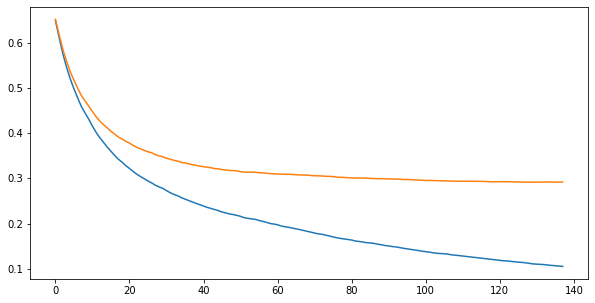

In [166]:
epochs = len(results["validation_0"]["error"])
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(epochs), results["validation_0"]["logloss"])
ax.plot(range(epochs), results["validation_1"]["logloss"])

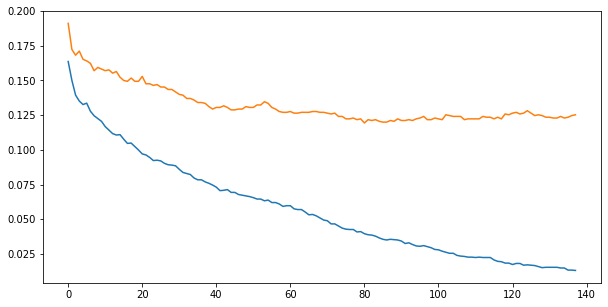

In [167]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(epochs), results["validation_0"]["error"])
ax.plot(range(epochs), results["validation_1"]["error"])

In [ ]:
# LGBMClassifier
param_dist = {
    "model__n_estimators": [1000, 5000, 10000],
    "model__learning_rate": [0.003, 0.01, 0.03, 0.1, 0.3],
    "model__max_depth": [8, 10, 12],
    "model__num_leaves": [25, 31, 35, 40],
    "model__reg_lambda": [0, 0.5, 1],
    "model__reg_alpha": [0, 0.5, 1],
    "model__colsample_bytree": [0.5, 0.6 0.75],
    "model__stopping_round": [10, 20]
}

selected_features = mrmr_classif(X=final_dfs[5], y=y_new, K=feature_sel_strategies[5])

pipe_lgbm = Pipeline(steps=[("trans_std", PowerTransformer()), ("model", LGBMClassifier())])

rand_clf = RandomizedSearchCV(pipe_lgbm,
                              param_dist,
                              n_iter=20,
                              cv=StratifiedKFold(n_splits=10),
                              scoring="accuracy",
                              n_jobs=1,
                              verbose=10)

rand_clf.fit(final_dfs[5][selected_features], y_new)

100%|██████████| 29/29 [00:00<00:00, 39.19it/s]


Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV 1/10; 1/20] START model__colsample_bytree=0.75, model__learning_rate=0.1, model__max_depth=10, model__n_estimators=500, model__num_leaves=40, model__reg_alpha=0, model__reg_lambda=0, model__stopping_round=5
[CV 1/10; 1/20] END model__colsample_bytree=0.75, model__learning_rate=0.1, model__max_depth=10, model__n_estimators=500, model__num_leaves=40, model__reg_alpha=0, model__reg_lambda=0, model__stopping_round=5;, score=0.884 total time=   2.7s
[CV 2/10; 1/20] START model__colsample_bytree=0.75, model__learning_rate=0.1, model__max_depth=10, model__n_estimators=500, model__num_leaves=40, model__reg_alpha=0, model__reg_lambda=0, model__stopping_round=5
[CV 2/10; 1/20] END model__colsample_bytree=0.75, model__learning_rate=0.1, model__max_depth=10, model__n_estimators=500, model__num_leaves=40, model__reg_alpha=0, model__reg_lambda=0, model__stopping_round=5;, score=0.850 total time=   2.7s
[CV 3/10; 1/20] START model__co

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('trans_std', PowerTransformer()),
                                             ('model', LGBMClassifier())]),
                   n_iter=20, n_jobs=1,
                   param_distributions={'model__colsample_bytree': [0.5, 0.75,
                                                                    1],
                                        'model__learning_rate': [0.003, 0.01,
                                                                 0.03, 0.1,
                                                                 0.3],
                                        'model__max_depth': [8, 10, 12],
                                        'model__n_estimators': [100, 500, 1000,
                                                                5000, 10000],
                                        'model__num_leaves': [25, 31, 35, 40],
                                

In [ ]:
rand_clf.best_estimator_, rand_clf.best_score_

(Pipeline(steps=[('trans_std', PowerTransformer()),
                 ('model',
                  LGBMClassifier(colsample_bytree=1, max_depth=12,
                                 n_estimators=5000, reg_alpha=0, reg_lambda=0.5,
                                 stopping_round=5))]), 0.8718386399187341)

In [ ]:
results_lgbm = get_scores(LGBMClassifier(colsample_bytree=1, max_depth=12,
                                         n_estimators=5000, reg_alpha=0, reg_lambda=0.5,
                                         stopping_round=10),
                          final_dfs[5], y_new, feature_sel_strategies[5])

100%|██████████| 29/29 [00:01<00:00, 22.92it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.892) total time=  27.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.6s remaining:    0.0s


[CV] END ................................ score: (test=0.855) total time=  26.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   54.3s remaining:    0.0s


[CV] END ................................ score: (test=0.894) total time=  27.2s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s


[CV] END ................................ score: (test=0.873) total time=  26.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.8min remaining:    0.0s


[CV] END ................................ score: (test=0.878) total time=  26.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.3min remaining:    0.0s


[CV] END ................................ score: (test=0.853) total time=  26.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.7min remaining:    0.0s


[CV] END ................................ score: (test=0.864) total time=  26.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.1min remaining:    0.0s


[CV] END ................................ score: (test=0.878) total time=  26.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.6min remaining:    0.0s


[CV] END ................................ score: (test=0.860) total time=  27.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.0min remaining:    0.0s


[CV] END ................................ score: (test=0.869) total time=  26.7s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.5min finished


In [ ]:
results_lgbm

(0.8718386399187341,
 0.013477567793377103,
 array([0.89241623, 0.85537919, 0.89417989, 0.87301587, 0.87830688,
        0.85335689, 0.8639576 , 0.87809187, 0.86042403, 0.86925795]))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(final_dfs[5][selected_features],
                                                  y_new, 
                                                  test_size=0.3, 
                                                  random_state=27)

lgbm_clf = LGBMClassifier(colsample_bytree=1, 
                          max_depth=12,
                          n_estimators=5000, 
                          reg_alpha=0, 
                          reg_lambda=0.5)

eval_set = [(X_train, y_train), (X_val, y_val)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=5, eval_metric=["error", "binary_logloss"], 
            eval_set=eval_set, verbose=50)

Training until validation scores don't improve for 5 rounds.
[50]	training's binary_logloss: 0.184481	training's binary_logloss: 0.184481	valid_1's binary_logloss: 0.316862	valid_1's binary_logloss: 0.316862
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.106832	training's binary_logloss: 0.106832	valid_1's binary_logloss: 0.300633	valid_1's binary_logloss: 0.300633


LGBMClassifier(colsample_bytree=1, max_depth=12, n_estimators=5000, reg_alpha=0,
               reg_lambda=0.5)

In [ ]:
from sklearn.metrics import accuracy_score
y_preds = lgbm_clf.predict(X_val)
acc = accuracy_score(y_val, y_preds)
acc

0.8688235294117647

In [ ]:
results = lgbm_clf.evals_result_

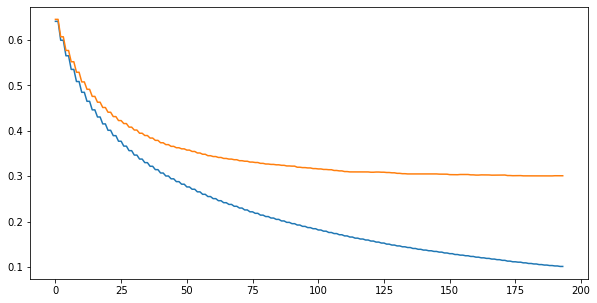

In [ ]:
epochs = len(results["training"]["binary_logloss"])
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(epochs), results["training"]["binary_logloss"])
ax.plot(range(epochs), results["valid_1"]["binary_logloss"]);

In [ ]:
#HistGradientBoostingClassifier
param_dist = {
    "model__learning_rate": [0.01, 0.03, 0.1, 0.3],
    "model__max_iter": [500, 1000, 2000],
    "model__early_stopping": [True],
    "model__n_iter_no_change": [10],
    "model__l2_regularization": [0, 1, 2],
    "model__max_depth": [6, 8, 10],
    "model__max_bins": [100, 150, 200, 255]
}

selected_features = mrmr_classif(X=final_dfs[6], y=y_new, K=feature_sel_strategies[6])

pipe_hgb = Pipeline(steps=[("trans_std", StandardScaler()), ("model", HistGradientBoostingClassifier())])

rand_clf = RandomizedSearchCV(pipe_hgb,
                              param_dist,
                              n_iter=50,
                              cv=StratifiedKFold(n_splits=10),
                              scoring="accuracy",
                              n_jobs=1,
                              verbose=50)

rand_clf.fit(final_dfs[6][selected_features], y_new)

100%|██████████| 28/28 [00:02<00:00, 12.86it/s]


Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV 1/10; 1/50] START model__early_stopping=True, model__l2_regularization=0, model__learning_rate=0.01, model__max_bins=200, model__max_depth=6, model__max_iter=1000, model__n_iter_no_change=10
[CV 1/10; 1/50] END model__early_stopping=True, model__l2_regularization=0, model__learning_rate=0.01, model__max_bins=200, model__max_depth=6, model__max_iter=1000, model__n_iter_no_change=10;, score=0.884 total time=  12.7s
[CV 2/10; 1/50] START model__early_stopping=True, model__l2_regularization=0, model__learning_rate=0.01, model__max_bins=200, model__max_depth=6, model__max_iter=1000, model__n_iter_no_change=10
[CV 2/10; 1/50] END model__early_stopping=True, model__l2_regularization=0, model__learning_rate=0.01, model__max_bins=200, model__max_depth=6, model__max_iter=1000, model__n_iter_no_change=10;, score=0.845 total time=   4.6s
[CV 3/10; 1/50] START model__early_stopping=True, model__l2_regularization=0, model__learning_r

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('trans_std', StandardScaler()),
                                             ('model',
                                              HistGradientBoostingClassifier())]),
                   n_iter=50, n_jobs=1,
                   param_distributions={'model__early_stopping': [True],
                                        'model__l2_regularization': [0, 1, 2],
                                        'model__learning_rate': [0.01, 0.03,
                                                                 0.1, 0.3],
                                        'model__max_bins': [100, 150, 200, 255],
                                        'model__max_depth': [6, 8, 10],
                                        'model__max_iter': [500, 1000, 2000],
                                        'model__n_iter_no_change': [10]},
                   scoring='accuracy', verbose=5

In [ ]:
rand_clf.best_estimator_, rand_clf.best_score_

(Pipeline(steps=[('trans_std', StandardScaler()),
                 ('model',
                  HistGradientBoostingClassifier(early_stopping=True,
                                                 l2_regularization=1,
                                                 max_bins=150, max_depth=8,
                                                 max_iter=2000))]),
 0.8660138600656857)

In [ ]:
results_hgb = get_scores(HistGradientBoostingClassifier(early_stopping=True,
                                                        l2_regularization=1,
                                                        max_iter=500),
                         final_dfs[6], y_new, feature_sel_strategies[6])

100%|██████████| 41/41 [00:02<00:00, 18.35it/s]


In [ ]:
results_hgb

(0.8683053826163366,
 0.01725087293416374,
 array([0.90123457, 0.86067019, 0.89594356, 0.87830688, 0.85537919,
        0.85512367, 0.86925795, 0.85159011, 0.84982332, 0.86572438]))

In [ ]:
# CatBoostClassifier
cat_clf = CatBoostClassifier()

param_dist = {
    "iterations": [1000, 2000, 5000, 10000],
    "learning_rate": [0.003, 0.01, 0.03, 0.1],
    "depth": [4, 6, 8],
    "random_strength": [0, 1, 2],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "early_stopping_rounds": [50],
    "custom_loss": ["AUC", "Accuracy"],
    "verbose": [50]
}

selected_features = mrmr_classif(X=final_dfs[7], y=y_new, K=feature_sel_strategies[7])

results = cat_clf.randomized_search(param_dist,
                                    X=final_dfs[7][selected_features],
                                    y=y_new,
                                    n_iter=20,
                                    cv=StratifiedKFold(n_splits=10),
                                    verbose=50)

100%|██████████| 33/33 [00:00<00:00, 47.08it/s]


0:	learn: 0.6861241	test: 0.6863547	best: 0.6863547 (0)	total: 9.34ms	remaining: 9.33s
50:	learn: 0.4889919	test: 0.5019074	best: 0.5019074 (50)	total: 371ms	remaining: 6.9s
100:	learn: 0.4129227	test: 0.4382061	best: 0.4382061 (100)	total: 750ms	remaining: 6.67s
150:	learn: 0.3724238	test: 0.4071600	best: 0.4071600 (150)	total: 1.12s	remaining: 6.3s
200:	learn: 0.3467154	test: 0.3894174	best: 0.3894174 (200)	total: 1.49s	remaining: 5.92s
250:	learn: 0.3264892	test: 0.3762321	best: 0.3762321 (250)	total: 1.86s	remaining: 5.56s
300:	learn: 0.3117194	test: 0.3679432	best: 0.3679432 (300)	total: 2.23s	remaining: 5.17s
350:	learn: 0.2986956	test: 0.3608376	best: 0.3608376 (350)	total: 2.59s	remaining: 4.78s
400:	learn: 0.2875942	test: 0.3555107	best: 0.3555107 (400)	total: 2.97s	remaining: 4.43s
450:	learn: 0.2776080	test: 0.3517456	best: 0.3517456 (450)	total: 3.33s	remaining: 4.05s
500:	learn: 0.2678253	test: 0.3478079	best: 0.3478079 (500)	total: 3.88s	remaining: 3.86s
550:	learn: 0.259

In [ ]:
pd.DataFrame(results["cv_results"])

iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0              0           0.691548          0.000103            0.691501   
1              1           0.689877          0.000156            0.689791   
2              2           0.688190          0.000227            0.688068   
3              3           0.686605          0.000301            0.686432   
4              4           0.685108          0.000357            0.684897   
...          ...                ...               ...                 ...   
9995        9995           0.300201          0.031594            0.151488   
9996        9996           0.300201          0.031595            0.151484   
9997        9997           0.300200          0.031596            0.151481   
9998        9998           0.300199          0.031598            0.151479   
9999        9999           0.300199          0.031598            0.151475   

      train-Logloss-std  test-Accuracy-mean  test-Accuracy-std  \
0              0.000030            0.770342           0.009193   
1              0.000059            0.786582           0.014031   
2              0.000074            0.792405           0.015120   
3              0.000130            0.793995           0.012230   
4              0.000145            0.789234           0.015165   
...                 ...                 ...                ...   
9995           0.022567            0.872014           0.016431   
9996           0.022572            0.872014           0.016431   
9997           0.022576            0.872014           0.016431   
9998           0.022579            0.872014           0.016431   
9999           0.022584            0.872014           0.016431   

      train-Accuracy-mean  train-Accuracy-std  
0                0.778131            0.004938  
1                0.793527            0.006267  
2                0.798391            0.005426  
3                0.799647            0.005645  
4                0.797214            0.006681  
...                   ...                 ...  
9995             0.964383            0.013184  
9996             0.964383            0.013184  
9997             0.964383            0.013184  
9998             0.964383            0.013184  
9999             0.964383            0.013184  

[10000 rows x 9 columns]

In [ ]:
results["params"]

{'custom_metric': 'AUC',
 'depth': 6,
 'iterations': 10000,
 'l2_leaf_reg': 9,
 'learning_rate': 0.01,
 'od_wait': 80,
 'random_strength': 2,
 'verbose': 50}

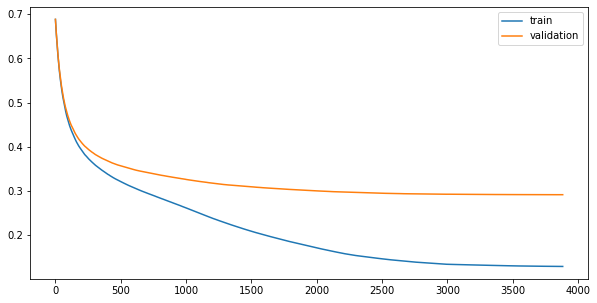

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(results["cv_results"]["iterations"], results["cv_results"]["train-Logloss-mean"], label="train")
ax.plot(results["cv_results"]["iterations"], results["cv_results"]["test-Logloss-mean"], label="validation")
ax.legend()

In [ ]:
from catboost import cv, Pool
params = {
    "iterations": 10000,
    "depth": 6,
    'l2_leaf_reg': 9,
    'learning_rate': 0.01,
    'od_wait': 80,
    'random_strength': 2,
    "loss_function": "Logloss",
    "custom_loss": ["Accuracy", "AUC"]
}

selected_features = mrmr_classif(X=final_dfs[7], y=y_new, K=feature_sel_strategies[7])

pool = Pool(data=final_dfs[7][selected_features],
            label=y_new)
cv_data = cv(
    params=params,
    pool=pool,
    folds=StratifiedKFold(n_splits=10),
    shuffle=True,
    partition_random_seed=0,
    verbose=100,
    #early_stopping_rounds=50
)

100%|██████████| 33/33 [00:02<00:00, 15.77it/s]


Training on fold [0/10]
0:	learn: 0.6765140	test: 0.6755883	best: 0.6755883 (0)	total: 20.5ms	remaining: 20.5s
100:	learn: 0.3428134	test: 0.3469342	best: 0.3469342 (100)	total: 1.88s	remaining: 16.7s
200:	learn: 0.2898353	test: 0.3124770	best: 0.3124770 (200)	total: 3.83s	remaining: 15.2s
300:	learn: 0.2524721	test: 0.2915856	best: 0.2915856 (300)	total: 5.74s	remaining: 13.3s
400:	learn: 0.2175533	test: 0.2758048	best: 0.2758048 (400)	total: 7.58s	remaining: 11.3s
500:	learn: 0.1888597	test: 0.2658379	best: 0.2658379 (500)	total: 9.95s	remaining: 9.91s
600:	learn: 0.1645108	test: 0.2593416	best: 0.2593416 (600)	total: 11s	remaining: 7.29s
700:	learn: 0.1456213	test: 0.2552869	best: 0.2549909 (694)	total: 11.9s	remaining: 5.09s
800:	learn: 0.1287203	test: 0.2517110	best: 0.2514328 (796)	total: 12.9s	remaining: 3.2s
900:	learn: 0.1147994	test: 0.2488431	best: 0.2488431 (900)	total: 13.9s	remaining: 1.52s
999:	learn: 0.1023405	test: 0.2461629	best: 0.2461629 (999)	total: 14.8s	remaining

In [ ]:
pd.DataFrame(cv_data)

iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0              0           0.687970          0.000264            0.687880   
1              1           0.683595          0.000550            0.683425   
2              2           0.678714          0.000689            0.678430   
3              3           0.674287          0.000858            0.673936   
4              4           0.669961          0.000987            0.669470   
...          ...                ...               ...                 ...   
3708        3708           0.292973          0.029127            0.130051   
3709        3709           0.292970          0.029134            0.130047   
3710        3710           0.292969          0.029135            0.130044   
3711        3711           0.292964          0.029145            0.130040   
3712        3712           0.292965          0.029143            0.130035   

      train-Logloss-std  test-Accuracy-mean  test-Accuracy-std  \
0              0.000108            0.755692           0.013576   
1              0.000156            0.765402           0.015404   
2              0.000264            0.780227           0.017054   
3              0.000340            0.789583           0.019177   
4              0.000516            0.791700           0.019600   
...                 ...                 ...                ...   
3708           0.019088            0.871131           0.016973   
3709           0.019095            0.871131           0.016973   
3710           0.019099            0.871131           0.016973   
3711           0.019107            0.871131           0.016973   
3712           0.019117            0.871131           0.016973   

      train-Accuracy-mean  train-Accuracy-std  test-AUC-mean  test-AUC-std  
0                0.759714            0.003763       0.821098      0.019496  
1                0.770932            0.004330       0.840594      0.019545  
2                0.783564            0.004526       0.858782      0.017733  
3                0.790546            0.004687       0.862516      0.016245  
4                0.795194            0.003207       0.866914      0.015906  
...                   ...                 ...            ...           ...  
3708             0.977621            0.009552       0.945666      0.011624  
3709             0.977621            0.009552       0.945669      0.011629  
3710             0.977621            0.009552       0.945669      0.011629  
3711             0.977621            0.009552       0.945669      0.011629  
3712             0.977621            0.009552       0.945668      0.011627  

[3713 rows x 11 columns]

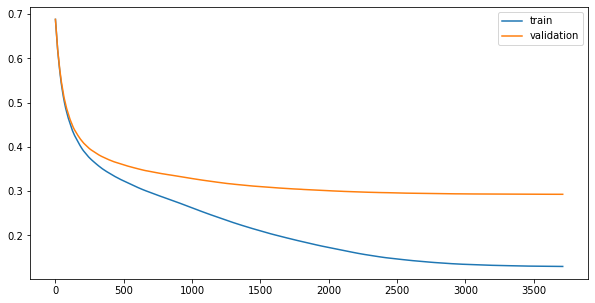

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(cv_data["iterations"], cv_data["train-Logloss-mean"], label="train")
ax.plot(cv_data["iterations"], cv_data["test-Logloss-mean"], label="validation")
ax.legend()

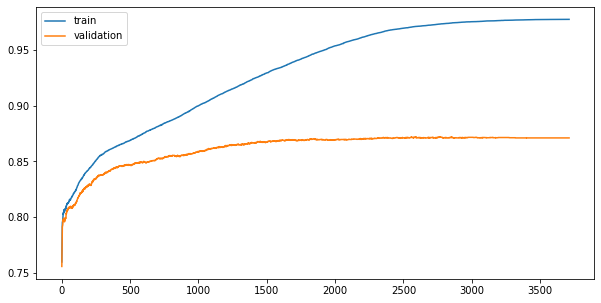

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(cv_data["iterations"], cv_data["train-Accuracy-mean"], label="train")
ax.plot(cv_data["iterations"], cv_data["test-Accuracy-mean"], label="validation")
ax.legend()

# Preparing Test Data and Final Predictions

In [97]:
log_reg = LogisticRegression(C=0.5, max_iter=300)
knn_clf = KNeighborsClassifier(n_neighbors=11, weights='distance')
svc = SVC(C=3, tol=0.0001)
rf_clf = RandomForestClassifier(max_features=0.5, min_samples_leaf=2, min_samples_split=8)
xgb_clf = XGBClassifier(n_estimators=5000, colsample_bytree=0.5, early_stopping_rounds=10, 
                        eta=0.3, reg_lambda=5, max_depth=6, model__verbosity=2)
lgbm_clf = LGBMClassifier(colsample_bytree=1, max_depth=12, n_estimators=5000, 
                          reg_alpha=0, reg_lambda=0.5, stopping_round=5)
hgb_clf = HistGradientBoostingClassifier(early_stopping=True, l2_regularization=1, max_bins=150,
                                         max_depth=8, max_iter=2000)
cat_clf = CatBoostClassifier(iterations=10000, depth=6, l2_leaf_reg=9, learning_rate=0.01, 
                             od_wait=80, random_strength=2)
list_of_final_models = [log_reg, knn_clf, svc, rf_clf, xgb_clf, lgbm_clf, hgb_clf, cat_clf]

In [98]:
with open("drive/MyDrive/US Elections/Notebook Data/corr_strategies.pickle", "rb") as corr_strategies_:
  corr_strategies = pickle.load(corr_strategies_)

In [101]:
def preprocess_testset(X_train, y_train, X_test, y_test, fg_df, corr_strategies, corr_dfs):
  # Creating copy of test set
  X_test_new = X_test.reset_index(drop=True).copy()
  y_test_new = y_test.reset_index(drop=True).copy()

  # Imputing and encoding
  X_test_new["monthly housing costs - median"] = X_test_new["monthly housing costs - median"].fillna(X_test_new["monthly housing costs - median"].median())
  X_test_new["district"] = X_test_new["district"].astype("category").cat.codes
  X_test_new["state"] = X_test_new["state"].astype("category").cat.codes
  
  # Interactions
  X_interactions = pd.DataFrame()
  X_interactions["district*state"] = X_test_new["district"] * X_test_new["state"]
  X_interactions["district*percent uninsured"] = X_test_new["district"] * X_test_new["percent uninsured"]

  # Tree-based Feature Generation
  fg_strategy, fg_dataframes = {}, {}
  for num in range(8):
    strat = fg_df[fg_df.iloc[:, (num*4):(num+1)*4].columns].mean().idxmax().split("_")
    fg_strategy[strat[0]] = strat[-1]

  for num, (model, depth) in enumerate(fg_strategy.items()):
    gbfg = GradientBoostingFeatureGenerator(stack_to_X=False, n_estimators=1, max_depth=int(depth))
    # Fit on training set
    gbfg.fit(X_train, y_train)
    # Transform test set
    X_new = np.asarray(gbfg.transform(X_test_new))
    fg_dataframes[model] = pd.DataFrame(X_new, columns=[f"fg_{i}" for i in range(X_new.shape[1])])

  # Dropping correlated Features
  corr_dfs_test = {}
  for model, df in corr_dfs.items():
    cols_dropped = list(set(X_test_new.columns).symmetric_difference(set(df.columns)))
    corr_dfs_test[str(model)] = cols_dropped
  
  # Putting Datasets for different algorithms together
  X_test_base = pd.concat([X_test_new, X_interactions], axis=1)
  #return X_test_base, corr_dfs_test
  X_test_dfs = []
  for (model, fg_df), (model_, cols) in zip(fg_dataframes.items(), corr_dfs_test.items()):
    #X_test_base_dropped = X_test_base.drop(cols, axis=1)
    #X_test_final = pd.concat([X_test_base_dropped, fg_df], axis=1)
    X_test_final = pd.concat([X_test_base, fg_df], axis=1)
    X_test_dfs.append(X_test_final)
  
  return X_test_dfs

In [132]:
X_test_prepared = preprocess_testset(X, y, X_test, y_test, fg_df, corr_strategies, corr_dfs)

In [135]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score

def final_predictions(final_dfs_normal, y_train, X_test_prepared, y_test, list_of_final_models, 
                      feature_sel_strategies):
  scores = pd.DataFrame()
  for num, (train, test) in enumerate(zip(final_dfs_normal, X_test_prepared)):
    print(num)
    # Feature Selection with mrmr
    selected_features = mrmr_classif(X=train, y=y_train, K=feature_sel_strategies[num])
    print(len(selected_features))
    
    # Transforming and Standardizing
    trans_std = PowerTransformer()
    train_prepared = trans_std.fit_transform(train[selected_features])
    train_prepared = pd.DataFrame(train_prepared, columns=trans_std.get_feature_names_out())
    test_prepared = trans_std.transform(test[selected_features])
    test_prepared = pd.DataFrame(test_prepared, columns=trans_std.get_feature_names_out())
    
    # Model fitting and get prediction probabilities
    model = list_of_final_models[num]
    model.fit(train_prepared[selected_features], y_train)
    test_preds = model.predict(test_prepared[selected_features])
    
    # Saving results
    scores.loc["accuracy", str(list_of_final_models[num])] = accuracy_score(y_test, test_preds)
    scores.loc["auc", str(list_of_final_models[num])] = roc_auc_score(y_test, test_preds)
    scores.loc["precision", str(list_of_final_models[num])] = precision_score(y_test, test_preds)
    scores.loc["recall", str(list_of_final_models[num])] = recall_score(y_test, test_preds)
  return scores

In [136]:
test_results = final_predictions(final_dfs, y_new, X_test_prepared, y_test, list_of_final_models, 
                                 feature_sel_strategies)

0


100%|██████████| 38/38 [00:01<00:00, 34.46it/s]


38
1


100%|██████████| 30/30 [00:00<00:00, 33.53it/s]


30
2


100%|██████████| 32/32 [00:00<00:00, 36.78it/s]


32
3


100%|██████████| 27/27 [00:00<00:00, 35.74it/s]


27
4


100%|██████████| 33/33 [00:00<00:00, 34.57it/s]


33
5


100%|██████████| 29/29 [00:01<00:00, 21.02it/s]


29
6


100%|██████████| 28/28 [00:00<00:00, 37.22it/s]


28
7


100%|██████████| 33/33 [00:00<00:00, 34.52it/s]


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
5000:	learn: 0.0804813	total: 57.1s	remaining: 57.1s
5001:	learn: 0.0804658	total: 57.1s	remaining: 57.1s
5002:	learn: 0.0804505	total: 57.1s	remaining: 57.1s
5003:	learn: 0.0804293	total: 57.1s	remaining: 57.1s
5004:	learn: 0.0803978	total: 57.2s	remaining: 57s
5005:	learn: 0.0803775	total: 57.2s	remaining: 57s
5006:	learn: 0.0803544	total: 57.2s	remaining: 57s
5007:	learn: 0.0803395	total: 57.2s	remaining: 57s
5008:	learn: 0.0803305	total: 57.2s	remaining: 57s
5009:	learn: 0.0803063	total: 57.2s	remaining: 57s
5010:	learn: 0.0802849	total: 57.2s	remaining: 57s
5011:	learn: 0.0802808	total: 57.2s	remaining: 57s
5012:	learn: 0.0802581	total: 57.2s	remaining: 56.9s
5013:	learn: 0.0802340	total: 57.2s	remaining: 56.9s
5014:	learn: 0.0802093	total: 57.3s	remaining: 56.9s
5015:	learn: 0.0801881	total: 57.3s	remaining: 56.9s
5016:	learn: 0.0801694	total: 57.3s	remaining: 56.9s
5017:	learn: 0.0801437	total: 57.3s	remaining: 5